##### Problem
The problem at hand is a decrease in customer satisfaction, leading to concerns about customer retention and loyalty. Amazon has observed a decline in customer satisfaction scores, an increase in negative customer feedback. The goal of this data science project is to understand the root causes of the declining customer satisfaction and develop actionable insights and recommendations to address the issue effectively.

##### Business Objectives

- Personalize recommendations and product offerings to increase customer engagement and sales.
- Optimize Customer Purchasing Experience by filtering out fake reviews
- Enhance the quality of existing products to improve customers perception of the company thereby fostering customer loyalty and repeat purchases

##### Research Objectives

- To analyze product quality issues to gauge main pain points that customers deal with when interacting with the platform

- To develop a model to classify fake or manipulated reviews within the dataset 

- To investigate the impact of incorporating review text, on the performance of the product recommendation system.


In [1]:
#Import Libraries

from pyspark.sql import SparkSession,DataFrame
import pandas as pd
from functools import reduce
from pyspark.sql.functions import rand
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql.types import StringType,FloatType,TimestampType,DateType,ArrayType,IntegerType
import re
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Tokenizer,CountVectorizer,IDF\
,HashingTF,NGram,BucketedRandomProjectionLSH,Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
import math    
from textblob import TextBlob
import string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from scipy.stats import pointbiserialr
import plotly.express as px
from pyspark.conf import SparkConf
import wordcloud 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator,BinaryClassificationEvaluator,MulticlassClassificationEvaluator,\
ClusteringEvaluator
from pyspark.ml.clustering import KMeans,BisectingKMeans,KMeansModel
from pyspark.ml.classification import NaiveBayes,LinearSVC,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier
from pyspark.ml.recommendation import ALS,ALSModel
from pyspark.ml import Transformer
from pyspark.ml.param import Param, Params
from pyspark.ml.param.shared import HasInputCol, HasOutputCol,TypeConverters
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable
from pyspark import keyword_only
from pyspark.ml.linalg import Vectors, VectorUDT
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pyspark.ml.feature import StringIndexer,IndexToString,MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.mllib.linalg.distributed import CoordinateMatrix
import multiprocessing
from textblob import Word
import numpy as np
from collections import Counter
import plotly.graph_objects as go

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("amazonapp").getOrCreate()

# Read the data from a tab-separated values (TSV) file located in a Google Cloud Storage (GCS) bucket

# The data contains us customer product reviews from Amazon and is stored in the file amazonReviews1M.tsv

#This dataset is a sample of a much larger dataset from kaggle which contains over 100 million rows 
#(https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset)

#The dataset is a random sample of the original dataset
df = spark.read.format("csv").option("delimiter", "\t").option("header", "true")\
.load("gs://productpal_bucket/amazonReviews1M.tsv")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/07 23:03:58 INFO SparkEnv: Registering MapOutputTracker
23/08/07 23:03:58 INFO SparkEnv: Registering BlockManagerMaster
23/08/07 23:03:58 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/08/07 23:03:58 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
#checking the size of the dataset
df.count()

1033363

In [4]:
#The data contains customer product reviews from Amazon with each review having a class column where "0" 
#indicates not spam and "1" indicates spam reviews.

#dataset was sourced from https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam
spam_df = spark.read.option("header", "true")\
.json("gs://productpal_bucket/amazon_reviews_spam_dataset.json")

In [5]:
#checking the size of the dataset
spam_df.count()

2021190

In [6]:
#taking sample of dataset to see what data is like
spam_df.limit(5).toPandas()

_id        asin                     category  \
0  (5a1321d5741a2384e802c551,)  011040047X  Cell_Phones_and_Accessories   
1  (5a1321d5741a2384e802c561,)  0110400550  Cell_Phones_and_Accessories   
2  (5a1321d5741a2384e802c564,)  0110400550  Cell_Phones_and_Accessories   
3  (5a1321d5741a2384e802c590,)  1059598515  Cell_Phones_and_Accessories   
4  (5a1321d5741a2384e802c599,)  1059949202  Cell_Phones_and_Accessories   

   class helpful  overall                                         reviewText  \
0    0.0  [2, 2]      1.0  The case pictured is a soft violet color, but ...   
1    0.0  [0, 0]      2.0  slips off almost broke my phone instead... but...   
2    0.0  [1, 2]      2.0  this case is very pretty and cool but its not ...   
3    1.0  [0, 0]      5.0  Works great. Just have to make sure the batter...   
4    0.0  [0, 0]      1.0  Does not work with Dell Venue 8 Pro at all;  t...   

    reviewTime      reviewerID            reviewerName  \
0  08 14, 2012  A1EWN6KZ4HMLT7             S. Prescott   
1   07 6, 2014  A1MGIQYOKFU7OF                Leann Li   
2  07 15, 2013   ALY3HL0U9AV00                    Meli   
3   05 7, 2014   AOTUBFCM2CGHE                  Robert   
4  06 16, 2014  A28N09XCWRIOC7  Sandra Ramirez-Aguilar   

                         summary  unixReviewTime  
0                    Wrong color      1344902400  
1   but the quality was nice the      1404604800  
2       i didn't really like it.      1373846400  
3  great for soneone on the go!!      1399420800  
4                    USB Adapter      1402876800

In [7]:
#selecting specific columns which are supposed to be applicable to project
spam_df=spam_df.select(col("class"),col("reviewText"),col("reviewTime"),col("asin"),col("reviewerID"))

In [8]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    0.0  The case pictured is a soft violet color, but ...  08 14, 2012   
1    0.0  slips off almost broke my phone instead... but...   07 6, 2014   
2    0.0  this case is very pretty and cool but its not ...  07 15, 2013   
3    1.0  Works great. Just have to make sure the batter...   05 7, 2014   
4    0.0  Does not work with Dell Venue 8 Pro at all;  t...  06 16, 2014   

         asin      reviewerID  
0  011040047X  A1EWN6KZ4HMLT7  
1  0110400550  A1MGIQYOKFU7OF  
2  0110400550   ALY3HL0U9AV00  
3  1059598515   AOTUBFCM2CGHE  
4  1059949202  A28N09XCWRIOC7

In [9]:
#function that gets the shape of data set (number of rows and columns)
def shape(df):
    # Get the number of rows
    num_rows = df.count()

    # Get the number of columns
    num_cols = len(df.columns)

    # Print the shape of the DataFrame
    print(f"Shape: ({num_rows}, {num_cols})")

In [10]:
shape(spam_df)

Shape: (2021190, 5)


In [11]:
shape(df)

Shape: (1033363, 15)


In [12]:
df.limit(5).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    26524369  R3HH81BIQ3ZZE1  B00SETTZGE       10327631   
1          US    26920430  R2R0NREZG6WG2V  B006XY3Y1Y       57006252   
2          US    26523163  R1ZYSPZ3LWHVM4  B008QYE40Y      966404562   
3          US     9963368  R3VXVN0I0E1PIV  B004VFXVJW      806462967   
4          US     2662502  R2H4PHUSEOH4T8  B0009OAHQY      591505715   

                                       product_title product_category  \
0  RUGGED & DAPPER – Facial Cleanser for Men – 8 ...           Beauty   
1             Tretinoin Microsphere 0.1% USP w/w 20g           Beauty   
2  Sleek i-Divine Storm Palette Mineral based Eye...           Beauty   
3  The Shave Well Company a TRULY FOG FREE Shower...           Beauty   
4  Claiborne Cologne by Liz Claiborne for men Col...           Beauty   

  star_rating helpful_votes total_votes vine verified_purchase  \
0           3             6          11    N                 Y   
1           4             1           1    N                 Y   
2           5             1           1    N                 Y   
3           5             1           1    N                 Y   
4           5             1           1    N                 Y   

                            review_headline  \
0  Good/great face wash, poor bottle design   
1                               Works Great   
2                        Wonderful palette!   
3                          BEST MIRROR EVER   
4                                Five Stars   

                                         review_body               review_date  
0  The face wash is great. My skin feels differen...  2015-04-25T00:00:00.000Z  
1  Works well on uneven skin tone, melasma, sun s...  2012-06-08T00:00:00.000Z  
2  This eyeshadow palette is wonderful! The color...  2013-05-26T00:00:00.000Z  
3  My husband has a very rough beard and therefor...  2012-02-22T00:00:00.000Z  
4                                            Love it  2014-11-13T00:00:00.000Z

In [13]:
#shows missing values for all columns
def showMissingValues(df):
    print('\nMissing values:')
    # Iterate over each column and print the name and count of missing values
    for c in df.columns:
        null_count = df.select(count(when(col(c).isNull(), c))).collect()[0][0]    
        print("{}: {}".format(c, null_count))

In [14]:
#shows missing values for specific column
def showMissingValuesByCol(colName,df):
    print('\nMissing values:')
    null_count = df.select(count(when(col(colName).isNull(),colName))).collect()[0][0]    
    print("{}: {}".format(colName, null_count))

In [15]:
#shows rows where specific column is null
def showPandasDFOfNullRows(colName, df, limit):
    null_rows = df.filter(isnull(df[colName]))
    random_null_rows = null_rows.orderBy(rand()).limit(limit)
    return random_null_rows.toPandas()

In [16]:
showMissingValues(df)


Missing values:


marketplace: 0


customer_id: 0


review_id: 0


product_id: 0


product_parent: 0


product_title: 0


product_category: 9


star_rating: 9


helpful_votes: 9


total_votes: 9


vine: 9


verified_purchase: 9


review_headline: 69


review_body: 117


review_date: 73


In [17]:
showMissingValues(spam_df)


Missing values:


class: 0


reviewText: 0


reviewTime: 0


asin: 0


reviewerID: 0


In [18]:
#gets all the column names in dataset
spam_df.columns

['class', 'reviewText', 'reviewTime', 'asin', 'reviewerID']

In [19]:
#gets all the column names in dataset
df.columns

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [20]:
# Check the data types
print('Data types:')
print(df.dtypes)



Data types:
[('marketplace', 'string'), ('customer_id', 'string'), ('review_id', 'string'), ('product_id', 'string'), ('product_parent', 'string'), ('product_title', 'string'), ('product_category', 'string'), ('star_rating', 'string'), ('helpful_votes', 'string'), ('total_votes', 'string'), ('vine', 'string'), ('verified_purchase', 'string'), ('review_headline', 'string'), ('review_body', 'string'), ('review_date', 'string')]


In [21]:
# Check the data types
print('Data types:')
print(spam_df.dtypes)

Data types:
[('class', 'double'), ('reviewText', 'string'), ('reviewTime', 'string'), ('asin', 'string'), ('reviewerID', 'string')]


**Data Exploration Amazon Spam Reviews Dataset**

In [22]:
#gets the count for each unique values in column
spam_df.groupBy('class').count().orderBy('count').show()

+-----+-------+
|class|  count|
+-----+-------+
|  0.0| 449674|
|  1.0|1571516|
+-----+-------+



In [23]:
spam_df.groupBy('reviewText').count().orderBy('count').show()

+--------------------+-----+
|          reviewText|count|
+--------------------+-----+
|I love it it's so...|    1|
|I bought this pro...|    1|
|This case stinks!...|    1|
|I purchased this ...|    1|
|So far so good. B...|    1|
|We used the inver...|    1|
|This device solve...|    1|
|I got this a few ...|    1|
|I found the price...|    1|
|I have owned Moto...|    1|
|I've had 4 of the...|    1|
|Sent me the wrong...|    1|
|The Plantronics V...|    1|
|Ever since i boug...|    1|
|This stylus was j...|    1|
|I will qualify th...|    1|
|This case adds ju...|    1|
|I'm a cel phone f...|    1|
|the store has the...|    1|
|I have used the H...|    1|
+--------------------+-----+
only showing top 20 rows



In [24]:
spam_df.groupBy('reviewerID').count().orderBy('count').show()

+--------------+-----+
|    reviewerID|count|
+--------------+-----+
|A3CQQUQRADV2LT|    1|
| AJHGAK4318DBR|    1|
|A1GA8ZIF50NZTW|    1|
|A38XJF01NEDP3C|    1|
|A28W3WV39HEIYU|    1|
|A1JNQZCY64BHYJ|    1|
|A25KRFN1L1FV02|    1|
|A1P45J6DB7NSHL|    1|
| A6MUK4C4KRTSM|    1|
|A1VPHTNTUS52OO|    1|
| A83VUXVIDWITV|    1|
|A2GXM1FXOWGZ3F|    1|
|A3UIPHPS5Y2AKP|    1|
|A39I75BJXFT05L|    1|
| AODP5JN8ZO2PG|    1|
|A1QS78X9AAFSVF|    1|
|A2R7RCG1LMI8UZ|    1|
|A3UA3JF3MTI7QH|    1|
| A1Y705P9LAL0J|    1|
|A2H06HM7F0WOWJ|    1|
+--------------+-----+
only showing top 20 rows



In [25]:
spam_df.groupBy('asin').count().orderBy('count').show()

+----------+-----+
|      asin|count|
+----------+-----+
|B002YZNFP6|    1|
|B0039ZBW28|    1|
|B002ZN41E6|    1|
|B002P4ES4S|    1|
|B00300HSXE|    1|
|B002Q4UY90|    1|
|B00307S5AC|    1|
|B002QQ7ONC|    1|
|B0030JKDG4|    1|
|B002RJEY68|    1|
|B002SAOQBY|    1|
|B00322KNSW|    1|
|B00390WNVW|    1|
|B00387EFR6|    1|
|B00333DCBA|    1|
|B002USOCDG|    1|
|B002WSZBZC|    1|
|B002OUPFD6|    1|
|B002PINOZI|    1|
|B002QB1AO6|    1|
+----------+-----+
only showing top 20 rows



**Data Exploration Amazon Product Reviews Dataset**

In [26]:
df.groupBy('customer_id').count().orderBy('count').show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|   45769289|    1|
|   42361679|    1|
|   49245518|    1|
|   51751426|    1|
|   52626244|    1|
|   16595995|    1|
|   51375322|    1|
|   49628061|    1|
|   14143214|    1|
|   45053379|    1|
|   37793991|    1|
|   49906796|    1|
|   51338398|    1|
|   52824537|    1|
|   51757142|    1|
|   50458489|    1|
|   50262283|    1|
|   33740886|    1|
|   49163253|    1|
|   49834878|    1|
+-----------+-----+
only showing top 20 rows



In [27]:
df.groupBy('review_id').count().orderBy('count').show()

+--------------+-----+
|     review_id|count|
+--------------+-----+
|R1F9NK4MJLV7GY|    1|
| RDL2Y8P27MYCH|    1|
| RSE08ZPFQ8FDD|    1|
|R3OPP65CZGU731|    1|
|R2MDDOR9GL1RVT|    1|
|R326T7P88H22UG|    1|
| RDSLY3IIM1J3H|    1|
|R3EGBJK2GRR76N|    1|
|R2GLK05FS53OJ9|    1|
|R3MP4IV2BUHPJG|    1|
|R3J1935M5C2Y2D|    1|
|R345PNZ4BC0KGL|    1|
|R21BU3PTYDUPYD|    1|
|R2G2ZNHIXX2T68|    1|
| R6HDX1HYEQBWE|    1|
|R2DZPPNCLQ42I1|    1|
| RUFUU61UUHGZC|    1|
|R3669I3AS34DBW|    1|
| RQ0LFL027QR5H|    1|
|R2BBIFP976IV8O|    1|
+--------------+-----+
only showing top 20 rows



In [28]:
df.groupBy('product_parent').count().orderBy('count').show()

+--------------+-----+
|product_parent|count|
+--------------+-----+
|      33834219|    1|
|     187460551|    1|
|     229679771|    1|
|     836552923|    1|
|     722339009|    1|
|     863549190|    1|
|     301700244|    1|
|     469031499|    1|
|     809007019|    1|
|     471782230|    1|
|     513800915|    1|
|     591291244|    1|
|     547398027|    1|
|      47379945|    1|
|     877023820|    1|
|     252592434|    1|
|     932947275|    1|
|     598514578|    1|
|     555731854|    1|
|     287167666|    1|
+--------------+-----+
only showing top 20 rows



In [29]:
df.groupBy('product_title').count().orderBy('count').show()

+--------------------+-----+
|       product_title|count|
+--------------------+-----+
|Eau D'orange Vert...|    1|
|Trish McEvoy N 6 ...|    1|
|Softsheen Carson ...|    1|
|Denman Profession...|    1|
|FACE MAGIC-WARM B...|    1|
|Passion By Elizab...|    1|
|Freetress Equal D...|    1|
|Sexy Hair Healthy...|    1|
|Heritage Store Ca...|    1|
|MyChelle Hydratin...|    1|
|NYX Butter Gloss ...|    1|
|Plain Roll-on Ess...|    1|
|Andis 75245 Ionic...|    1|
|Kiss Products Hol...|    1|
|TIGI Bed Head Man...|    1|
|Paula's Choice SK...|    1|
|Conair Plastic LE...|    1|
|OPI Mariah Carey ...|    1|
|BR Beauty Economy...|    1|
|Ole Henriksen Ski...|    1|
+--------------------+-----+
only showing top 20 rows



In [30]:
df.groupBy('product_category').count().orderBy('count').show()

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|                null|    9|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
+--------------------+-----+
only showing top 20 rows



In [31]:
df.groupBy('star_rating').count().orderBy('count').show()

+-----------+------+
|star_rating| count|
+-----------+------+
|       null|     9|
|          2| 51764|
|          3| 81776|
|          1| 96141|
|          4|174421|
|          5|629252|
+-----------+------+



In [32]:
df.groupBy('helpful_votes').count().orderBy('count').show()

+-------------+-----+
|helpful_votes|count|
+-------------+-----+
|          344|    1|
|         1318|    1|
|          604|    1|
|          328|    1|
|          491|    1|
|         1559|    1|
|          852|    1|
|         1005|    1|
|          261|    1|
|          342|    1|
|          363|    1|
|          357|    1|
|          794|    1|
|          323|    1|
|          497|    1|
|          326|    1|
|          803|    1|
|          211|    1|
|         1562|    1|
|          570|    1|
+-------------+-----+
only showing top 20 rows



In [33]:
df.groupBy('total_votes').count().orderBy('count').show()

+-----------+-----+
|total_votes|count|
+-----------+-----+
|       1077|    1|
|        821|    1|
|        360|    1|
|        548|    1|
|        682|    1|
|        380|    1|
|        378|    1|
|        500|    1|
|        829|    1|
|       5251|    1|
|        296|    1|
|        662|    1|
|       1304|    1|
|       1001|    1|
|        987|    1|
|        733|    1|
|       1298|    1|
|        639|    1|
|        894|    1|
|        335|    1|
+-----------+-----+
only showing top 20 rows



In [34]:
df.groupBy('vine').count().orderBy('count').show()

+----+-------+
|vine|  count|
+----+-------+
|null|      9|
|   Y|   3600|
|   N|1029754|
+----+-------+



In [35]:
df.groupBy('verified_purchase').count().orderBy('count').show()

+-----------------+------+
|verified_purchase| count|
+-----------------+------+
|             null|     9|
|                N|237116|
|                Y|796238|
+-----------------+------+



In [36]:
df.groupBy('review_headline').count().orderBy('count').show()

+--------------------+-----+
|     review_headline|count|
+--------------------+-----+
|  a book to dream on|    1|
|If only today's s...|    1|
|This Was The Actu...|    1|
|   Typical Chris !!!|    1|
|An Emotional Life...|    1|
|Difficult to play...|    1|
|Verbose and unfoc...|    1|
|Ancient Egypt (Sa...|    1|
|Can things get mo...|    1|
|Two classic futur...|    1|
|Gave me quantum j...|    1|
|     I Love Lindsay!|    1|
|10 Little Rubber ...|    1|
|Good combination ...|    1|
|Another forgotten...|    1|
|    Entrepreneurship|    1|
|A Radically Ambib...|    1|
|A must-read book ...|    1|
|    A Rewarding Read|    1|
|  A Rare Opportunity|    1|
+--------------------+-----+
only showing top 20 rows



In [37]:
df.groupBy('review_body').count().orderBy('count').show()

+--------------------+-----+
|         review_body|count|
+--------------------+-----+
|Total waste of $2...|    1|
|Slightly differen...|    1|
|This is awesome f...|    1|
|You won't find a ...|    1|
|Fits perfectly.  ...|    1|
|The set came with...|    1|
|Was surprised whe...|    1|
|First of all, the...|    1|
|I bought this ref...|    1|
|Got it as a Chris...|    1|
|Full disclosure: ...|    1|
|This machine work...|    1|
|Good strong tray....|    1|
|Was getting too m...|    1|
|Simple to install...|    1|
|You have to work ...|    1|
|I purchased these...|    1|
|The description s...|    1|
|You can't beat it...|    1|
|            IT IS OK|    1|
+--------------------+-----+
only showing top 20 rows



In [38]:
df.groupBy('review_date').count().orderBy('count').show()

+--------------------+-----+
|         review_date|count|
+--------------------+-----+
|1997-07-03T00:00:...|    1|
|1997-10-03T00:00:...|    1|
|1998-02-07T00:00:...|    1|
|1996-05-19T00:00:...|    1|
|1996-12-31T00:00:...|    1|
|1997-11-21T00:00:...|    1|
|1997-10-16T00:00:...|    1|
|1996-09-14T00:00:...|    1|
|1998-07-12T00:00:...|    1|
|1997-03-13T00:00:...|    1|
|1997-01-17T00:00:...|    1|
|1998-03-27T00:00:...|    1|
|1997-01-07T00:00:...|    1|
|1997-01-23T00:00:...|    1|
|1997-08-28T00:00:...|    1|
|1997-08-25T00:00:...|    1|
|1995-09-09T00:00:...|    1|
|1996-10-06T00:00:...|    1|
|1997-02-16T00:00:...|    1|
|1997-10-06T00:00:...|    1|
+--------------------+-----+
only showing top 20 rows



### Handling data types and missing values Amazon Product Reviews Dataset 

#### product_category

In [39]:
showPandasDFOfNullRows("product_category", df, 10)

marketplace customer_id       review_id  product_id product_parent  \
0          US    31051333  R3AEEHBJ24ICWA  B001U4ZZPK      661176068   
1          US    50625085  R2AL699XSAMK0I  B0082CXEI8      661176068   
2          US    34077068   R5QMKUM3C1KO3  B0082CXEI8      661176068   
3          US    48047331  R2OMXDNEF8VE5Q  B001U4ZZPK      661176068   
4          US     5883076  R1B99YM5JYBAUI  B00CLVNIE6        6211165   
5          US    30466043  R292MVXQ4Y7CIV  B0082CXEI8      661176068   
6          US    52259120   RZ7PQZGLI0F2J  B006VHU6PK      723345439   
7          US    31368223  R1KZPYNT0NDZNC  B00MGVKA4C      994037962   
8          US     7621146  R19OBAWEBSTEH2  B0082CXEI8      661176068   

                                       product_title product_category  \
0  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   
1  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   
2  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   
3  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   
4  Fonus 3.5mm White Premium Coiled Car Stereo Au...             None   
5  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   
6  Cross Stitch: Your Own Cross Stitch Masterpiec...             None   
7  Konjac Sponge - Original - Facial Sponge\tBeau...             None   
8  Blue Sea Systems BelowDeck Panels, Dual USB Ch...             None   

  star_rating helpful_votes total_votes  vine verified_purchase  \
0        None          None        None  None              None   
1        None          None        None  None              None   
2        None          None        None  None              None   
3        None          None        None  None              None   
4        None          None        None  None              None   
5        None          None        None  None              None   
6        None          None        None  None              None   
7        None          None        None  None              None   
8        None          None        None  None              None   

  review_headline review_body review_date  
0            None        None        None  
1            None        None        None  
2            None        None        None  
3            None        None        None  
4            None        None        None  
5            None        None        None  
6            None        None        None  
7            None        None        None  
8            None        None        None

##### Drop the rows where the last 9 rows are null. There is no essential info that can be garnered from this

In [40]:

clist = df.columns[-9:]

In [41]:
clist

['product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [42]:
df=df.dropna(subset=clist, how='all')

In [43]:
df.count()

1033354

In [44]:
showMissingValues(df)


Missing values:


marketplace: 0


customer_id: 0


review_id: 0


product_id: 0


product_parent: 0


product_title: 0


product_category: 0


star_rating: 0


helpful_votes: 0


total_votes: 0


vine: 0


verified_purchase: 0


review_headline: 60


review_body: 108


review_date: 64


In [45]:
#There is date value appearing as product_category most likely due to data misalignment so it was removed
df=df.filter(col("product_category") != "2011-09-09")

In [46]:
df.groupBy('product_category').count().orderBy('count').show(30)

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
|         Video Games|30002|
|           Furniture|30054|
|Health & Personal...|30066|
|                Baby|30113|
|               Tools|30125|
|               Video|30126|
|     Office Products|30159|
|        Pet Products|30172|
|               Shoes|30186|
|              Camera|30195|
|            Wireless|30205|
+--------------------+-----+
only showing t

In [47]:
df.groupBy('product_category').count().orderBy('count').select(col('product_category')).first()[0]

'Lawn and Garden'

In [48]:
df.filter(col("product_category").contains("slimmy sponge")).toPandas()

Empty DataFrame
Columns: [marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date]
Index: []

In [49]:
df=df.filter(~col("product_category").contains("slimmy sponge"))

In [50]:
df.groupBy('product_category').count().orderBy('count').show(30)

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
|         Video Games|30002|
|           Furniture|30054|
|Health & Personal...|30066|
|                Baby|30113|
|               Tools|30125|
|               Video|30126|
|     Office Products|30159|
|        Pet Products|30172|
|               Shoes|30186|
|              Camera|30195|
|            Wireless|30205|
+--------------------+-----+
only showing t

#### star_rating

In [51]:
df.groupBy('star_rating').count().orderBy('count').show()

+-----------+------+
|star_rating| count|
+-----------+------+
|          2| 51764|
|          3| 81776|
|          1| 96141|
|          4|174421|
|          5|629252|
+-----------+------+



In [52]:
# Convert string column to integer column
df = df.withColumn("star_rating", col("star_rating").cast("integer"))

#### review_body

In [53]:
showPandasDFOfNullRows("review_body", df, 10)

marketplace customer_id       review_id  product_id product_parent  \
0          US    17841125  R3NAS0RVURV58J  B000GT6DN8      720427700   
1          US     4840883  R3HTMI1SJP75QL  B0013UIUBC       48884393   
2          US    10499373   RZHJIPOD0B3H7  B001AWIP8G      616451129   
3          US       79040  R3FUM3N6JWVBRH  B00HNCSXF2      240952964   
4          US     2329236  R3F0L0Q47Z8QLG  B005DU2B3G      273616519   
5          US      616054  R1J7GSK9FDIE1X  B00NGF2JXC      518182826   
6          US    28057104   RBWNY0BFPU84P  B003ZJ0AWQ      421916708   
7          US     2880287  R20HOVSVK9GMBL  B00G713X28      705631352   
8          US      875538  R2H9059C5DBB70  B00JXQ4PFS      407598040   
9          US     8228741   R9JPIX5KKY0K5  B00C900ZF4      167966197   

                                       product_title        product_category  \
0                             Mix & Match Side Chair               Furniture   
1                                    No Reservations  Digital_Video_Download   
2                         Call of Duty: World at War             Video Games   
3             RYKA Women's Moxie Cross-Training Shoe                   Shoes   
4                            KMC X11SL Bicycle Chain                Outdoors   
5  YOPO 32" Wigs Long Curly Wavy Wig Cosplay Cost...                  Beauty   
6  Mucinex Multisymptom Children's Liquid, Very B...  Health & Personal Care   
7  2000-2005 Mitsubishi Eclipse Duraflex Shock Wi...              Automotive   
8  Midea WHS-121LB1 Compact Single Reversible Doo...        Major Appliances   
9  New Smart TV Remote control---with Qwerty dual...             Electronics   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            5             7           7    N                 N   
1            5             0           0    N                 Y   
2            5             0           0    N                 Y   
3            5             2           2    N                 Y   
4            5             2           2    N                 Y   
5            5             2           2    N                 Y   
6            5             0           0    N                 N   
7            3             0           0    N                 Y   
8            1            36          43    N                 Y   
9            2            18          22    N                 Y   

                                     review_headline review_body  \
0                                         Five Stars        None   
1  Delicious\tI really enjoyed this one a lot\t20...        None   
2                                         Five Stars        None   
3                                         Five Stars        None   
4                                         Five Stars        None   
5                                         Five Stars        None   
6  It worked great and my son loved the taste\tI ...        None   
7                                        Three Stars        None   
8  I put many ice-creams and yogurts in it and al...        None   
9                                          Two Stars        None   

                review_date  
0  2015-05-17T00:00:00.000Z  
1                      None  
2  2015-05-07T00:00:00.000Z  
3  2015-06-13T00:00:00.000Z  
4  2015-07-02T00:00:00.000Z  
5  2015-06-11T00:00:00.000Z  
6                      None  
7  2015-04-21T00:00:00.000Z  
8                      None  
9  2014-12-23T00:00:00.000Z

In [54]:
df.limit(10).toPandas()[["review_body"]]

review_body
0  The face wash is great. My skin feels differen...
1  Works well on uneven skin tone, melasma, sun s...
2  This eyeshadow palette is wonderful! The color...
3  My husband has a very rough beard and therefor...
4                                            Love it
5  I love this as a body lotion, but it leaves my...
6  I really like this mask. I know that a mask is...
7  I had this Daily Matte Moisturizer in the past...
8  Color shade was a bit different from the origi...
9  This isn't a pre and post...it's two of the sa...

In [55]:
df.groupBy('review_body').count().orderBy(desc('count')).show()

+-------------+-----+
|  review_body|count|
+-------------+-----+
|         Good| 1574|
|        Great| 1541|
|         good| 1517|
|        great| 1085|
|    Excellent| 1052|
|      Love it|  849|
|           ok|  713|
|    excellent|  582|
|      Awesome|  557|
|      Perfect|  531|
|     Love it!|  500|
|       Great!|  492|
|      love it|  484|
|         Nice|  480|
|    very good|  459|
|Great product|  414|
|    Very good|  406|
|    excelente|  390|
|         nice|  379|
|  Works great|  367|
+-------------+-----+
only showing top 20 rows



In [56]:
showMissingValues(df)


Missing values:


marketplace: 0


customer_id: 0


review_id: 0


product_id: 0


product_parent: 0


product_title: 0


product_category: 0


star_rating: 0


helpful_votes: 0


total_votes: 0


vine: 0


verified_purchase: 0


review_headline: 60


review_body: 108


review_date: 64


In [57]:
df.filter((isnull('review_headline')) | (isnull('review_body')) | (isnull('review_date'))).limit(10).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    20813663  R21EVZD1G1KXVB  B00629OEWS      665819280   
1          US    30465514   RWDDO61MOV4OH  B007RN1IYK      865681990   
2          US    39345384  R3UOS98R7PWS2N  B00ACL4LR0      576616467   
3          US    41455465  R32HCIS5ZS4MND  B002BH4U56      505269061   
4          US    33433702  R3H718X1C84591  B000A6U6K8      238514892   
5          US    29246701  R3E6LXEJ5QCHIA  0393320782      736198039   
6          US    13013663  R2Y0CEYQPCDUPH  B001O01KE0      264615420   
7          US    51337633  R164OBU2RBPL5D  B00138CSLM      436023672   
8          US     7235219  R30DW5GAUIAGJO  B00C5XG6XA      611455629   
9          US     4252573  R3FTX5EKLXUL5O  B001RJSNG6      421460338   

                                       product_title        product_category  \
0                            Origin8 TA42 Track Rims                  Sports   
1  Skywalker Trampolines 12-Feet Round Trampoline...                  Sports   
2  Paracord Planet Mil-Spec Commercial Grade 550l...                  Sports   
3  Star Trek: U.S.S. Enterprise NCC-1701 High Def...                    Toys   
4  Toy State CAT Big Builder Wheel Loader Lands R...                    Toys   
5  Code of the Street: Decency, Violence, and the...                   Books   
6                                       Drippin' Wet  Digital_Music_Purchase   
7                                Black & White Night  Digital_Music_Purchase   
8                                           Redeemed  Digital_Music_Purchase   
9                                            Secrets  Digital_Music_Purchase   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            5             0           0    N                 Y   
1            5             0           0    N                 Y   
2            4            29          35    N                 Y   
3            5            14          14    N                 Y   
4            5             0           0    N                 Y   
5            5             4           5    N                 N   
6            5             0           0    N                 Y   
7            5             0           0    N                 N   
8            2             0           0    N                 Y   
9            5             0           0    N                 Y   

                                     review_headline  \
0                                         Five Stars   
1                                               None   
2                                         Four Stars   
3                                 They got it right!   
4                                               None   
5                                               None   
6                                    Stoop down baby   
7  EXCELLENT! Also have this show on a DVD, ...\t...   
8  I am in the process of learning this wonderful...   
9  " just like some good ole Kentucky Fried Chick...   

                                         review_body               review_date  
0                                               None  2015-07-09T00:00:00.000Z  
1                            Good size, good quality  2015-01-04T00:00:00.000Z  
2                                               None  2014-09-18T00:00:00.000Z  
3                                               None  2015-03-25T00:00:00.000Z  
4                       Exactly as described, great!  2015-01-23T00:00:00.000Z  
5  This book should be mandatory reading for anyo...  2005-04-16T00:00:00.000Z  
6                                               None  2015-07-09T00:00:00.000Z  
7                                               None                      None  
8                                               None                      None  
9                                         2014-09-05                      None

In [58]:
# Define the regular expression pattern to match the format "yyyy-mm-dd"
date_pattern = r"\d{4}-\d{2}-\d{2}"






In [59]:
df.filter(col("review_body")
    .rlike(date_pattern)  & isnull(col("review_date"))
  ).count()

14

In [60]:
df.filter(col("review_body")
    .rlike(date_pattern) & isnull(col("review_date"))
  ).limit(10).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US     4252573  R3FTX5EKLXUL5O  B001RJSNG6      421460338   
1          US    45566062  R2XYGMALN7X3Q0  B00138JBLW      335252461   
2          US    32308077  R3SI1MVHU7YCG8  0440414806      159975375   
3          US    13411177   RQRIMLVNAX8NF  B0032FO7JK       60181104   
4          US    12972983  R3KU6WOVOKWMPH  B0045OUIWC      496599698   
5          US    25495441   RKAT3A16B7RQK  B000083JWE      729019812   
6          US    49583354  R2FPJ80HT9D749  B0009X7BHI      405822548   
7          US    11314966  R2UMEQGZHNST7F  B000P0J0EW      484638351   
8          US    17571600  R1LWEBBQ2JJ8AF  B005J4X91E      323924094   
9          US    28310525   RJA6GERDGIY2X  B00000JGHM      429439461   

                                    product_title        product_category  \
0                                         Secrets  Digital_Music_Purchase   
1                             Dream Of A Lifetime  Digital_Music_Purchase   
2                                           Holes                   Books   
3                               A Terrible Beauty  Digital_Ebook_Purchase   
4                              The Double Crosser  Digital_Ebook_Purchase   
5                                     The Best Of                   Music   
6                           Vincent & Theo (1990)               Video DVD   
7  The Shawshank Redemption (Single-Disc Edition)               Video DVD   
8                       Ballad of Mott the Hoople               Video DVD   
9                                            Heat               Video DVD   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            5             0           0    N                 Y   
1            5             0           0    N                 N   
2            5             0           0    N                 N   
3            2             1           2    N                 Y   
4            5             3           3    N                 Y   
5            2            48          51    N                 N   
6            5             3           5    N                 N   
7            5             1           1    N                 Y   
8            5            20          27    N                 Y   
9            5             2           3    N                 N   

                                     review_headline review_body review_date  
0  " just like some good ole Kentucky Fried Chick...  2014-09-05        None  
1  "Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...  2012-01-20        None  
2  "Holes ' Helps Children Dig Into Reading\tFrom...  2003-09-17        None  
3  "Gary Stu + major ranting = this not-a-story\t...  2011-10-15        None  
4  "The path...\tto Hell is paved with good inten...  2012-10-17        None  
5  "Mauriat's Best ?\tI was looking forward to re...  2005-09-29        None  
6  "Now I think I know what you tried to say to m...  2007-04-17        None  
7  "Shawshenk Redemption Redux\tIt was and remain...  2011-09-22        None  
8  "...It mesmerizes and I can't explain...\tMott...  2011-10-31        None  
9  "One Of The Best Films Of The 90's\tThis is pr...  2004-08-31        None

In [61]:
# Replace the review body with an empty string if it matches the pattern
df = df.withColumn("review_date_2", when(df["review_body"].rlike(date_pattern) & df["review_body"].isNull(), "")\
                     .otherwise(""))

In [62]:
df.filter((col("review_date_2")!="") & isnull(col("review_date"))).limit(5).toPandas()

Empty DataFrame
Columns: [marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date, review_date_2]
Index: []

In [63]:
# Replace review_date with review_date2 when review_date is null and review_date2 is not empty
df = df.withColumn("review_date", when((isnull(col("review_date"))) & (col("review_date_2") != ""), col("review_date_2"))\
                   .otherwise(col("review_date")))

In [64]:
# Replace the review body with an empty string if it matches the pattern
df = df.withColumn("review_body", when(col("review_body").rlike(date_pattern), None)\
                       .otherwise(col("review_body")))


In [65]:
# Define the regular expression pattern to match the format "yyyy-mm-dd"
date_pattern = r"^\d{4}-\d{2}-\d{2}$"


In [66]:
df.filter(col("review_headline")
    .rlike(date_pattern) ).limit(10).toPandas()

Empty DataFrame
Columns: [marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date, review_date_2]
Index: []

In [67]:
df.filter(df["review_body"].isNull()).limit(10).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    52306962  R23YRANOMDQAOF  B003RXL7KY      111969204   
1          US    18708513   RNWWK8NG44HL1  B001F4SK3E      351610450   
2          US    20813663  R21EVZD1G1KXVB  B00629OEWS      665819280   
3          US    39345384  R3UOS98R7PWS2N  B00ACL4LR0      576616467   
4          US    41455465  R32HCIS5ZS4MND  B002BH4U56      505269061   
5          US    52453104  R2FWTH6QM5KX3R  B00L1LGIU8      791188769   
6          US    13013663  R2Y0CEYQPCDUPH  B001O01KE0      264615420   
7          US    51337633  R164OBU2RBPL5D  B00138CSLM      436023672   
8          US     7235219  R30DW5GAUIAGJO  B00C5XG6XA      611455629   
9          US     4252573  R3FTX5EKLXUL5O  B001RJSNG6      421460338   

                                       product_title        product_category  \
0  Mossy Oak Cloth Tape (Mossy Oak Break-Up), 2" ...                  Sports   
1  MTech USA MT-317 Folding Tactical Knife, Stile...                  Sports   
2                            Origin8 TA42 Track Rims                  Sports   
3  Paracord Planet Mil-Spec Commercial Grade 550l...                  Sports   
4  Star Trek: U.S.S. Enterprise NCC-1701 High Def...                    Toys   
5  Pull and Stretch Bounce Ball, Squeeze It, Stre...                    Toys   
6                                       Drippin' Wet  Digital_Music_Purchase   
7                                Black & White Night  Digital_Music_Purchase   
8                                           Redeemed  Digital_Music_Purchase   
9                                            Secrets  Digital_Music_Purchase   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            5             3           4    N                 Y   
1            4            94         110    N                 Y   
2            5             0           0    N                 Y   
3            4            29          35    N                 Y   
4            5            14          14    N                 Y   
5            2            23          26    N                 Y   
6            5             0           0    N                 Y   
7            5             0           0    N                 N   
8            2             0           0    N                 Y   
9            5             0           0    N                 Y   

                                     review_headline review_body  \
0                           I like this... it works.        None   
1                      Mixed feelings-- hard to open        None   
2                                         Five Stars        None   
3                                         Four Stars        None   
4                                 They got it right!        None   
5   Would be okay if they get rid of the air pockets        None   
6                                    Stoop down baby        None   
7  EXCELLENT! Also have this show on a DVD, ...\t...        None   
8  I am in the process of learning this wonderful...        None   
9  " just like some good ole Kentucky Fried Chick...        None   

                review_date review_date_2  
0  2011-02-10T00:00:00.000Z                
1  2012-02-02T00:00:00.000Z                
2  2015-07-09T00:00:00.000Z                
3  2014-09-18T00:00:00.000Z                
4  2015-03-25T00:00:00.000Z                
5  2014-10-27T00:00:00.000Z                
6  2015-07-09T00:00:00.000Z                
7                      None                
8                      None                
9                      None

In [68]:
# Assign review_headline to review_body when review_headline is not null and review_body is null or an empty string
df = df.withColumn("review_body", when((col("review_headline").isNotNull()) \
                                       & (col("review_body").isNull() | (col("review_body") == "")),\
                                       col("review_headline")).otherwise(col("review_body")))

In [69]:
showMissingValues(df)


Missing values:


marketplace: 0


customer_id: 0


review_id: 0


product_id: 0


product_parent: 0


product_title: 0


product_category: 0


star_rating: 0


helpful_votes: 0


total_votes: 0


vine: 0


verified_purchase: 0


review_headline: 60


review_body: 0


review_date: 64


review_date_2: 0


#### review_date

In [70]:
#return records where review_date is null
df.filter(col("review_date").isNull()).limit(5).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    51337633  R164OBU2RBPL5D  B00138CSLM      436023672   
1          US     7235219  R30DW5GAUIAGJO  B00C5XG6XA      611455629   
2          US     4252573  R3FTX5EKLXUL5O  B001RJSNG6      421460338   
3          US    22028460  R2Z8K50L5GFKNA  B000VWKVSI      515353411   
4          US    30753448  R34LOIFOPWS1CW  B008593AFA       98784325   

               product_title        product_category  star_rating  \
0        Black & White Night  Digital_Music_Purchase            5   
1                   Redeemed  Digital_Music_Purchase            2   
2                    Secrets  Digital_Music_Purchase            5   
3  Ah! Leah! (Album Version)  Digital_Music_Purchase            5   
4                   Becoming  Digital_Music_Purchase            5   

  helpful_votes total_votes vine verified_purchase  \
0             0           0    N                 N   
1             0           0    N                 Y   
2             0           0    N                 Y   
3             0           0    N                 Y   
4             0           0    N                 Y   

                                     review_headline  \
0  EXCELLENT! Also have this show on a DVD, ...\t...   
1  I am in the process of learning this wonderful...   
2  " just like some good ole Kentucky Fried Chick...   
3  has been and still is one of my all-time favor...   
4  Another lame local band to sit through\tI saw ...   

                                         review_body review_date review_date_2  
0  EXCELLENT! Also have this show on a DVD, ...\t...        None                
1  I am in the process of learning this wonderful...        None                
2  " just like some good ole Kentucky Fried Chick...        None                
3  has been and still is one of my all-time favor...        None                
4  Another lame local band to sit through\tI saw ...        None

In [71]:
df.limit(5).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    26524369  R3HH81BIQ3ZZE1  B00SETTZGE       10327631   
1          US    26920430  R2R0NREZG6WG2V  B006XY3Y1Y       57006252   
2          US    26523163  R1ZYSPZ3LWHVM4  B008QYE40Y      966404562   
3          US     9963368  R3VXVN0I0E1PIV  B004VFXVJW      806462967   
4          US     2662502  R2H4PHUSEOH4T8  B0009OAHQY      591505715   

                                       product_title product_category  \
0  RUGGED & DAPPER – Facial Cleanser for Men – 8 ...           Beauty   
1             Tretinoin Microsphere 0.1% USP w/w 20g           Beauty   
2  Sleek i-Divine Storm Palette Mineral based Eye...           Beauty   
3  The Shave Well Company a TRULY FOG FREE Shower...           Beauty   
4  Claiborne Cologne by Liz Claiborne for men Col...           Beauty   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            3             6          11    N                 Y   
1            4             1           1    N                 Y   
2            5             1           1    N                 Y   
3            5             1           1    N                 Y   
4            5             1           1    N                 Y   

                            review_headline  \
0  Good/great face wash, poor bottle design   
1                               Works Great   
2                        Wonderful palette!   
3                          BEST MIRROR EVER   
4                                Five Stars   

                                         review_body  \
0  The face wash is great. My skin feels differen...   
1  Works well on uneven skin tone, melasma, sun s...   
2  This eyeshadow palette is wonderful! The color...   
3  My husband has a very rough beard and therefor...   
4                                            Love it   

                review_date review_date_2  
0  2015-04-25T00:00:00.000Z                
1  2012-06-08T00:00:00.000Z                
2  2013-05-26T00:00:00.000Z                
3  2012-02-22T00:00:00.000Z                
4  2014-11-13T00:00:00.000Z

In [72]:
# Convert the date_string column to the datetime format "yyyy-mm-dd"
df = df.withColumn("review_date", to_date(col("review_date")))

In [73]:
showMissingValuesByCol("review_date",df)


Missing values:


review_date: 64


In [74]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [75]:
df.filter(isnull(col("review_date"))).limit(10).toPandas()

marketplace customer_id       review_id  product_id product_parent  \
0          US    51337633  R164OBU2RBPL5D  B00138CSLM      436023672   
1          US     7235219  R30DW5GAUIAGJO  B00C5XG6XA      611455629   
2          US     4252573  R3FTX5EKLXUL5O  B001RJSNG6      421460338   
3          US    22028460  R2Z8K50L5GFKNA  B000VWKVSI      515353411   
4          US    30753448  R34LOIFOPWS1CW  B008593AFA       98784325   
5          US    13418638  R3TTC36XJVTT9F  B008E62TTW      174178495   
6          US    45566062  R2XYGMALN7X3Q0  B00138JBLW      335252461   
7          US    32308077  R3SI1MVHU7YCG8  0440414806      159975375   
8          US    13411177   RQRIMLVNAX8NF  B0032FO7JK       60181104   
9          US    12972983  R3KU6WOVOKWMPH  B0045OUIWC      496599698   

               product_title        product_category  star_rating  \
0        Black & White Night  Digital_Music_Purchase            5   
1                   Redeemed  Digital_Music_Purchase            2   
2                    Secrets  Digital_Music_Purchase            5   
3  Ah! Leah! (Album Version)  Digital_Music_Purchase            5   
4                   Becoming  Digital_Music_Purchase            5   
5  Shiva Murthi - Shankarudu  Digital_Music_Purchase            5   
6        Dream Of A Lifetime  Digital_Music_Purchase            5   
7                      Holes                   Books            5   
8          A Terrible Beauty  Digital_Ebook_Purchase            2   
9         The Double Crosser  Digital_Ebook_Purchase            5   

  helpful_votes total_votes vine verified_purchase  \
0             0           0    N                 N   
1             0           0    N                 Y   
2             0           0    N                 Y   
3             0           0    N                 Y   
4             0           0    N                 Y   
5             1           1    N                 N   
6             0           0    N                 N   
7             0           0    N                 N   
8             1           2    N                 Y   
9             3           3    N                 Y   

                                     review_headline  \
0  EXCELLENT! Also have this show on a DVD, ...\t...   
1  I am in the process of learning this wonderful...   
2  " just like some good ole Kentucky Fried Chick...   
3  has been and still is one of my all-time favor...   
4  Another lame local band to sit through\tI saw ...   
5  Chinna Kuyil' Musician Srimati Chitra\tVery in...   
6  "Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...   
7  "Holes ' Helps Children Dig Into Reading\tFrom...   
8  "Gary Stu + major ranting = this not-a-story\t...   
9  "The path...\tto Hell is paved with good inten...   

                                         review_body review_date review_date_2  
0  EXCELLENT! Also have this show on a DVD, ...\t...        None                
1  I am in the process of learning this wonderful...        None                
2  " just like some good ole Kentucky Fried Chick...        None                
3  has been and still is one of my all-time favor...        None                
4  Another lame local band to sit through\tI saw ...        None                
5  Chinna Kuyil' Musician Srimati Chitra\tVery in...        None                
6  "Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...        None                
7  "Holes ' Helps Children Dig Into Reading\tFrom...        None                
8  "Gary Stu + major ranting = this not-a-story\t...        None                
9  "The path...\tto Hell is paved with good inten...        None

In [76]:
#gets data types for each column
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [77]:
# Group the data by date and count the number of products for each date
date_counts = df.groupBy("review_date").count()

# Sort the result in descending order based on the count
sorted_date_counts = date_counts.orderBy(col("count").desc())

# Select the date with the highest count
most_product_date = sorted_date_counts.select("review_date").first()[0]

# Show the date with the most products
print(most_product_date)

2015-02-20


In [78]:
# Replace null values in review_date column with "2015-02-20" converted to date
df = df.na.fill({'review_date': '2015-02-20'})

In [79]:
showMissingValuesByCol("review_date",df)


Missing values:


review_date: 0


In [80]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [81]:
#converts date string to date
df = df.withColumn("review_date", to_date(col("review_date")))

In [82]:
showMissingValuesByCol("review_date",df)


Missing values:


review_date: 0


In [83]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [84]:
#drop review_date_2 column
df=df.drop(col("review_date_2"))

In [85]:
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   26524369|R3HH81BIQ3ZZE1|B00SETTZGE|      10327631|RUGGED & DAPPER –...|          Beauty|          3|            6|         11|   N|                Y|Good/great face w...|The face wash is ...| 2015-04-25|
|         US|   26920430|R2R0NREZG6WG2V|B006XY3Y1Y|      57006252|Tretinoin Microsp...|          Beauty|          4|    

In [86]:
# List of column names to drop
columns_to_drop = ('product_parent',"marketplace")

df=df.drop(*columns_to_drop)

#### review_headline

In [87]:
df=df.na.fill({'review_headline': ""})

In [88]:
showMissingValues(df)


Missing values:


customer_id: 0


review_id: 0


product_id: 0


product_title: 0


product_category: 0


star_rating: 0


helpful_votes: 0


total_votes: 0


vine: 0


verified_purchase: 0


review_headline: 0


review_body: 0


review_date: 0


### Removing Duplicates Amazon Product Reviews Dataset

In [89]:
shape(df)

Shape: (1033354, 13)


In [90]:
df=df.distinct()

In [91]:
shape(df)

Shape: (1033179, 13)


### Removing Duplicates Amazon Spam Reviews Dataset

In [92]:
shape(spam_df)

Shape: (2021190, 5)


In [93]:
spam_df=spam_df.distinct()

In [94]:
shape(spam_df)

Shape: (2017998, 5)


### Remove Nas

In [95]:
showMissingValues(df)


Missing values:


customer_id: 0


review_id: 0


product_id: 0


product_title: 0


product_category: 0


star_rating: 0


helpful_votes: 0


total_votes: 0


vine: 0


verified_purchase: 0


review_headline: 0


review_body: 0


review_date: 0


### Creating Season Column

##### Amazon Product Reviews Dataset

In [96]:
df = df.withColumn('unhelpful_votes', col('total_votes') - col('helpful_votes'))

### Creating Season Column

##### Amazon Product Reviews Dataset

In [97]:
# Create a new column "season" based on the month of "review_date"
df = df.withColumn("season", when(month(col("review_date")).isin([12, 1, 2]), "Winter")
                      .when(month(col("review_date")).isin([3, 4, 5]), "Spring")
                      .when(month(col("review_date")).isin([6, 7, 8]), "Summer")
                      .otherwise("Fall"))


##### Amazon Spam Reviews Dataset

In [98]:
func =  udf (lambda x: datetime.strptime(x, '%m %d, %Y'), DateType())

spam_df = spam_df.withColumn('reviewDate', func(col('reviewTime')))
#spam_df = spam_df.withColumn("reviewDate", to_date("reviewTime", "dd MM,yyyy"))

# Create a new column "season" based on the month of "review_date"
spam_df = spam_df.withColumn("season", when(month(col("reviewDate")).isin([12, 1, 2]), "Winter")
                      .when(month(col("reviewDate")).isin([3, 4, 5]), "Spring")
                      .when(month(col("reviewDate")).isin([6, 7, 8]), "Summer")
                      .otherwise("Fall"))

In [99]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    1.0  I love it my boyfriend loves it as well. He fi...  09 18, 2013   
1    1.0  These are the second pair we've bought because...   01 1, 2013   
2    1.0  Bought a second pair. One for in the house and...  02 15, 2014   
3    0.0  While I loved the idea of these shoes, plus th...  03 29, 2012   
4    1.0  My 3 month old wore this for her baptism and s...  11 29, 2012   

         asin      reviewerID  reviewDate  season  
0  B002OIGEJC  A2LZQ4AI8SLTGP  2013-09-18    Fall  
1  B002P7TH2I  A2E1ZF3DE2CKX8  2013-01-01  Winter  
2  B002PHLVJA  A1N0D42EOF7YLF  2014-02-15  Winter  
3  B002PHLVJA  A1E408D9QFMHT9  2012-03-29  Spring  
4  B002PILQLW  A31Y87UX41LAQQ  2012-11-29    Fall

### Creating Month Column

In [100]:
# Create a new column "month" with the month name extracted from "review_date"
df = df.withColumn("month", date_format(col("review_date"), "MMMM"))

### Creating Year Column

##### Amazon Product Reviews Dataset

In [101]:
# Create a new column "year" with the year extracted from "review_date"
df = df.withColumn("year", year(col("review_date")))

In [102]:
df.limit(5).toPandas()

customer_id       review_id  product_id  \
0    49519440   RUHR3RM99S132  B00196WJB2   
1    49282386  R1QHVKM4S33HR2  B0083RLGLE   
2    38830958   RJLGMSAEIXAU7  B00FQCQ5AG   
3    29095974  R1LMFH7TIP4X2R  B00DJYGIN2   
4    42917766  R1DYZ3QRSLTWOQ  B005FHVZG6   

                                       product_title product_category  \
0              Calendula Lotion Boiron 6.5 oz Lotion           Beauty   
1  Etude House Strawberry Sponge Hair Roller x 4e...           Beauty   
2  5 Sheets Fashion Body Art Stickers Removable W...           Beauty   
3          Yes To Blueberries Age Refresh Towelettes           Beauty   
4                        Restless Legs Calming Crème           Beauty   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            5             0           0    N                 Y   
1            1             1           2    N                 Y   
2            5             0           0    N                 Y   
3            5             0           0    N                 Y   
4            3             0           0    N                 Y   

                                     review_headline  \
0                  Best facial lotion I've ever used   
1  My hair gets tangled and I pretty much have to...   
2                                         Five Stars   
3                                         love them.   
4                        This works for some people.   

                                         review_body review_date  \
0  The best face lotion I've ever used. OK so it ...  2013-12-07   
1  Impossible for me to roll out of my hair. My h...  2014-09-15   
2                                   were really cute  2014-11-19   
3  order these all the time, love them...always t...  2015-06-14   
4  I don't have RLS but I get restless legs once ...  2015-05-18   

   unhelpful_votes  season      month  year  
0              0.0  Winter   December  2013  
1              1.0    Fall  September  2014  
2              0.0    Fall   November  2014  
3              0.0  Summer       June  2015  
4              0.0  Spring        May  2015

##### Amazon Spam Reviews Dataset

In [103]:
# Create a new column "year" with the year extracted from "review_date"
spam_df = spam_df.withColumn("year", year(col("reviewDate")))

In [104]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    1.0  I love it my boyfriend loves it as well. He fi...  09 18, 2013   
1    1.0  These are the second pair we've bought because...   01 1, 2013   
2    1.0  Bought a second pair. One for in the house and...  02 15, 2014   
3    0.0  While I loved the idea of these shoes, plus th...  03 29, 2012   
4    1.0  My 3 month old wore this for her baptism and s...  11 29, 2012   

         asin      reviewerID  reviewDate  season  year  
0  B002OIGEJC  A2LZQ4AI8SLTGP  2013-09-18    Fall  2013  
1  B002P7TH2I  A2E1ZF3DE2CKX8  2013-01-01  Winter  2013  
2  B002PHLVJA  A1N0D42EOF7YLF  2014-02-15  Winter  2014  
3  B002PHLVJA  A1E408D9QFMHT9  2012-03-29  Spring  2012  
4  B002PILQLW  A31Y87UX41LAQQ  2012-11-29    Fall  2012

### Creating Sentiment Column

##### Amazon Product Reviews Dataset

In [105]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
df = df.withColumn('sentiment_score',sentiment('review_body').cast('double'))

In [106]:
df.show()

+-----------+--------------+----------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+------+--------+----+--------------------+
|customer_id|     review_id|product_id|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|unhelpful_votes|season|   month|year|     sentiment_score|
+-----------+--------------+----------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+------+--------+----+--------------------+
|   47355039| RNN25L7RWABNA|B00GBEEVC2|(2 Clips) OEM Fac...|Major Appliances|          5|            0|          0|   N|                Y|          Five Stars|Very happy it let...| 2015-06-23|            0.0|Summer|    June|2015| 0.428571428571428

In [107]:
# Create a new column "sentiment" based on the sentiment_score
df = df.withColumn("sentiment", when(col("sentiment_score") > 0, "positive")
                                .when(col("sentiment_score") < 0, "negative")
                                .otherwise("neutral"))

In [108]:
df = df.withColumn('abs_sentiment_score', abs(df['sentiment_score']))

In [109]:
df.limit(5).toPandas()

customer_id       review_id  product_id  \
0    15874594   RTD8M8YC3OH2Z  B002HHPVB2   
1    32950636  R2O41J70NZ83MY  B0015DWJAK   
2    26223799  R3SSNK1W2JM8RH  B004SCS6V6   
3    44646471  R2W35X8VJAIYY5  B007G92QGO   
4    34233385  R1R581HLDT7ETA  B00A0X4094   

                                    product_title        product_category  \
0  Imager: The First Book of the Imager Portfolio  Digital_Ebook_Purchase   
1   Dance with a Vampire (Vampire Kisses, Book 4)  Digital_Ebook_Purchase   
2   Meant to Be (The Saving Angels Series Book 1)  Digital_Ebook_Purchase   
3                                 Defending Jacob  Digital_Ebook_Purchase   
4                                           Hymns  Digital_Ebook_Purchase   

   star_rating helpful_votes total_votes vine verified_purchase  \
0            3             0           0    N                 Y   
1            5             1           2    N                 N   
2            4             0           0    N                 Y   
3            5             0           0    N                 Y   
4            5             3           3    N                 Y   

                                     review_headline  \
0                     great book for fantasy foodies   
1                     We all want to kiss a vampire.   
2                       This book was so bittersweet   
3                                    Defending Jacob   
4  Cowper wrote hymns with deep meaning during a ...   

                                         review_body review_date  \
0  It's an interesting concept, but he spent a lo...  2013-02-06   
1  engrossing... it leaves the reader satisafied ...  2008-08-21   
2  This book was so bittersweet and I love the co...  2013-01-08   
3  Well written book that kept me enthralled. I a...  2013-06-26   
4  I enjoy reading one of his hymns not just earl...  2012-12-26   

   unhelpful_votes  season     month  year  sentiment_score sentiment  \
0              0.0  Winter  February  2013         0.065741  positive   
1              1.0  Summer    August  2008         0.550000  positive   
2              0.0  Winter   January  2013        -0.008333  negative   
3              0.0  Summer      June  2013        -0.197917  negative   
4              0.0  Winter  December  2012         0.460000  positive   

   abs_sentiment_score  
0             0.065741  
1             0.550000  
2             0.008333  
3             0.197917  
4             0.460000

##### Amazon Spam Reviews Dataset

In [110]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
spam_df = spam_df.withColumn('sentiment_score',sentiment('reviewText').cast('double'))

23/08/07 23:09:10 WARN SimpleFunctionRegistry: The function sentiment replaced a previously registered function.


In [111]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...   04 5, 2011   
1    1.0  BOUGHT THIS FOR MY SPRING EVO. WORKS GREAT! ON...  09 27, 2010   
2    1.0  Anyone who spends time traveling knows how enj...   10 4, 2002   
3    1.0  This has simplified my life as I am on the pho...  07 18, 2013   
4    1.0  I was looking for earplugs like these, with ju...  01 18, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011         0.385000  
1  819940471X  A3FY0NVLZ96B5Z  2010-09-27    Fall  2010         0.312500  
2  B00004U8KM   ALR35EFI69S5R  2002-10-04    Fall  2002         0.303333  
3  B0000CEPC8  A18WQ1QWZU6TNR  2013-07-18  Summer  2013         0.420000  
4  B0002KQZJ8  A37L2MQCKR905P  2013-01-18  Winter  2013         0.450000

In [112]:
# Create a new column "sentiment" based on the sentiment_score
spam_df = spam_df.withColumn("sentiment", when(col("sentiment_score") > 0, "positive")
                                .when(col("sentiment_score") < 0, "negative")
                                .otherwise("neutral"))

In [113]:
#create column with absolute value for sentiment_score
spam_df = spam_df.withColumn('abs_sentiment_score', abs(spam_df['sentiment_score']))

In [114]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    1.0  Made out of very durable materials, has a flui...  02 12, 2013   
1    1.0  This seller has amazing coustomer service and ...  01 23, 2013   
2    1.0  If you are looking for protection for your pho...  08 10, 2013   
3    1.0  I upgraded from an old lg420.  I liked the 840...  06 11, 2013   
4    1.0  Great smart phone for being a tracfone,more th...   08 5, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  B00AD9DR7G  A3PS8Y4MLP4WFE  2013-02-12  Winter  2013         0.163194   
1  B00AE0OCO6  A2MKXLB10AK5LK  2013-01-23  Winter  2013         0.533333   
2  B00AEE344G  A29G1K48KZIX8S  2013-08-10  Summer  2013         0.320000   
3  B00AERVJCM  A21REJC8GPJ7XK  2013-06-11  Summer  2013         0.123129   
4  B00AERVJCM  A1X0RDN1HDC3DS  2013-08-05  Summer  2013         0.307937   

  sentiment  abs_sentiment_score  
0  positive             0.163194  
1  positive             0.533333  
2  positive             0.320000  
3  positive             0.123129  
4  positive             0.307937

### Creating Review Length Column

##### Amazon Spam Reviews Dataset

In [115]:
spam_df = spam_df.withColumn("review_text_length", length("reviewText"))

In [116]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    1.0  I was very happy with the quickness of the del...  05 12, 2013   
1    1.0  This product is exacty what it looks like. Gre...  08 19, 2013   
2    1.0  My daughter uses her backpack all the time.  I...  06 15, 2013   
3    1.0  i love vaniety fair gowns. They are so comfort...  03 28, 2013   
4    1.0  I have 8 pairs of these shoes. I only wear Sor...  09 16, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  B0056E63UQ  A1XHASZFU6TQSB  2013-05-12  Spring  2013         0.333333   
1  B0056ZEHZI     A6HI3GO52XM  2013-08-19  Summer  2013         0.658333   
2  B00575UH7Y  A2E3S1JRAH3OKW  2013-06-15  Summer  2013         1.000000   
3  B0057D57NK  A2Y77YNBVQC3WA  2013-03-28  Spring  2013         0.330556   
4  B0057EXVE6   A1LQ91OQQCJTW  2013-09-16    Fall  2013         0.340000   

  sentiment  abs_sentiment_score  review_text_length  
0  positive             0.333333                 198  
1  positive             0.658333                 122  
2  positive             1.000000                 112  
3  positive             0.330556                 115  
4  positive             0.340000                 193

##### Amazon Product Reviews Dataset

In [117]:
df = df.withColumn("review_text_length", length("review_body"))

### Add labels column

##### Amazon Spam Reviews Dataset

In [118]:
# Map binary labels to "spam" and "ham"
spam_df = spam_df.withColumn("labels", when(col("class") == 1, "spam").otherwise("ham"))

### Cleaning Review Text

In [119]:
#function that gets samples of column
def getSamplesOfData(df,colName,size,isTail):
    samples=[]
    if isTail:        
        samples = df.orderBy(df[colName].desc()).limit(size).select(colName).rdd.flatMap(lambda x: x).collect()
        
    else:
        samples = df.orderBy(df[colName]).limit(size).select(colName).rdd.flatMap(lambda x: x).collect()

    # Print the samples
    print("Samples:")
    for sample in samples:
        print(sample)
        print("\n")
    if len(samples)<=0:
        print("List is Empty")

In [120]:
getSamplesOfData(df,"review_body",5,False)

Samples:
!


! Good !


! Unbelievable true story.


!!! AS A REGULAR AMAZON CUSTOMER, THIS IS THE FIRST TIME I ORDERED SOMETHING LEGITIMATELY FAULTY AND FAKE.  DO NOT BUY FROM THIS SELLER.  SET OF TWO CHARGERS, NEITHER PROVIDE A CONSISTENT CURRENT TO CHARGE THE DEVICE.  AFTER SEEING MANY OTHER REVIEWS, I AM NOT ALONE.  IF YOU ARE READING THIS, IMPORTER520, STOP RIPPING PEOPLE OFF OR YOU WILL NO LONGER BE ABLE TO SELL THROUGH AMAZON.  THAT IS ALL. !!!


!!! GREAT SELLER GREAT PRODUCT !!! Thanks




In [121]:
getSamplesOfData(df,"review_body",5,True)

Samples:
🙌🙌🙌🙌🙌


🙌


🙌


🙇🙇im unsure if this thing is just highly sensitive or if there's an off switch I'm missing but it NEVER shuts up. I tried hiding it deep inside my dresser and that didn't work. Now I'm giving it away and the whole time I'm driving its going off. I'm about to throw it out the window. All it did was upset my dog. On the plus side, the battery sure lasts a long time. My dog also doesn't understand the concept of balls so that may have something to do with him not liking it. I can see how it would be entertaining for some dogs, but I recommend putting it outside or somewhere you can't hear it.


😺




In [122]:
# Define a function for data cleaning
def clean_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Normalize text
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

##### Amazon Product Reviews Dataset

In [123]:
df2=df

In [124]:
# Register the clean_text function as a UDF (User-Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Create a new column "review_body_clean" by applying the clean_text UDF to "review_body"
df2 = df2.withColumn("review_body_clean", clean_text_udf("review_body"))


In [125]:
getSamplesOfData(df2,"review_body_clean",5,False)

Samples:

















In [126]:
getSamplesOfData(df2,"review_body_clean",5,True)

Samples:
zzzzzzzzz oh excuse me for dozing off 1st let me tell you how much i enjoyed and was inspired by all 3 of the other books cwg 123 so excitedly i ordered this one when it arrive i dropped everything to read it i kept saying it will get better more interesting andit didnt it was almost painful to read it says nothing different than the other books and makes me think that it was written purely for the profit not that anything is wrong with making it just kinda cheapens the other 3 books as repeatedly neale god state in the other books there will only be 3 books and then prestochangeo another book like god would not know she was going to inspire someone to write 4 books i suppose that if you are just expanding your mind to the belief that the god force isnt a condeming punishing authority figure this book is a good one to start with for the more evolved it is simplely boring zzzzzzzz oops there i go again dozing off my advice save your money and read coversations with godbook 1




In [127]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="review_body_clean", outputCol="token")
#df2 = tokenizer.transform(df2)

In [128]:
# Create the StopWordsRemover instance
remover = StopWordsRemover(inputCol="token",outputCol="stop_removed")

# Apply the StopWordsRemover transformation
#df2 = remover.transform(df2)


In [129]:
#df2.limit(5).toPandas()

In [130]:
#shape(df2.filter(col("review_body_clean")==""))

In [131]:
# Define your custom lemmatizer class
class Lemmatizer(Transformer, HasInputCol, HasOutputCol, DefaultParamsWritable, DefaultParamsReadable):
    input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
    output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
    @keyword_only
    def __init__(self, input_col: str = "input", output_col: str = "output"):
        super(Lemmatizer, self).__init__()
        self._setDefault(input_col=None, output_col=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)
    
    @keyword_only
    def set_params(self, input_col: str = "input", output_col: str = "output"):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_col(self):
        return self.getOrDefault(self.input_col)

    def get_output_col(self):
        return self.getOrDefault(self.output_col)

    # Implement the transformation logic
    def _transform(self, dataset):
       
        input_column = self.get_input_col()
        output_column =  self.get_output_col()
        
        # Initialize the WordNetLemmatizer
        
        lemmatizer = WordNetLemmatizer()
        # Define the lemmatization function
        def lemmatize_tokens(tokens):
            pos_tags = nltk.pos_tag(tokens)
            lemmas = []
            for token in tokens:
                lemma = lemmatizer.lemmatize(token)
                lemmas.append(lemma)
            return lemmas

        # Register the UDF
        lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))

        # Apply transformation
        return dataset.withColumn(output_column, lemmatize_udf(input_column))

In [132]:
#save cleaned data
df2.write.mode("overwrite").option("header", "true")\
.json("gs://productpal_bucket/cleaned_data.json")

In [133]:
lemmatizer= Lemmatizer(input_col="stop_removed", output_col="lemmas")

In [134]:
#create pipeline to preprocess text (tokenize text, remove stop words and lemmatize)
clean_reviews_pipeline = Pipeline(stages=[tokenizer, remover, lemmatizer])

In [135]:
#Fit the pipeline on the DataFrame
t_model=clean_reviews_pipeline.fit(df2)

In [136]:
# Transform the DataFrame using the fitted pipeline
df2=t_model.transform(df2)

In [137]:
df2.limit(5).toPandas()

customer_id       review_id  product_id  \
0    19321781  R345S7KQBZTVIB  B0049S6ZUS   
1     1461980  R2B1JPZLX1H7JR  B00T2K0ROI   
2    24134064   RHE8B8TU5URMN  B005HSDLCO   
3    20934264  R1G28GC7JUL0XO  B0072JP56G   
4     5196800  R1B6FNOYEC7C1F  B0018BTTC0   

                                       product_title product_category  \
0  Kinivo HDMI Switch 301BN Premium 3 Port Wirele...      Electronics   
1                                    NO MORE SELLING      Electronics   
2  V-MODA Crossfade M-80 Vocal On-Ear Noise-Isola...      Electronics   
3    Sewell Wii to HDMI Converter, Low Latency, 480p      Electronics   
4  AA 8 Pack R2G Ready To Go Rechargeable 2150 mA...      Electronics   

   star_rating helpful_votes total_votes vine verified_purchase  ...  \
0            5             0           0    N                 Y  ...   
1            2             0           0    N                 Y  ...   
2            5             3           3    N                 Y  ...   
3            5             4           5    N                 Y  ...   
4            5             0           0    N                 Y  ...   

      month  year sentiment_score  sentiment abs_sentiment_score  \
0   January  2013        0.500000   positive            0.500000   
1    August  2015        0.000000    neutral            0.000000   
2   January  2013        0.251603   positive            0.251603   
3      June  2013        0.203598   positive            0.203598   
4  December  2014        1.000000   positive            1.000000   

  review_text_length                                  review_body_clean  \
0                240  i have my roku box and my xbox 360 connected t...   
1                 25                          wasnt as loud as expected   
2               1603  i payed about 120 us for these skip to the bot...   
3               1719  i had component cables for my wii that did a g...   
4                 29                       perfect and will order again   

                                               token  \
0  [i, have, my, roku, box, and, my, xbox, 360, c...   
1                    [wasnt, as, loud, as, expected]   
2  [i, payed, about, 120, us, for, these, skip, t...   
3  [i, had, component, cables, for, my, wii, that...   
4                 [perfect, and, will, order, again]   

                                        stop_removed  \
0  [roku, box, xbox, 360, connected, switch, even...   
1                            [wasnt, loud, expected]   
2  [payed, 120, us, skip, bottom, supershort, sum...   
3  [component, cables, wii, great, job, providing...   
4                                   [perfect, order]   

                                              lemmas  
0  [roku, box, xbox, 360, connected, switch, even...  
1                            [wasnt, loud, expected]  
2  [payed, 120, u, skip, bottom, supershort, summ...  
3  [component, cable, wii, great, job, providing,...  
4                                   [perfect, order]  

[5 rows x 25 columns]

In [138]:
#save pipeline
t_model.write().overwrite().save("gs://productpal_bucket/pipelines/reviews_preproc_pipeline")

##### Amazon Spam Reviews Dataset

In [139]:
# Register the clean_text function as a UDF (User-Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Create a new column "review_body_clean" by applying the clean_text UDF to "review_body"
spam_df = spam_df.withColumn("reviewText_clean", clean_text_udf("reviewText"))

In [140]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...   04 5, 2011   
1    1.0  BOUGHT THIS FOR MY SPRING EVO. WORKS GREAT! ON...  09 27, 2010   
2    1.0  Anyone who spends time traveling knows how enj...   10 4, 2002   
3    1.0  This has simplified my life as I am on the pho...  07 18, 2013   
4    1.0  I was looking for earplugs like these, with ju...  01 18, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011         0.385000   
1  819940471X  A3FY0NVLZ96B5Z  2010-09-27    Fall  2010         0.312500   
2  B00004U8KM   ALR35EFI69S5R  2002-10-04    Fall  2002         0.303333   
3  B0000CEPC8  A18WQ1QWZU6TNR  2013-07-18  Summer  2013         0.420000   
4  B0002KQZJ8  A37L2MQCKR905P  2013-01-18  Winter  2013         0.450000   

  sentiment  abs_sentiment_score  review_text_length labels  \
0  positive             0.385000                 361    ham   
1  positive             0.312500                 315   spam   
2  positive             0.303333                 927   spam   
3  positive             0.420000                 191   spam   
4  positive             0.450000                 189   spam   

                                    reviewText_clean  
0  i ordered this vehicle charger on the amazon w...  
1  bought this for my spring evo works great one ...  
2  anyone who spends time traveling knows how enj...  
3  this has simplified my life as i am on the pho...  
4  i was looking for earplugs like these with jus...

In [141]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="reviewText_clean", outputCol="token")
#spam_df = tokenizer.transform(spam_df)

In [142]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    1.0  The case is fantastically decorated and has a ...  04 20, 2011   
1    1.0  I was a little upset with how this driver work...   11 2, 2012   
2    1.0  I love the phone, but it is a shame it has suc...  05 10, 2013   
3    1.0  This is a really nice case. I lost the clip an...   09 6, 2011   
4    1.0  No complaints yet! This fits nicely on my phon...  12 31, 2011   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  B004K1JRE0  A2DB5YC1LJQX2X  2011-04-20  Spring  2011         0.174537   
1  B004KDEWTS  A2ZENNG8S5G6JH  2012-11-02    Fall  2012         0.040278   
2  B004KFXTOA  A1150MDF6FOMWL  2013-05-10  Spring  2013        -0.037333   
3  B004M5KV3A  A2F9U7TPNWSXRA  2011-09-06    Fall  2011         0.366667   
4  B004M5KV3A   AP181ZCHV15AE  2011-12-31  Winter  2011         0.362500   

  sentiment  abs_sentiment_score  review_text_length labels  \
0  positive             0.174537                 394   spam   
1  positive             0.040278                 214   spam   
2  negative             0.037333                 275   spam   
3  positive             0.366667                 219   spam   
4  positive             0.362500                 164   spam   

                                    reviewText_clean  
0  the case is fantastically decorated and has a ...  
1  i was a little upset with how this driver work...  
2  i love the phone but it is a shame it has such...  
3  this is a really nice case i lost the clip and...  
4  no complaints yet this fits nicely on my phone...

In [143]:
#create pipeline to preprocess text (tokenize text, remove stop words and lemmatize)
clean_spam_pipeline = Pipeline(stages=[tokenizer, remover, lemmatizer])

In [144]:
#Fit the pipeline on the DataFrame
s_model=clean_spam_pipeline.fit(spam_df)

In [145]:
# Transform the DataFrame using the fitted pipeline
spam_df=s_model.transform(spam_df)

In [146]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...   04 5, 2011   
1    1.0  BOUGHT THIS FOR MY SPRING EVO. WORKS GREAT! ON...  09 27, 2010   
2    1.0  Anyone who spends time traveling knows how enj...   10 4, 2002   
3    1.0  This has simplified my life as I am on the pho...  07 18, 2013   
4    1.0  I was looking for earplugs like these, with ju...  01 18, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011         0.385000   
1  819940471X  A3FY0NVLZ96B5Z  2010-09-27    Fall  2010         0.312500   
2  B00004U8KM   ALR35EFI69S5R  2002-10-04    Fall  2002         0.303333   
3  B0000CEPC8  A18WQ1QWZU6TNR  2013-07-18  Summer  2013         0.420000   
4  B0002KQZJ8  A37L2MQCKR905P  2013-01-18  Winter  2013         0.450000   

  sentiment  abs_sentiment_score  review_text_length labels  \
0  positive             0.385000                 361    ham   
1  positive             0.312500                 315   spam   
2  positive             0.303333                 927   spam   
3  positive             0.420000                 191   spam   
4  positive             0.450000                 189   spam   

                                    reviewText_clean  \
0  i ordered this vehicle charger on the amazon w...   
1  bought this for my spring evo works great one ...   
2  anyone who spends time traveling knows how enj...   
3  this has simplified my life as i am on the pho...   
4  i was looking for earplugs like these with jus...   

                                               token  \
0  [i, ordered, this, vehicle, charger, on, the, ...   
1  [bought, this, for, my, spring, evo, works, gr...   
2  [anyone, who, spends, time, traveling, knows, ...   
3  [this, has, simplified, my, life, as, i, am, o...   
4  [i, was, looking, for, earplugs, like, these, ...   

                                        stop_removed  \
0  [ordered, vehicle, charger, amazon, web, site,...   
1  [bought, spring, evo, works, great, one, best,...   
2  [anyone, spends, time, traveling, knows, enjoy...   
3  [simplified, life, phone, majority, day, produ...   
4  [looking, earplugs, like, one, earpiece, nice,...   

                                              lemmas  
0  [ordered, vehicle, charger, amazon, web, site,...  
1  [bought, spring, evo, work, great, one, best, ...  
2  [anyone, spends, time, traveling, know, enjoya...  
3  [simplified, life, phone, majority, day, produ...  
4  [looking, earplug, like, one, earpiece, nice, ...

In [147]:
#save pipeline
s_model.write().overwrite().save("gs://productpal_bucket/pipelines/spam_preproc_pipeline")

In [ ]:
sample1=df2.sample(0.01,123)
sample2=df2.sample(0.1,123)

In [149]:
#saving samples for demo

In [150]:
sample1.write.mode("overwrite").json("gs://productpal_bucket/amazonreviews10k.json")

In [151]:
sample2.write.mode("overwrite").json("gs://productpal_bucket/amazonreviews100k.json")

**Exploratory Data Analysis**

##### Business Objectives

- Personalize recommendations and product offerings to increase customer engagement and sales.
- Optimize Customer Purchasing Experience by filtering out fake reviews
- Enhance the quality of existing products to improve customers perception of the company thereby fostering customer loyalty and repeat purchases

##### Research Objectives

- To conduct a comprehensive analysis of the dataset to identify and categorize product quality issues.

- To develop a model to classify fake or manipulated reviews within the dataset 

- To investigate the impact of incorporating review text, on the performance of the product recommendation system.


##### Number of Unique Customers 

In [173]:
#get the count of unique customers
unique_count = df2.agg(countDistinct("customer_id")).collect()[0][0]

# Print the result
print("Number of unique customer:", unique_count)

Number of unique customer: 925367


##### Number of Unique Products 

In [174]:
#get the count of unique products
unique_count = df2.agg(countDistinct("product_id")).collect()[0][0]

# Print the result
print("Number of unique products:", unique_count)

Number of unique products: 621747


##### Number of Unique Product Categories 

In [175]:
#get the count of unique product category
unique_count = df2.agg(countDistinct("product_category")).collect()[0][0]

# Print the result
print("Number of product category:", unique_count)

Number of product category: 41


##### Descriptive Statistics 

In [176]:
# Select the desired columns and compute the basic statistics
description = df2.select("star_rating", "helpful_votes", "total_votes","season","year","sentiment_score",\
                         "review_text_length").describe()

# Show the resulting DataFrame
description.toPandas()

summary        star_rating       helpful_votes        total_votes   season  \
0   count            1033179             1033179            1033179  1033179   
1    mean  4.150477313224523   2.164293892926589  2.871586627293044     None   
2  stddev  1.305083557777319  21.946048185139567  23.98959192256815     None   
3     min                  1                   0                  0     Fall   
4     max                  5                 993                 99   Winter   

                 year      sentiment_score review_text_length  
0             1033179              1033179            1033179  
1  2012.4037886948922  0.27541544217512437  355.6655477898796  
2  3.5721144542122323   0.2875327639991256  646.4211482223777  
3                1995                 -1.0                  1  
4                2015                  1.0              47246

In [177]:
df2.columns

['customer_id',
 'review_id',
 'product_id',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date',
 'unhelpful_votes',
 'season',
 'month',
 'year',
 'sentiment_score',
 'sentiment',
 'abs_sentiment_score',
 'review_text_length',
 'review_body_clean',
 'token',
 'stop_removed',
 'lemmas']

In [178]:
# Group by "product_category" and compute the count of unique "product_id" values for each category
grouped_df = df2.groupBy("product_category").agg(count("review_id").alias("number_of_Reviews"))\
.orderBy("number_of_Reviews", ascending=False)

grouped_df.limit(20).toPandas()

product_category  number_of_Reviews
0              Mobile_Apps              36199
1   Digital_Ebook_Purchase              35532
2                Video DVD              34761
3   Digital_Video_Download              34560
4                    Books              33567
5                    Music              33557
6                     Toys              30524
7   Digital_Music_Purchase              30514
8                   Sports              30492
9                   Beauty              30268
10                      PC              30232
11                Wireless              30205
12                  Camera              30194
13                   Shoes              30186
14            Pet Products              30172
15         Office Products              30159
16                   Tools              30124
17                   Video              30113
18                    Baby              30113
19  Health & Personal Care              30066

In [179]:
# Group by "product_id" and "product_title" and compute the count of unique "customer_id" values for each product
grouped_df = df2.groupBy("product_id","product_category","product_title").agg(count("review_id").alias("number_of_Reviews"))

grouped_df=grouped_df.orderBy("number_of_Reviews", ascending=False)

# Show the resulting DataFrame
grouped_df.limit(20).toPandas()


product_id          product_category  \
0   B004LLIKVU                 Gift Card   
1   B00H9A60O4          Digital_Software   
2   B00NG7JVSQ          Digital_Software   
3   B00A48G0D4                 Gift Card   
4   B004RMK4BC       Digital_Video_Games   
5   B002VBWIP6       Digital_Video_Games   
6   BT00DDVMVQ                 Gift Card   
7   B00IX1I3G6                 Gift Card   
8   B00H9L7VIW  Personal_Care_Appliances   
9   B00FAPF5U0               Mobile_Apps   
10  B004RMK5QG       Digital_Video_Games   
11  B00GAC1D2G       Digital_Video_Games   
12  B004RMK4P8       Digital_Video_Games   
13  BT00CTOUNS                 Gift Card   
14  BT00DDC7BK                 Gift Card   
15  B007VTVRFA       Digital_Video_Games   
16  BT00DDC7CE                 Gift Card   
17  B00E8KLWB4               Mobile_Apps   
18  B004LLIKY2                 Gift Card   
19  B004VSTQ2A       Digital_Video_Games   

                                        product_title  number_of_Reviews  
0                              Amazon.com eGift Cards               4387  
1                Avast Free Antivirus 2015 [Download]               1431  
2                 TurboTax Deluxe Fed + Efile + State                967  
3        Amazon eGift Card - Happy Birthday (Candles)                907  
4                            Playstation Network Card                781  
5                              Xbox Live Subscription                727  
6                           Amazon eGift Card - Smile                712  
7                 Amazon.com Gift Card Balance Reload                632  
8   boostULTIMATE - 60 Capsules - Increase Workout...                588  
9                                    Candy Crush Saga                548  
10                      Playstation Plus Subscription                537  
11                           Playstation Network Card                535  
12                           Playstation Network Card                503  
13  Amazon.com Gift Card in a Greeting Card (Vario...                497  
14              Amazon.com Gift Cards - Print at Home                479  
15                          SimCity - Limited Edition                450  
16              Amazon.com Gift Cards - Print at Home                391  
17               The Secret Society® - Hidden Mystery                388  
18                  Amazon eGift Card - Amazon Kindle                376  
19                             Xbox Live Subscription                355

In [180]:
# Group by "star_rating" and count the occurrences of each rating
ratingCounts = df2.groupBy("star_rating").count()

# Rename the count column to 'count'
ratingCounts = ratingCounts.withColumnRenamed("count", "count")

# Sort the DataFrame by "star_rating" in descending order
ratingCounts = ratingCounts.orderBy(desc("star_rating")).toPandas()

##### Star Rating Analysis

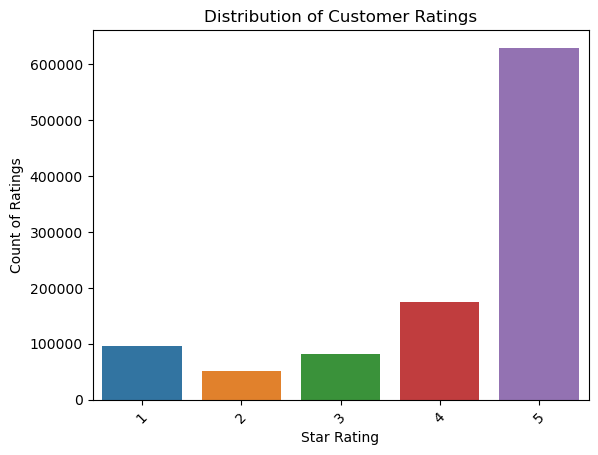

In [181]:
# who v/s fare barplot
sns.barplot(x = 'star_rating',
            y = 'count',
            data = ratingCounts)
plt.xticks(rotation=45) 
plt.xlabel("Star Rating")
plt.ylabel("Count of Ratings")
# Add a title to the plot
plt.title("Distribution of Customer Ratings")

# Show the plot
plt.show()

In [182]:
# Cast the "Year" column to integer to remove any decimal places
df2 = df2.withColumn("year", df2["year"].cast("int"))
# Group ratings by year and calculate the count of ratings
ratings_pd = df2.groupBy('year').agg(count('star_rating').alias('count')).orderBy("Year").toPandas()
ratings_pd

year   count
0   1995       3
1   1996      58
2   1997     382
3   1998    1788
4   1999    6885
5   2000   14215
6   2001   12131
7   2002   11796
8   2003   11494
9   2004   11201
10  2005   11291
11  2006    7193
12  2007   12126
13  2008   14888
14  2009   19783
15  2010   26692
16  2011   44445
17  2012   85266
18  2013  197579
19  2014  276446
20  2015  267517

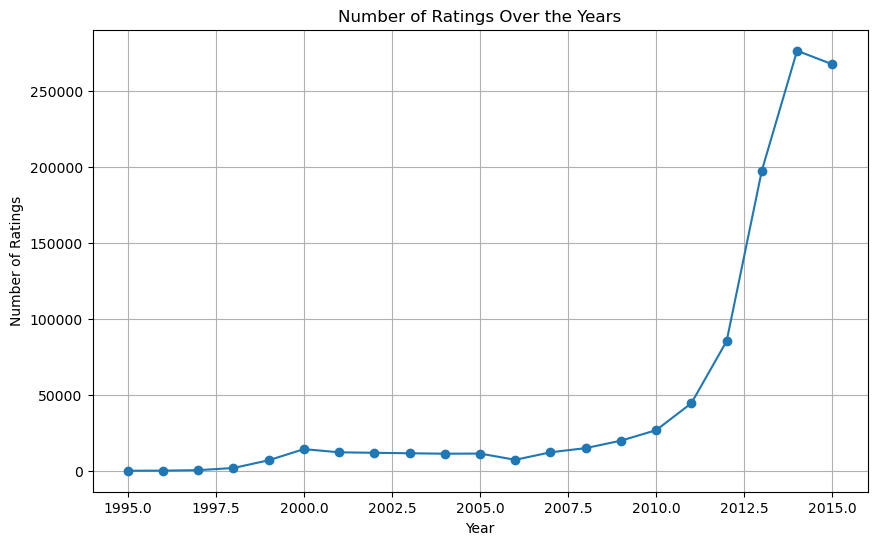

In [183]:
# Plot the line graph using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(ratings_pd["year"], ratings_pd["count"], marker='o')
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.title("Number of Ratings Over the Years")
plt.grid(True)
plt.show()

In [184]:
# Step 3: Group data and calculate distribution
grouped_df = df.groupBy('star_rating', 'sentiment').agg(count('*').alias('count'))

# Step 4: Pivot the data for visualization
pivoted_df = grouped_df.groupBy('star_rating').pivot('sentiment').sum('count').fillna(0)

# Step 5: Convert to Pandas DataFrame for visualization
pandas_df = pivoted_df.toPandas()


In [185]:
pandas_df

star_rating  negative  neutral  positive
0            1     41932    10467     43738
1            3     14594     4562     62602
2            5     27560    32826    568759
3            4     13821     7724    152841
4            2     15667     3601     32485

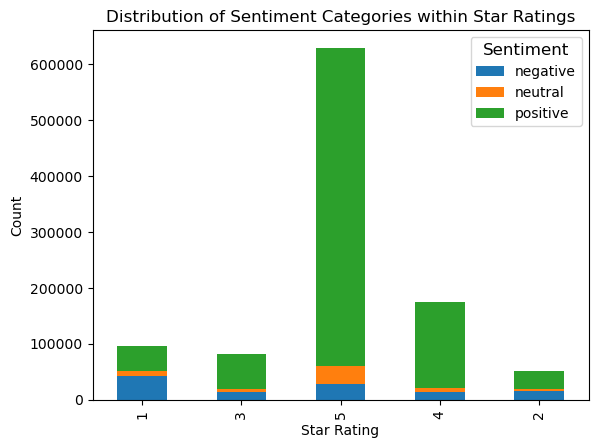

In [186]:
# Step 6: Plot the bar graph
ax = pandas_df.plot(x='star_rating', kind='bar', stacked=True)
ax.set_xlabel("Star Rating")
ax.set_ylabel("Count")
ax.set_title("Distribution of Sentiment Categories within Star Ratings")
plt.legend(title='Sentiment', title_fontsize='large')
plt.show()






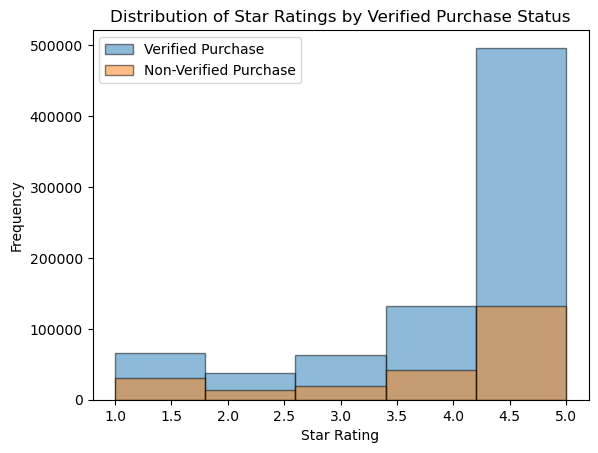

In [187]:
# Separate the star ratings for verified and non-verified purchases
verified_ratings = df2.filter(df2['verified_purchase'] == 'Y').select('star_rating').toPandas()
non_verified_ratings = df2.filter(df2['verified_purchase'] == 'N').select('star_rating').toPandas()

# Plot the distribution of star ratings for verified and non-verified purchases
plt.hist(verified_ratings, bins=5, alpha=0.5, label='Verified Purchase', edgecolor='black')
plt.hist(non_verified_ratings, bins=5, alpha=0.5, label='Non-Verified Purchase', edgecolor='black')

# Set plot labels and title
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings by Verified Purchase Status')

# Add a legend
plt.legend()

# Display the histogram
plt.show()



##### Review Analysis

In [188]:
# Step 3: Group data and calculate the count for each purchase verification status
grouped_df = df2.groupBy('verified_purchase').agg(count('*').alias('count'))

# Step 4: Convert to Pandas DataFrame for visualization
pandas_df = grouped_df.toPandas()


In [189]:
pandas_df.head()

verified_purchase   count
0                 Y  796120
1                 N  237059

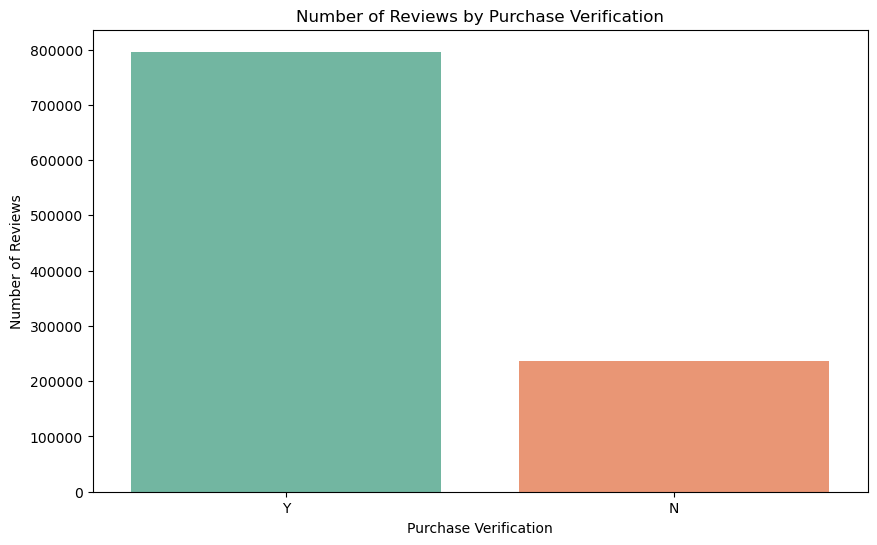

In [190]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='verified_purchase', y='count', data=pandas_df, palette='Set2')

# Set the x-axis and y-axis labels
plt.xlabel('Purchase Verification')
plt.ylabel('Number of Reviews')

# Set the title of the plot
plt.title('Number of Reviews by Purchase Verification')

# Show the plot
plt.show()

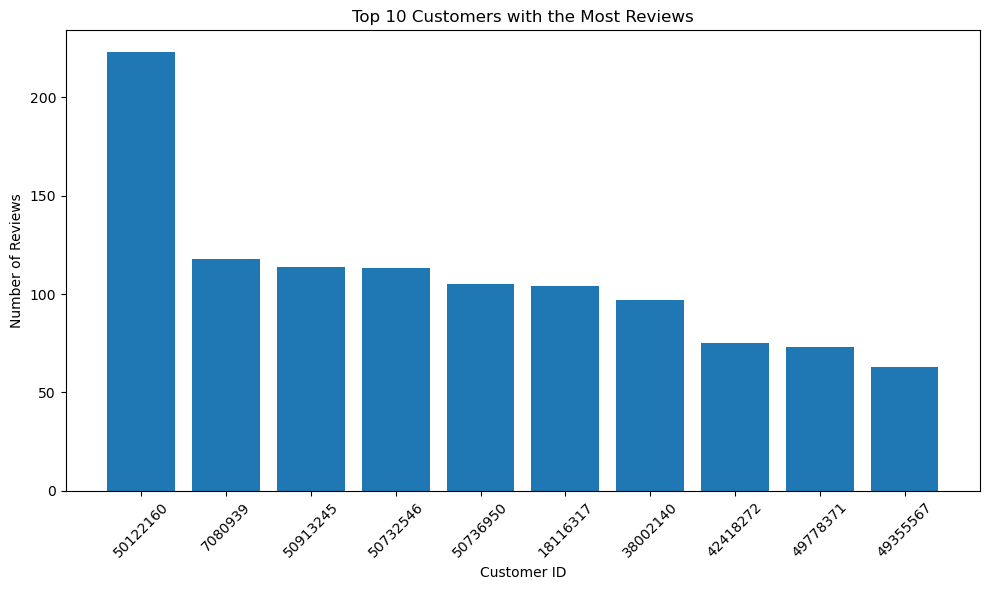

In [191]:
customer_reviews_count = df2.groupBy("customer_id").count()
sorted_customer_reviews = customer_reviews_count.orderBy(col("count").desc())
top_10_customers = sorted_customer_reviews.limit(10).toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_customers["customer_id"], top_10_customers["count"])
plt.xlabel("Customer ID")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Customers with the Most Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [192]:
category_reviews_count = df2.groupBy("product_category").count()
sorted_category_reviews = category_reviews_count.orderBy(col("count").desc())
top_10_categories = sorted_category_reviews.limit(10).toPandas()

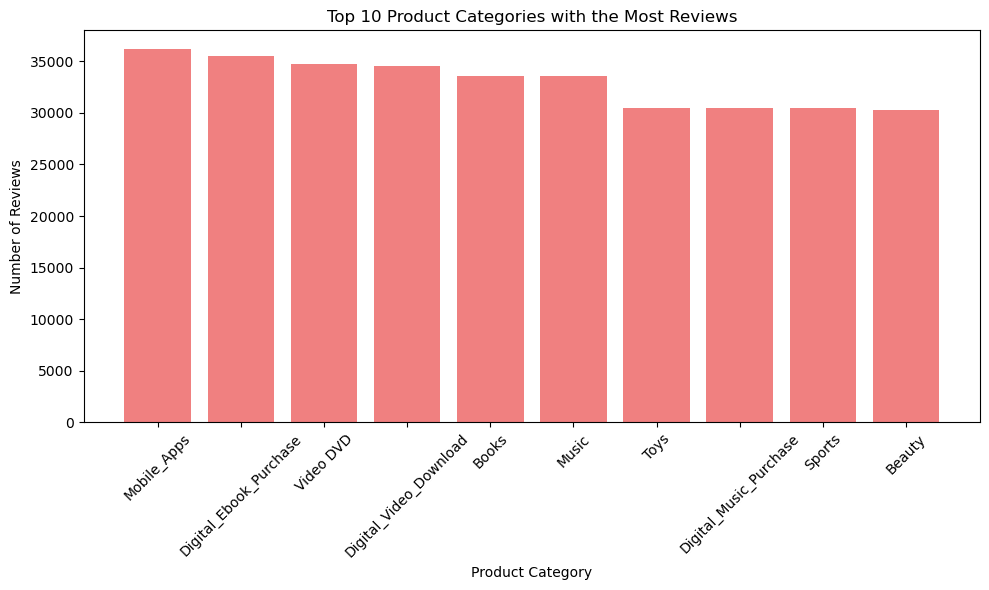

In [193]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_categories["product_category"], top_10_categories["count"], color='lightcoral')
plt.xlabel("Product Category")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Product Categories with the Most Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [194]:

helpful_unhelpful_counts = df2.agg({"helpful_votes": "sum", "unhelpful_votes": "sum"}).collect()[0]


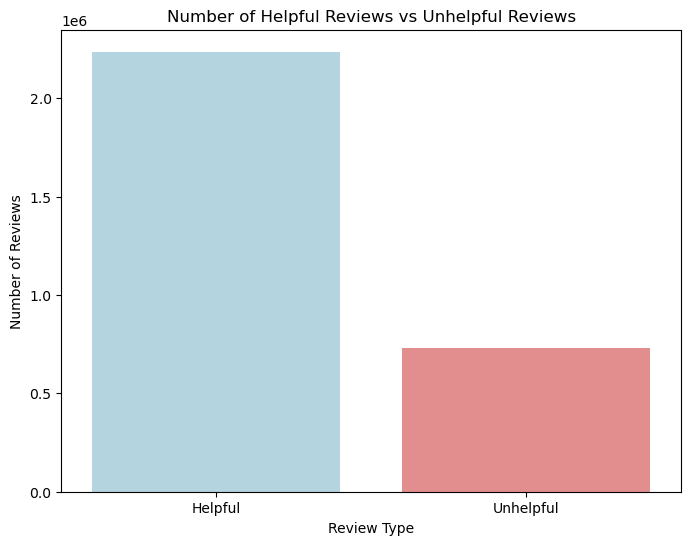

In [195]:

plt.figure(figsize=(8, 6))
sns.barplot(x=['Helpful', 'Unhelpful'], y=[helpful_unhelpful_counts['sum(helpful_votes)'], helpful_unhelpful_counts['sum(unhelpful_votes)']],
            palette=['lightblue', 'lightcoral'])


plt.xlabel('Review Type')
plt.ylabel('Number of Reviews')


plt.title('Number of Helpful Reviews vs Unhelpful Reviews')


plt.show()

In [196]:
def get_month_int(month_name):
    return month_order[month_name]

In [197]:
# Register the UDF
month_to_int_udf = udf(get_month_int, IntegerType())

In [198]:
# Create a dictionary to map month names to their corresponding numerical values
month_order = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Apply the month order mapping to the "month" column
df2 = df2.withColumn('month_int', month_to_int_udf(df2['month']))

# Group by "year" and "month", count the occurrences, and order the results
trends_df = df2.groupBy("year", "month","month_int").agg(f.count("*").alias("count")) \
               .orderBy("year", "month_int").toPandas()

In [199]:
trends_df.head()

year      month  month_int  count
0  1995       July          7      1
1  1995     August          8      1
2  1995  September          9      1
3  1996    January          1      1
4  1996        May          5      4

In [200]:
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    lines = ax.lines  # Get all lines in the plot
    legend_handles, legend_labels = ax.get_legend_handles_labels()  # Get legend handles and labels

    for i, line in enumerate(lines):
        data_x, data_y = line.get_data()
        if len(data_x)>0 and len(data_y)>0:
            first_x = data_x[0]
            first_y = data_y[0]
            year = legend_labels[i]  # Get the year from the legend labels
            color = legend_handles[i].get_color()  # Get the color from the legend handles
            ax.annotate(
                year,
                xy=(first_x, first_y),
                xytext=(5, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                color=color,
            )

/tmp/ipykernel_9862/1653417986.py:6: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax=sns.lineplot(data=trends_df, x="month", y="count", hue="year", palette=custom_palette)


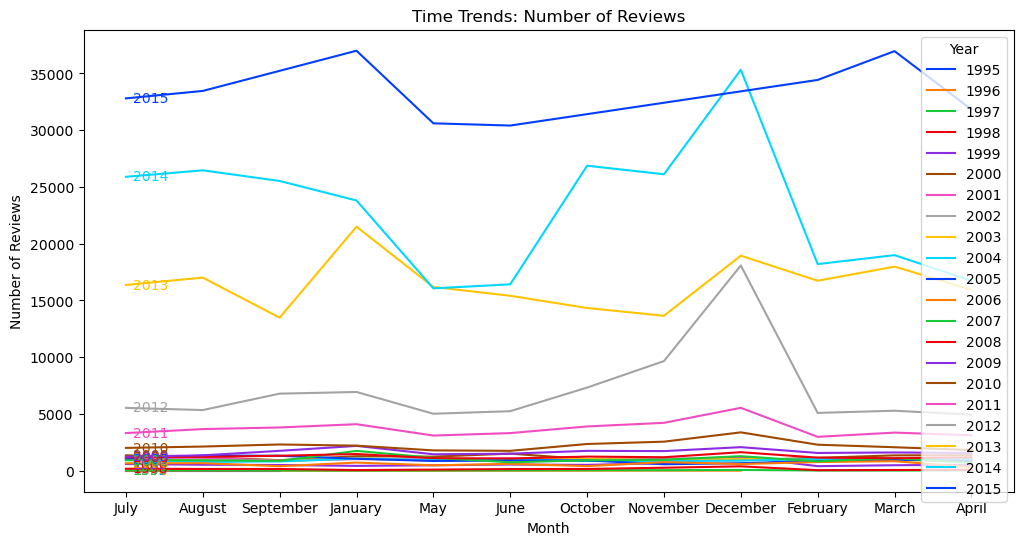

In [201]:
# Define a custom color palette with brighter colors
custom_palette = sns.color_palette("bright")

# Plot the time trends
plt.figure(figsize=(12, 6))
ax=sns.lineplot(data=trends_df, x="month", y="count", hue="year", palette=custom_palette)
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Time Trends: Number of Reviews")

improve_legend(ax)
plt.legend(title="Year")
plt.show()

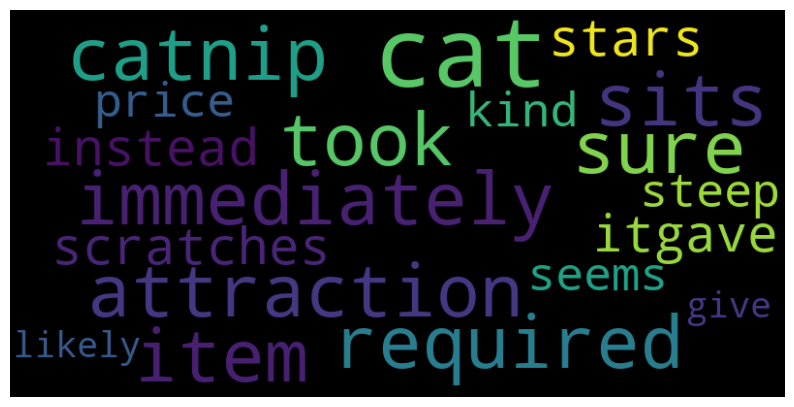

In [202]:
# Join all reviews into a single string
all_reviews = df2.select(concat_ws('', df2['review_body_clean'])).collect()[0][0]

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100).generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [203]:
def get_text_length(text):
    return len(text)

In [204]:
# Register the UDF
text_length_udf = udf(get_text_length, IntegerType())

In [205]:
# Create the new column "text_length" based on the length of the "review_body" column
#df2 = df2.withColumn('text_length', text_length_udf(df2['review_body_clean']))

In [206]:
df2.limit(1).toPandas()

23/07/30 22:07:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


customer_id      review_id  product_id  \
0    47355039  RNN25L7RWABNA  B00GBEEVC2   

                                       product_title  product_category  \
0  (2 Clips) OEM Factory Dryer Panel Clip Part Nu...  Major Appliances   

   star_rating helpful_votes total_votes vine verified_purchase  ...  year  \
0            5             0           0    N                 Y  ...  2015   

  sentiment_score sentiment  abs_sentiment_score review_text_length  \
0        0.428571  positive             0.428571                 79   

                                   review_body_clean  \
0  very happy it let me re mount the front of my ...   

                                               token  \
0  [very, happy, it, let, me, re, mount, the, fro...   

                                        stop_removed  \
0  [happy, let, re, mount, front, dryer, door, ba...   

                                              lemmas  month_int  
0  [happy, let, re, mount, front, dryer, door, ba...          6  

[1 rows x 26 columns]

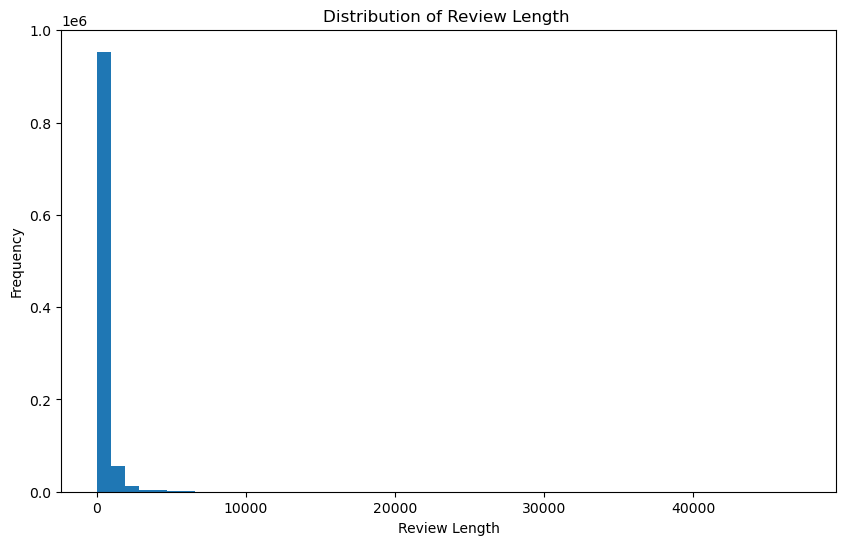

In [207]:
newdf=df2.select("review_text_length").toPandas()


# Distribution plot of text length
plt.figure(figsize=(10, 6))
plt.hist(newdf['review_text_length'], bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Length ')
plt.show()

In [208]:
# Group the data by the 'vine' column and count the number of reviews for each category
review_counts = df2.groupBy('vine').count().orderBy('vine')

In [209]:
review_counts.show()

+----+-------+
|vine|  count|
+----+-------+
|   N|1029579|
|   Y|   3600|
+----+-------+



In [210]:
newdf=review_counts.toPandas()

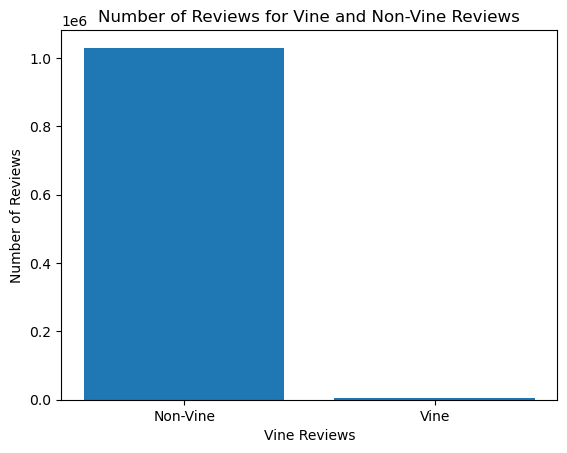

In [211]:
# Create the bar chart using matplotlib
plt.bar(newdf['vine'], newdf['count'])
plt.xlabel('Vine Reviews')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Vine and Non-Vine Reviews')
plt.xticks([0, 1], ['Non-Vine', 'Vine'])
plt.show()

In [212]:
# Group the data by "customer_id" and count the number of reviews for each customer
customer_review_counts = df2.groupBy('customer_id').agg(count('review_id').alias('review_count'))

# Calculate the average number of reviews per customer
average_reviews = customer_review_counts.select(avg('review_count')).collect()[0][0]

# Print the average number of reviews per customer
print(f"On average, each customer gives {average_reviews:.2f} reviews.")

On average, each customer gives 1.12 reviews.


#### Explore Product Issues

In [213]:
df2.limit(5).toPandas()

customer_id       review_id  product_id  \
0    49575853   R17BYV47MJ08V  B0060MYM7O   
1    49883056  R17E18VTTGRVP4  B000B7QCGS   
2    52845727  R1L8RZDSX5CTEG  B000IQ7JBO   
3    47688817  R3ITRHZK2Z8V1V  B000056BP1   
4    38307918  R1KEAZMTRBG58D  B000EHSVMS   

                                       product_title product_category  \
0  Game of Thrones: Season 2 (Blu-ray/DVD Combo +...        Video DVD   
1  Superman: The Animated Series, Volume 2 (DC Co...        Video DVD   
2  2 DVD Atomic Bomb Fallout & Radiation Films: D...        Video DVD   
3                     Twin Peaks - Fire Walk with Me        Video DVD   
4  Buffy the Vampire Slayer  - The Complete Sixth...        Video DVD   

   star_rating helpful_votes total_votes vine verified_purchase  ...  year  \
0            5             0           0    N                 Y  ...  2013   
1            4            10          12    N                 N  ...  2005   
2            5             0           0    N                 Y  ...  2013   
3            4             1           1    N                 N  ...  2015   
4            4             0           1    N                 N  ...  2009   

  sentiment_score sentiment  abs_sentiment_score review_text_length  \
0        0.750000  positive             0.750000                114   
1        0.166497  positive             0.166497               1629   
2        0.046624  positive             0.046624               2968   
3        0.104167  positive             0.104167                760   
4        0.800000  positive             0.800000                183   

                                   review_body_clean  \
0  good price for a great season i bought this is...   
1  superman the animated series vol 2 packs in an...   
2  the two dvds have over 3 hours of history from...   
3  for a full description of the plot etc read ot...   
4  the shipping estimate was great arrived on tim...   

                                               token  \
0  [good, price, for, a, great, season, i, bought...   
1  [superman, the, animated, series, vol, 2, pack...   
2  [the, two, dvds, have, over, 3, hours, of, his...   
3  [for, a, full, description, of, the, plot, etc...   
4  [the, shipping, estimate, was, great, arrived,...   

                                        stop_removed  \
0  [good, price, great, season, bought, gift, fri...   
1  [superman, animated, series, vol, 2, packs, an...   
2  [two, dvds, 3, hours, history, films, made, pu...   
3  [full, description, plot, etc, read, reviews, ...   
4  [shipping, estimate, great, arrived, time, gre...   

                                              lemmas  month_int  
0  [good, price, great, season, bought, gift, fri...          5  
1  [superman, animated, series, vol, 2, pack, ano...          9  
2  [two, dvd, 3, hour, history, film, made, publi...          2  
3  [full, description, plot, etc, read, review, q...          4  
4  [shipping, estimate, great, arrived, time, gre...          2  

[5 rows x 26 columns]

In [214]:
df2.columns

['customer_id',
 'review_id',
 'product_id',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date',
 'unhelpful_votes',
 'season',
 'month',
 'year',
 'sentiment_score',
 'sentiment',
 'abs_sentiment_score',
 'review_text_length',
 'review_body_clean',
 'token',
 'stop_removed',
 'lemmas',
 'month_int']

In [149]:
negativeReviews=df2.filter(col("sentiment")=="negative")

In [150]:
negativeReviews.limit(5).toPandas()

customer_id       review_id  product_id  \
0    41678288  R3KIKBHKXPYRB8  B0027CU1DA   
1    23614969  R2Z9KP9RI4I444  B00LE99PA2   
2    25793727   RNWJK8JU22CTH  B00O3ILN5G   
3    42389514   RG0JYFVLEP3O0  B0031JK96C   
4     7811877  R2WEEA942SUHQP  B00381AV1Q   

                                       product_title        product_category  \
0                               Caldera Therapy Wrap  Health & Personal Care   
1            Amopé Pedi Perfect Electronic Foot File  Health & Personal Care   
2  The 2 Bits Man The Natural Man Beard Oil - Uns...  Health & Personal Care   
3  Garden of Life Organic Vegan Protein Powder wi...  Health & Personal Care   
4                    U by Kotex Barely There* Liners  Health & Personal Care   

   star_rating helpful_votes total_votes vine verified_purchase  ...    month  \
0            3             0           0    N                 Y  ...     July   
1            2             0           0    N                 Y  ...      May   
2            4             0           0    N                 N  ...    March   
3            2             0           0    N                 Y  ...  October   
4            5             0           0    N                 Y  ...    March   

   year sentiment_score  sentiment abs_sentiment_score review_text_length  \
0  2015       -0.600000   negative            0.600000                147   
1  2015       -0.150000   negative            0.150000                 20   
2  2015       -0.009375   negative            0.009375                183   
3  2014       -0.137755   negative            0.137755                449   
4  2015       -0.005556   negative            0.005556                 83   

                                   review_body_clean  \
0  freezes well and quite liquidous still stays c...   
1                                not worth the money   
2  having tried a lot of beard oil i must say thi...   
3  i dont know how else to put it this tastes lik...   
4  i keep buying these over and over they are sup...   

                                               token  \
0  [freezes, well, and, quite, liquidous, still, ...   
1                           [not, worth, the, money]   
2  [having, tried, a, lot, of, beard, oil, i, mus...   
3  [i, dont, know, how, else, to, put, it, this, ...   
4  [i, keep, buying, these, over, and, over, they...   

                                        stop_removed  \
0  [freezes, well, quite, liquidous, still, stays...   
1                                     [worth, money]   
2  [tried, lot, beard, oil, must, say, pretty, so...   
3  [dont, know, else, put, tastes, like, feet, ad...   
4          [keep, buying, super, thin, barely, feel]   

                                              lemmas  
0  [freeze, well, quite, liquidous, still, stay, ...  
1                                     [worth, money]  
2  [tried, lot, beard, oil, must, say, pretty, so...  
3  [dont, know, else, put, taste, like, foot, add...  
4          [keep, buying, super, thin, barely, feel]  

[5 rows x 25 columns]

In [151]:
negativeReviewsDF = negativeReviews.select("lemmas").toPandas()

In [152]:
neg_tokens = [token for sublist in negativeReviewsDF["lemmas"] for token in sublist]

In [153]:
len(neg_tokens)

3337550

In [154]:
n = 2  
bigrams =list(nltk.ngrams(neg_tokens, n))

In [155]:
freq_dist = nltk.FreqDist(bigrams)

In [156]:
# Get the first 10 N-grams for spam sorted by frequency in descending order
topbigrams = dict(sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:20])

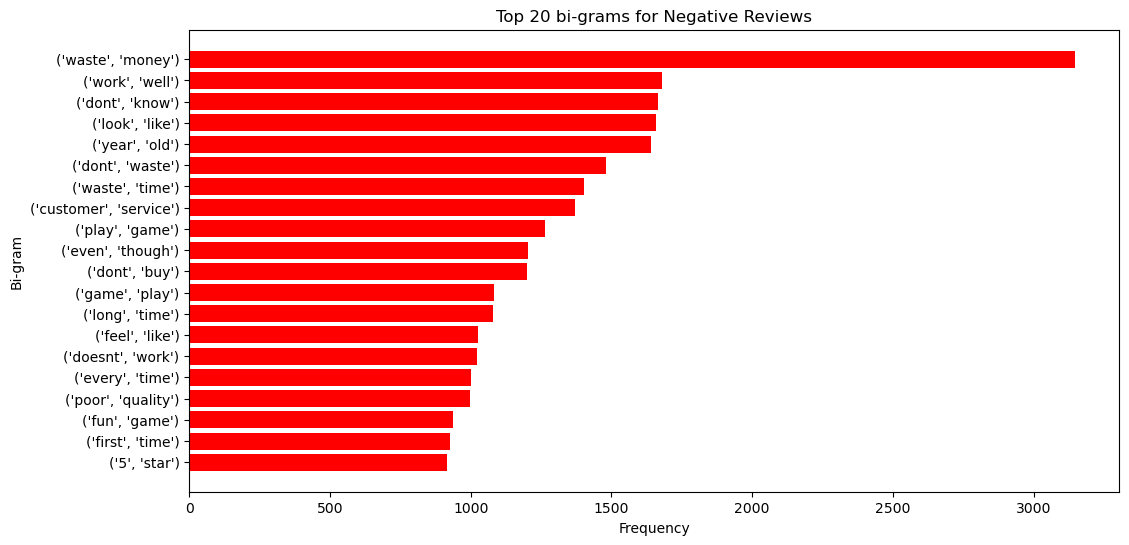

In [157]:
# Plot the first 10 N-grams for spam using horizontal bar chart (barh) with reversed order
plt.figure(figsize=(12, 6))
plt.barh(range(len(topbigrams)), list(topbigrams.values())[::-1], align='center',color="red")
plt.yticks(range(len(topbigrams)), list(topbigrams.keys())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Bi-gram")
plt.title("Top 20 bi-grams for Negative Reviews")


plt.show()

In [158]:
n = 3  
trigrams =list(nltk.ngrams(neg_tokens, n))

In [159]:
freq_dist2 = nltk.FreqDist(trigrams)

In [160]:
# Get the first 10 N-grams for spam sorted by frequency in descending order
toptrigrams = dict(sorted(freq_dist2.items(), key=lambda x: x[1], reverse=True)[:20])

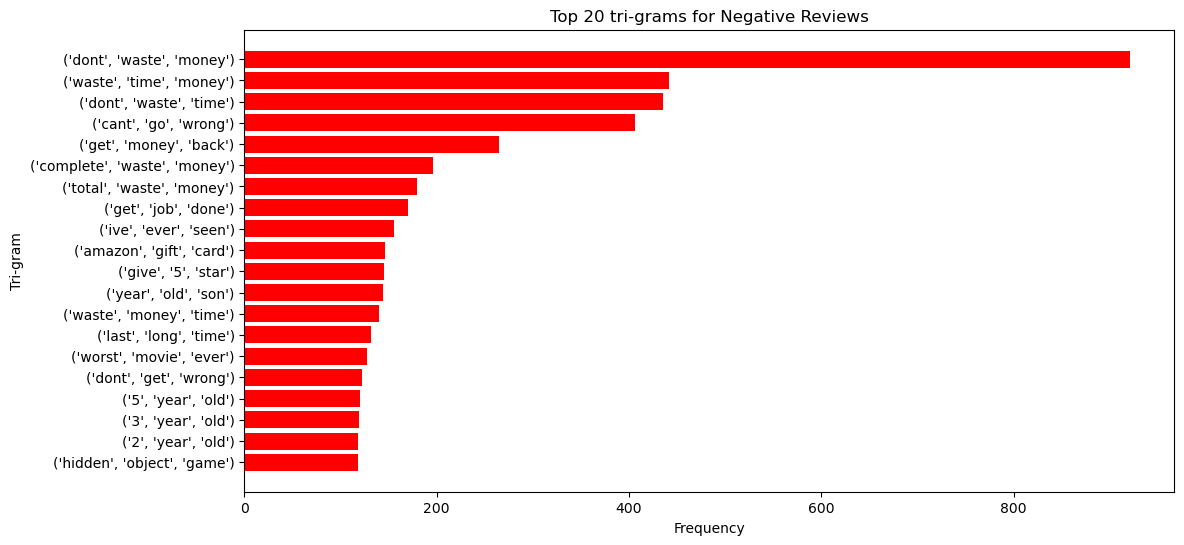

In [161]:
# Plot the first 10 N-grams for spam using horizontal bar chart (barh) with reversed order
plt.figure(figsize=(12, 6))
plt.barh(range(len(toptrigrams)), list(toptrigrams.values())[::-1], align='center',color="red")
plt.yticks(range(len(toptrigrams)), list(toptrigrams.keys())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Tri-gram")
plt.title("Top 20 tri-grams for Negative Reviews")


plt.show()

#### Negative Reviews for ratings less than 3 stars

In [162]:
negativeReviewsDFLowRating = negativeReviews.filter(col("star_rating")<3).select("lemmas").toPandas()

In [163]:
negativeReviewsDFLowRating.head()

lemmas
0  [impossible, roll, hair, hair, get, tangled, p...
1  [disappointed, product, separation, ive, never...
2                            [box, sealed, le, 50ml]
3  [product, desperate, desperate, need, major, o...
4  [way, 1, inch, thickmaybe, 12, inch, seems, si...

In [164]:
neg_tokens_lowRating = [token for sublist in negativeReviewsDFLowRating["lemmas"] for token in sublist]

In [165]:
len(neg_tokens_lowRating)

1796643

In [166]:
n = 2 
bigrams =list(nltk.ngrams(neg_tokens_lowRating, n))

In [167]:
freq_dist = nltk.FreqDist(bigrams)

In [168]:
# Get the first 10 N-grams for spam sorted by frequency in descending order
topbigrams = dict(sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:20])

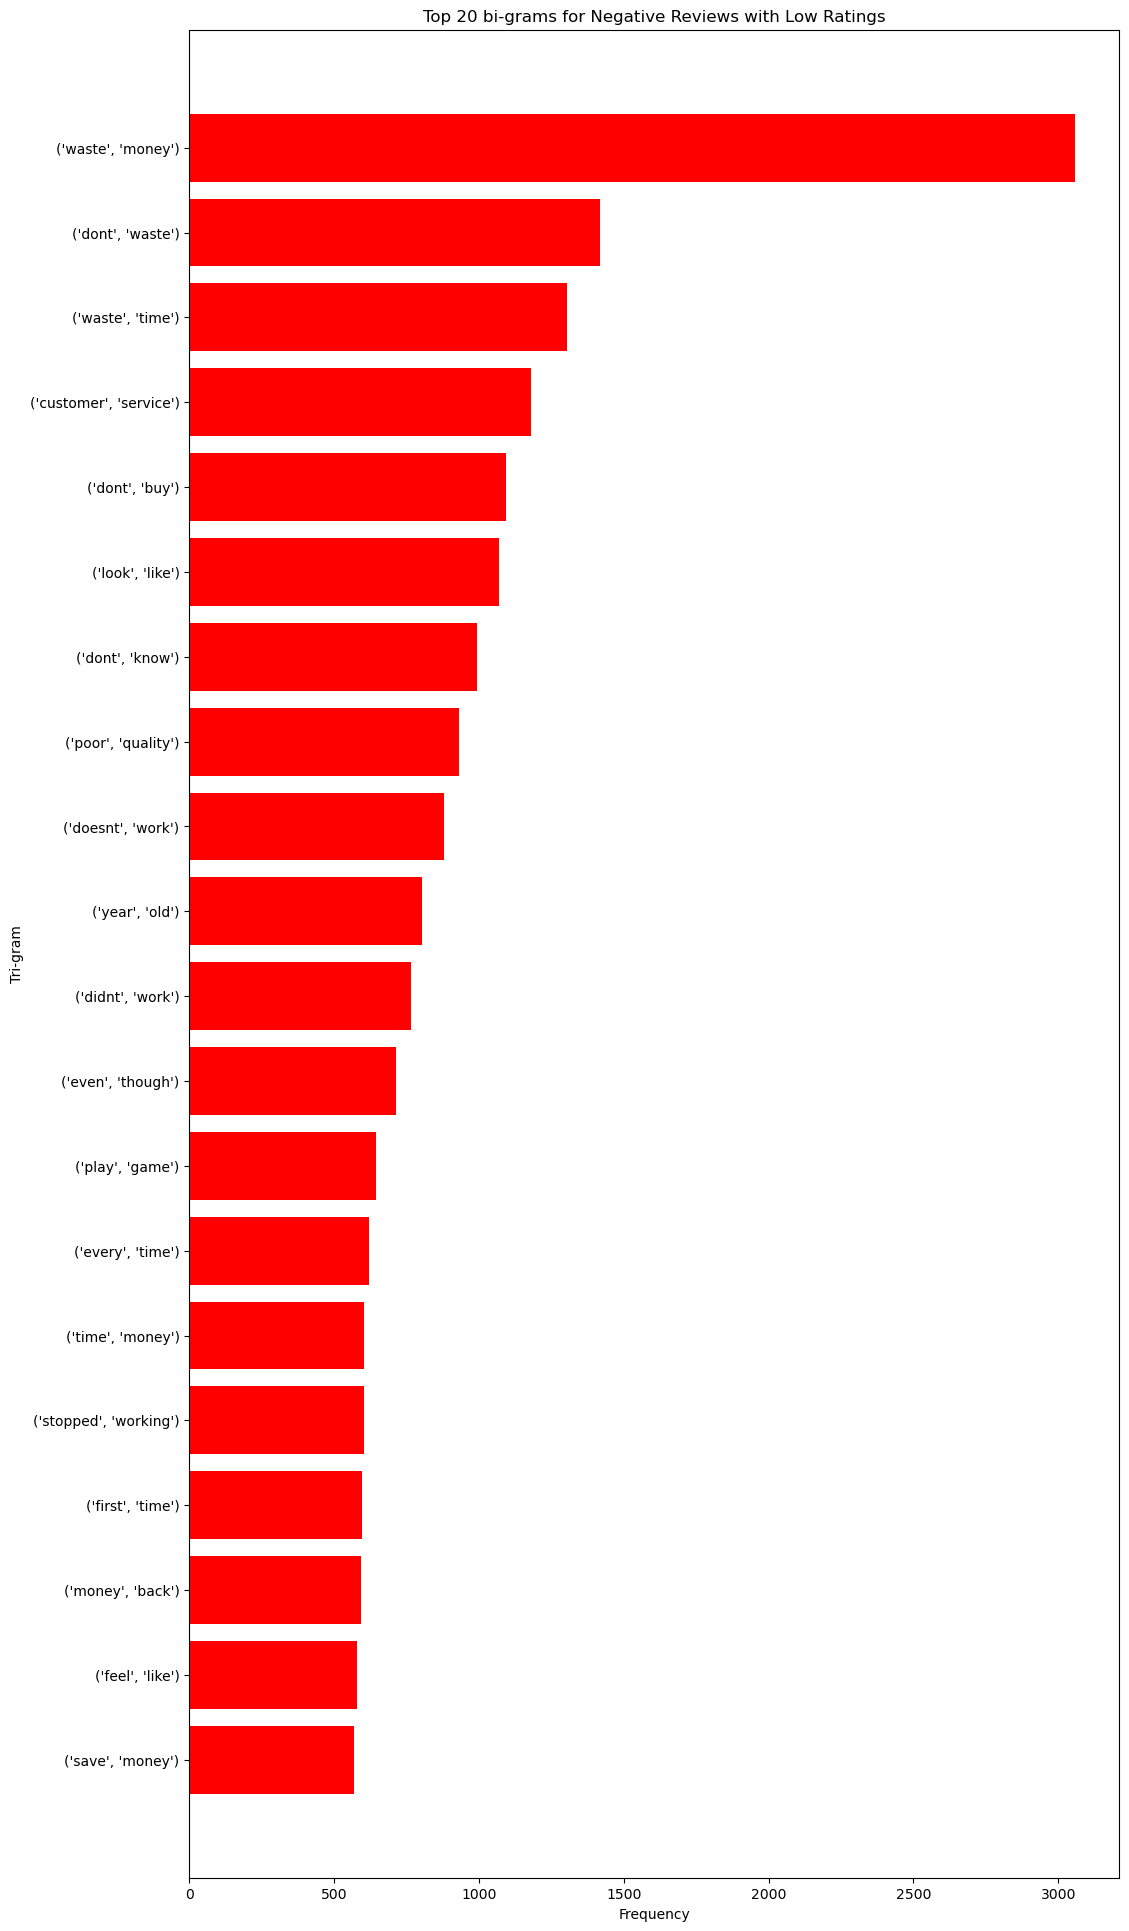

In [169]:
# Plot the first 10 N-grams for spam using horizontal bar chart (barh) with reversed order
plt.figure(figsize=(12, 24))
plt.barh(range(len(topbigrams)), list(topbigrams.values())[::-1], align='center',color="red")
plt.yticks(range(len(topbigrams)), list(topbigrams.keys())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Tri-gram")
plt.title("Top 20 bi-grams for Negative Reviews with Low Ratings")


plt.show()

In [170]:
n = 3
trigrams =list(nltk.ngrams(neg_tokens_lowRating, n))

In [171]:
freq_dist = nltk.FreqDist(trigrams)

In [172]:
# Get the first 10 N-grams for spam sorted by frequency in descending order
toptrigrams = dict(sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:20])

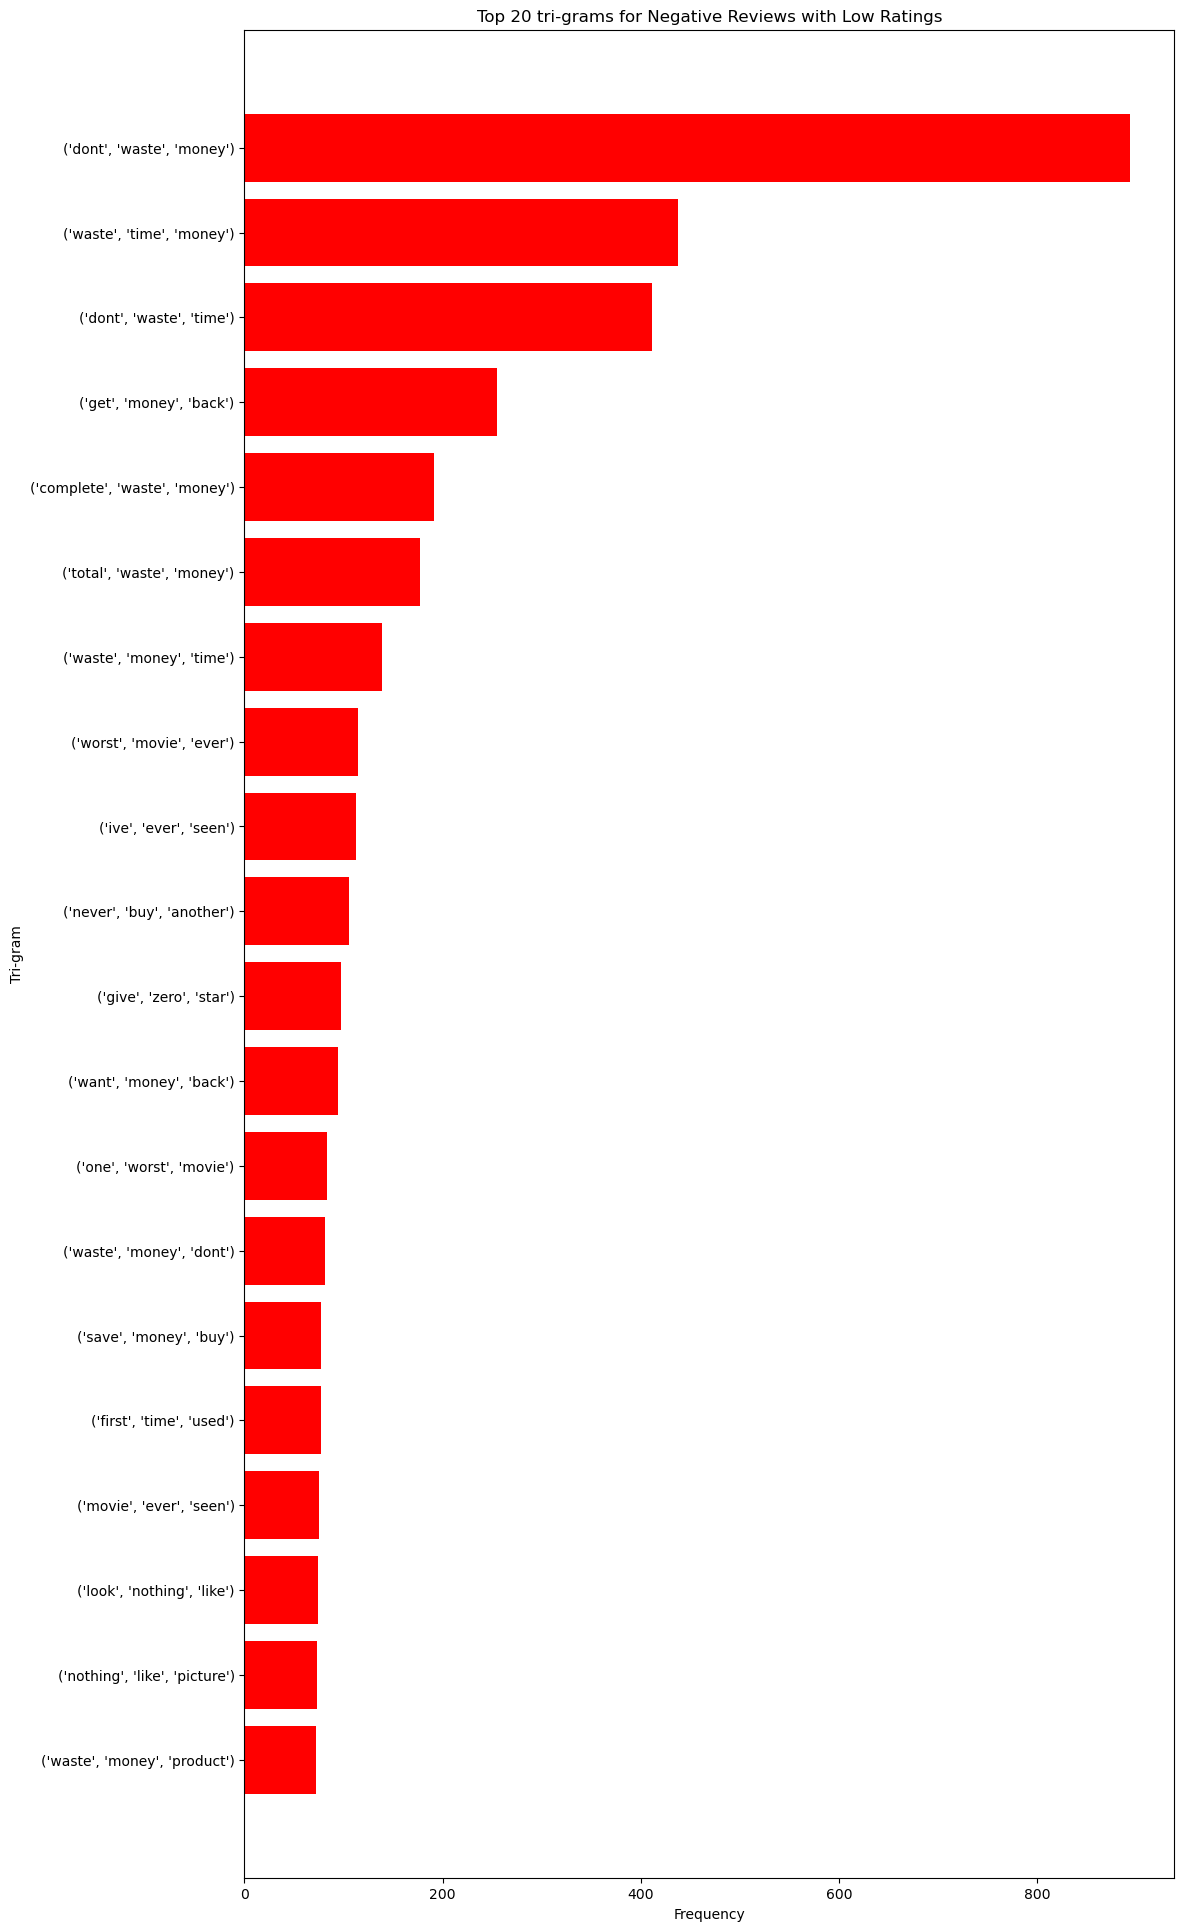

In [173]:
# Plot the first 10 N-grams for spam using horizontal bar chart (barh) with reversed order
plt.figure(figsize=(12, 24))
plt.barh(range(len(toptrigrams)), list(toptrigrams.values())[::-1], align='center',color="red")
plt.yticks(range(len(toptrigrams)), list(toptrigrams.keys())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Tri-gram")
plt.title("Top 20 tri-grams for Negative Reviews with Low Ratings")


plt.show()

#### identify fake or manipulated reviews

In [148]:
reviewsDF=spam_df.select("review_text_length","labels","sentiment_score","sentiment","class").toPandas()

Text(0.5, 1.0, 'Distribution of Review Text Length')

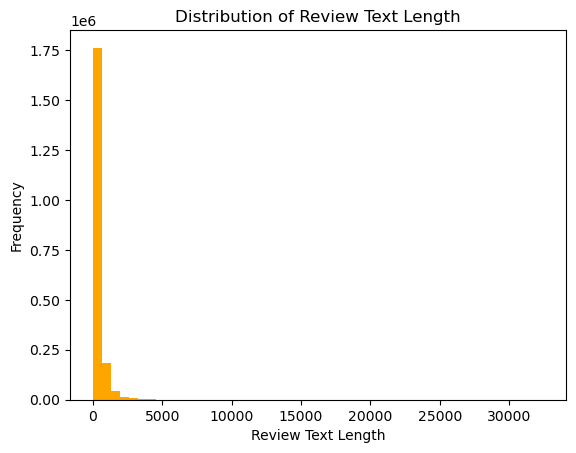

In [149]:
reviewsDF["review_text_length"].plot(bins=50,kind='hist',color='orange')

# Set axis labels and title
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Text Length')

In [150]:
# Filter the DataFrame for 'ham' and 'spam' labels

ham = reviewsDF[reviewsDF["labels"]=="ham"]
spam = reviewsDF[reviewsDF["labels"]=="spam"]

In [151]:
ham["labels"].value_counts()

ham    449086
Name: labels, dtype: int64

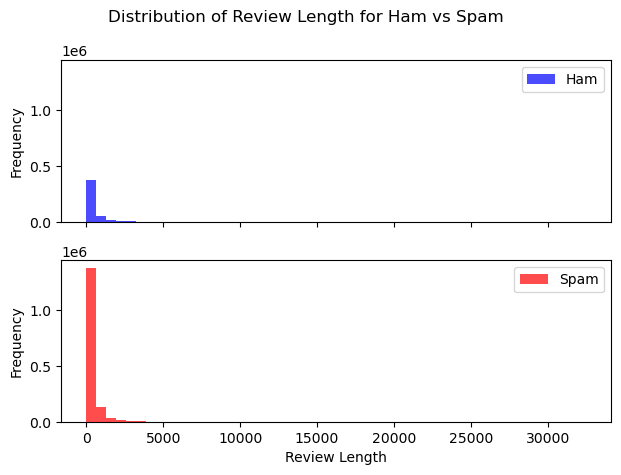

In [152]:
# Generate separate histograms for 'ham' and 'spam' subsets
fig, axes = plt.subplots(2, sharex=True, sharey=True)
ham["review_text_length"].plot(kind="hist", bins=50, ax=axes[0], color="blue", alpha=0.7)
spam["review_text_length"].plot(kind="hist", bins=50, ax=axes[1], color="red", alpha=0.7)

# Set axis labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Review Length for Ham vs Spam')

# Add legend
axes[0].legend(["Ham"])
axes[1].legend(["Spam"])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [153]:
# Extract the correlations

correlation_matrix = reviewsDF[["class", "review_text_length", "sentiment_score"]].corr()
correlation_length = correlation_matrix.loc["class", "review_text_length"]
correlation_sentiment = correlation_matrix.loc["class", "sentiment_score"]

print("Correlation between review length and labels:", correlation_length)
print("Correlation between sentiment and labels:", correlation_sentiment)

Correlation between review length and labels: -0.046593058051991196
Correlation between sentiment and labels: 0.39430603119074614


In [154]:
reviewDF=spam_df[["labels","reviewDate","review_text_length","sentiment"]].toPandas()

In [155]:
reviewDF.head()

labels  reviewDate  review_text_length sentiment
0   spam  2014-01-30                 338  positive
1   spam  2013-12-29                 145  positive
2    ham  2014-01-18                 238  negative
3   spam  2013-03-11                 148  positive
4   spam  2014-06-14                 140  positive

In [156]:
reviewDF.dtypes

labels                object
reviewDate            object
review_text_length     int32
sentiment             object
dtype: object

In [157]:
reviewDF["reviewDate"]=pd.to_datetime(reviewDF['reviewDate'])

In [158]:
reviewDF.head()

labels reviewDate  review_text_length sentiment
0   spam 2014-01-30                 338  positive
1   spam 2013-12-29                 145  positive
2    ham 2014-01-18                 238  negative
3   spam 2013-03-11                 148  positive
4   spam 2014-06-14                 140  positive

In [159]:
reviewDF.dtypes

labels                        object
reviewDate            datetime64[ns]
review_text_length             int32
sentiment                     object
dtype: object

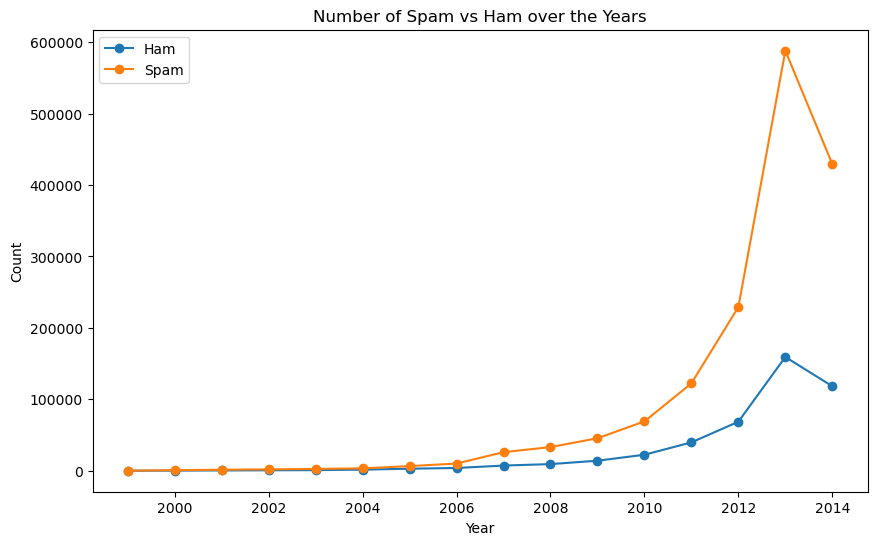

In [160]:
grouped_df = reviewDF.groupby([reviewDF['reviewDate'].dt.year, 'labels']).size().unstack().fillna(0)
# Plot the number of spam vs ham over the years
ax = grouped_df.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Spam vs Ham over the Years')

# Set legend
ax.legend(['Ham', 'Spam'])

# Show the plot
plt.show()

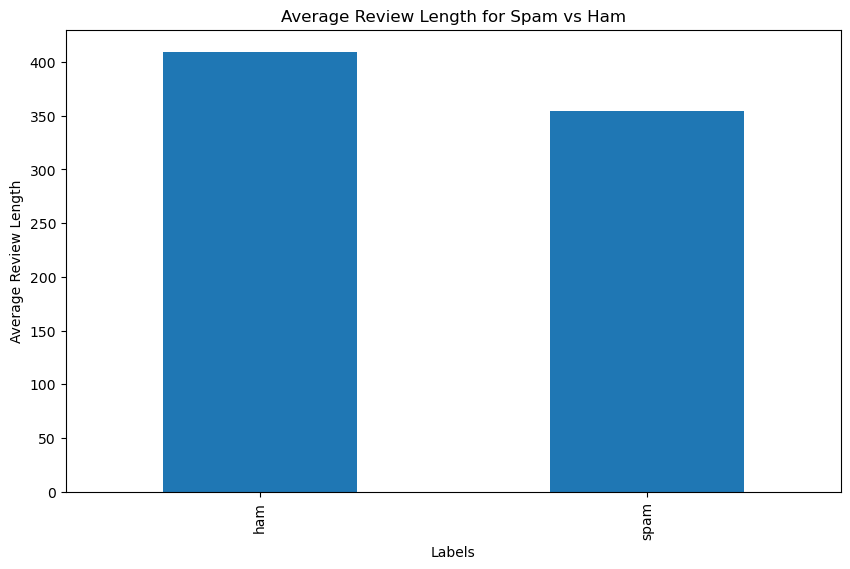

In [161]:
# Group the DataFrame by 'labels' and calculate the mean review length for each category
grouped_df = reviewDF.groupby('labels')['review_text_length'].mean()

# Plot the spam vs ham review length
ax = grouped_df.plot(kind='bar', figsize=(10, 6))

# Set labels and title
plt.xlabel('Labels')
plt.ylabel('Average Review Length')
plt.title('Average Review Length for Spam vs Ham')

# Show the plot
plt.show()

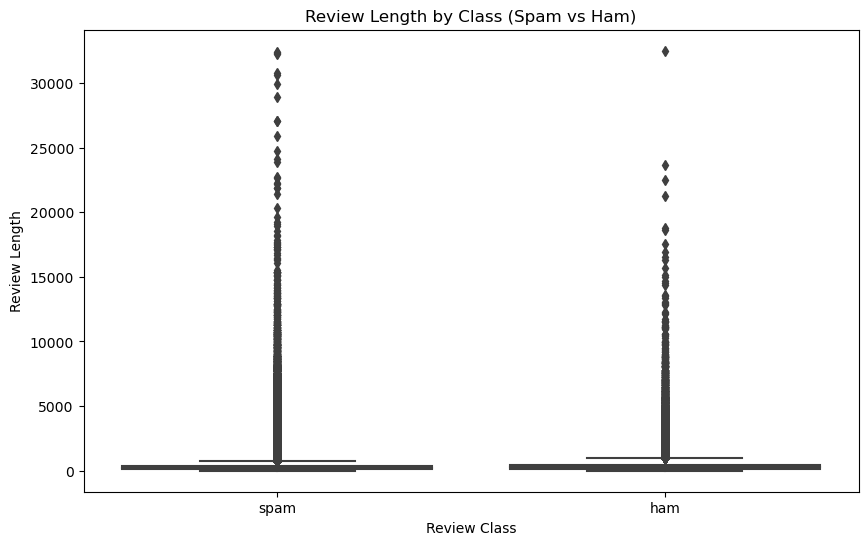

In [162]:
# Plot the review length by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='labels', y='review_text_length', data=reviewDF)

# Set labels and title
plt.xlabel('Review Class')
plt.ylabel('Review Length')
plt.title('Review Length by Class (Spam vs Ham)')

# Show the plot
plt.show()

In [163]:
reviewDF.head()

labels reviewDate  review_text_length sentiment
0   spam 2014-01-30                 338  positive
1   spam 2013-12-29                 145  positive
2    ham 2014-01-18                 238  negative
3   spam 2013-03-11                 148  positive
4   spam 2014-06-14                 140  positive

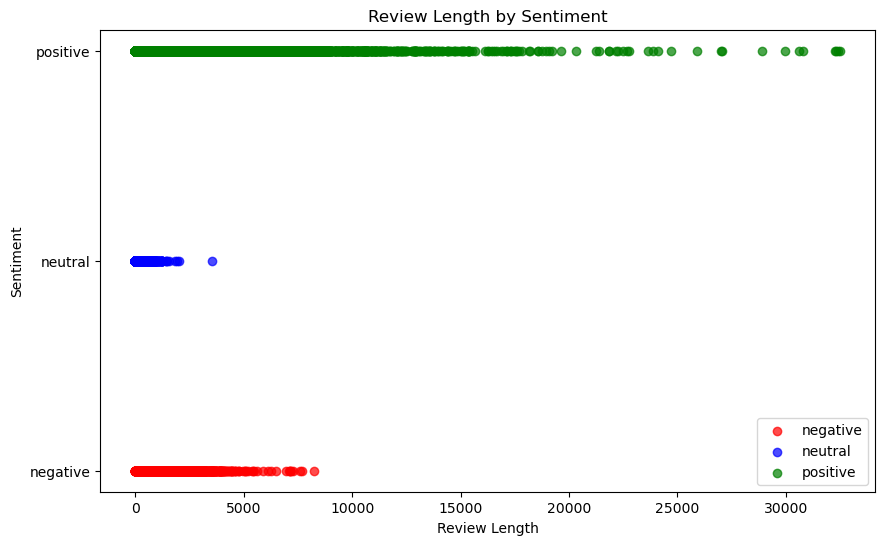

In [164]:
# Plot the review length by sentiment
plt.figure(figsize=(10, 6))
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
for sentiment, data in reviewDF.groupby('sentiment'):
    plt.scatter(data['review_text_length'], [sentiment] * len(data), color=colors[sentiment], label=sentiment, alpha=0.7)

# Set labels and title
plt.xlabel('Review Length')
plt.ylabel('Sentiment')
plt.title('Review Length by Sentiment')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### Word Cloud

In [148]:
spam_df=spam_df.withColumn("concatenated_lemmas", concat_ws(" ", col("lemmas")))

In [149]:
spam_df.limit(1).toPandas()

class                                         reviewText  reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...  04 5, 2011   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011            0.385   

  sentiment  abs_sentiment_score  review_text_length labels  \
0  positive                0.385                 361    ham   

                                    reviewText_clean  \
0  i ordered this vehicle charger on the amazon w...   

                                               token  \
0  [i, ordered, this, vehicle, charger, on, the, ...   

                                        stop_removed  \
0  [ordered, vehicle, charger, amazon, web, site,...   

                                              lemmas  \
0  [ordered, vehicle, charger, amazon, web, site,...   

                                 concatenated_lemmas  
0  ordered vehicle charger amazon web site i335 m...

In [150]:
spam=spam_df.filter(spam_df.labels == "spam")

In [151]:
ham=spam_df.filter(spam_df.labels == "ham")

In [152]:
spam_reviews=spam.select(spam.concatenated_lemmas).rdd.flatMap(lambda x: x).collect()

In [153]:
len(spam_reviews)

1568912

In [154]:
spam_reviews[:2]

['great headphone price stay ear run nice loud great sound great purchase happy also great kid people small ear dont like jamming something ear canal',
 'im fan trackball mxico difficult get one finally made throught amazon great confortable adjust hand ball left adjust finger press button im satisfied muy purchase']

In [155]:
# Convert sentences to a list of words
words_list = [sentence.split() for sentence in spam_reviews]

In [156]:
spam_reviews=[word for sentence in words_list for word in sentence]

In [157]:
spam_reviews[:5]

['great', 'headphone', 'price', 'stay', 'ear']

In [158]:
len(spam_reviews)

52283794

In [159]:
ham_reviews=ham.select(ham.concatenated_lemmas).rdd.flatMap(lambda x: x).collect()

In [160]:
# Convert sentences to a list of words
words_list = [sentence.split() for sentence in ham_reviews]

In [161]:
ham_reviews=[word for sentence in words_list for word in sentence]

In [162]:
# Count the occurrences of each word
spam_word_counts = Counter(spam_reviews)

In [163]:
# Count the occurrences of each word
ham_word_counts = Counter(ham_reviews)

In [164]:
# Select the top 20 words with highest frequencies
spam_top_words = dict(spam_word_counts.most_common(20))

In [165]:
# Select the top 20 words with highest frequencies
ham_top_words = dict(ham_word_counts.most_common(20))

In [166]:
spam_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(spam_top_words)
ham_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(ham_top_words)

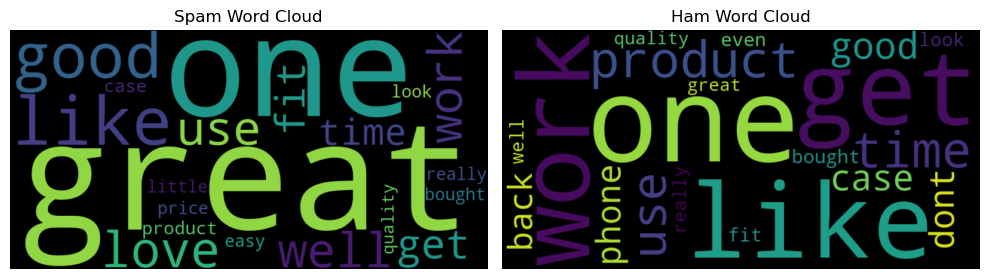

In [167]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.title("Spam Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.title("Ham Word Cloud")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Bi-grams

In [168]:
ngram = NGram(n=2, inputCol="lemmas", outputCol="ngrams")
ham = ngram.transform(ham)

In [169]:
ngram = NGram(n=2, inputCol="lemmas", outputCol="ngrams")
spam = ngram.transform(spam)

In [170]:
ngram_spam_count = spam.groupBy("ngrams").count().orderBy(col("count").desc())

In [171]:
ngram_ham_count = ham.groupBy("ngrams").count().orderBy(col("count").desc())

In [172]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
ngram_count_pd = ngram_spam_count.limit(20).toPandas()

In [173]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
ngram_count_pd_ham = ngram_ham_count.limit(20).toPandas()

In [174]:
spam_ngrams = ngram_count_pd["ngrams"]
spam_frequencies = ngram_count_pd["count"]

In [175]:
ham_ngrams = ngram_count_pd_ham["ngrams"]
ham_frequencies = ngram_count_pd_ham["count"]

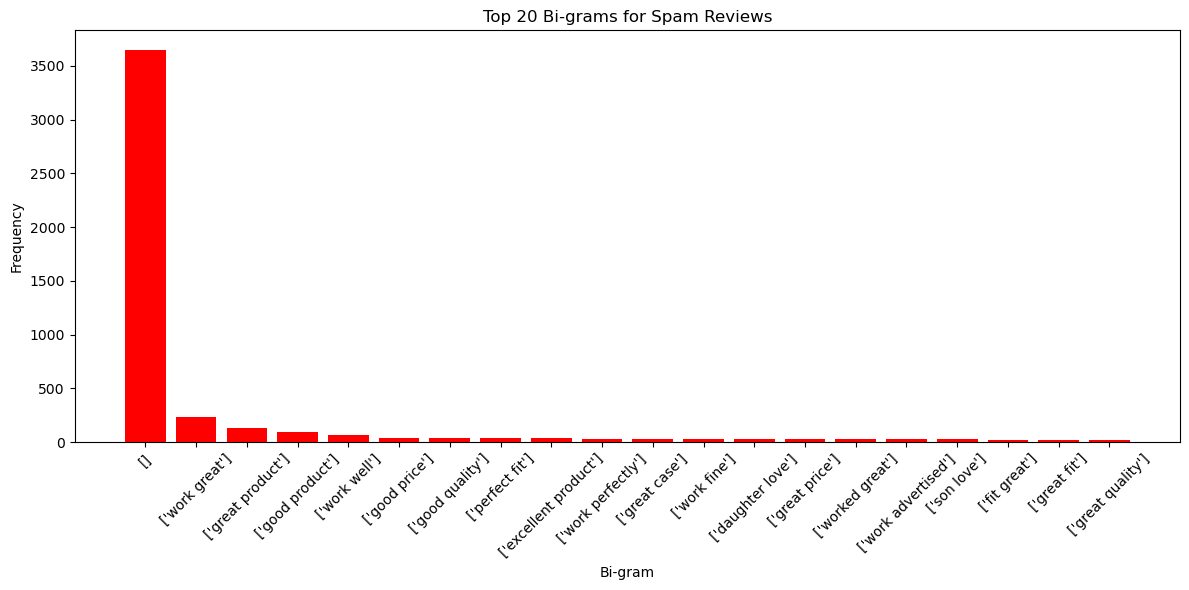

In [176]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(spam_ngrams)), spam_frequencies, align='center',color="red")
plt.xticks(range(len(spam_ngrams)), spam_ngrams, rotation=45)
plt.xlabel(f"Bi-gram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Bi-grams for Spam Reviews")
plt.tight_layout()
plt.show()

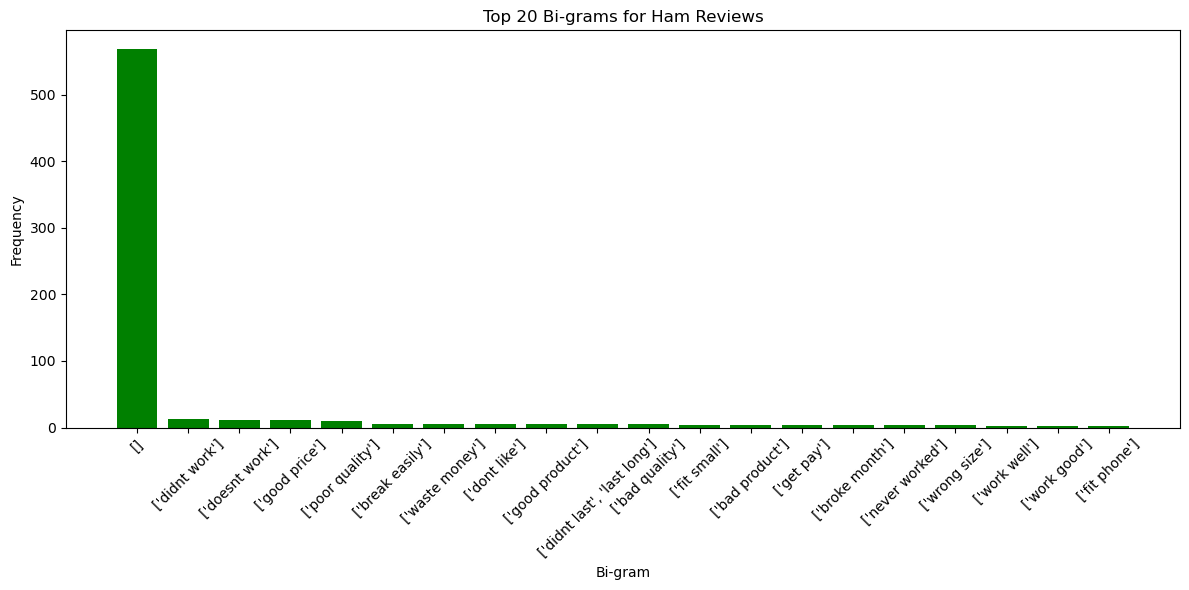

In [177]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(ham_ngrams)), ham_frequencies, align='center',color="green")
plt.xticks(range(len(ham_ngrams)), ham_ngrams, rotation=45)
plt.xlabel(f"Bi-gram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Bi-grams for Ham Reviews")
plt.tight_layout()
plt.show()

#### Trigram

In [178]:
ngram = NGram(n=3, inputCol="lemmas", outputCol="trigrams")
ham = ngram.transform(ham)

In [179]:
ngram = NGram(n=3, inputCol="lemmas", outputCol="trigrams")
spam = ngram.transform(spam)

In [180]:
ngram_spam_count = spam.groupBy("trigrams").count().orderBy(col("count").desc())
ngram_ham_count = ham.groupBy("trigrams").count().orderBy(col("count").desc())


In [181]:
ngram_count_pd_ham = ngram_ham_count.limit(20).toPandas()

# Convert the DataFrame to a Pandas DataFrame for easy plotting
ngram_count_pd = ngram_spam_count.limit(20).toPandas()

In [182]:
spam_ngrams = ngram_count_pd["trigrams"]
spam_frequencies = ngram_count_pd["count"]

In [183]:
ham_ngrams = ngram_count_pd_ham["trigrams"]
ham_frequencies = ngram_count_pd_ham["count"]

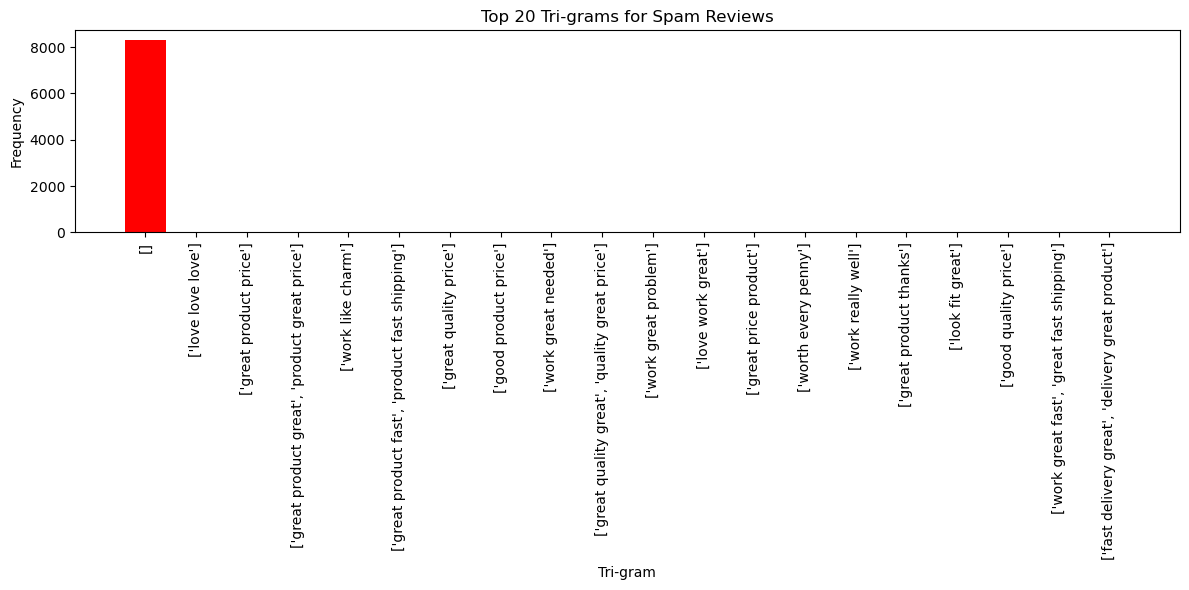

In [194]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(spam_ngrams)), spam_frequencies, align='center',color="red")
plt.xticks(range(len(spam_ngrams)), spam_ngrams, rotation=90)
plt.xlabel(f"Tri-gram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Tri-grams for Spam Reviews")
plt.tight_layout()
plt.show()

In [188]:
ham_ngrams.head()

0                    []
1     [didnt last long]
2     [broke first use]
3    [fell apart month]
4     [didnt fit phone]
Name: trigrams, dtype: object

In [197]:
spam_ngrams

0                                                []
1                                  [love love love]
2                             [great product price]
3        [great product great, product great price]
4                                 [work like charm]
5       [great product fast, product fast shipping]
6                             [great quality price]
7                              [good product price]
8                               [work great needed]
9        [great quality great, quality great price]
10                             [work great problem]
11                                [love work great]
12                            [great price product]
13                              [worth every penny]
14                               [work really well]
15                           [great product thanks]
16                                 [look fit great]
17                             [good quality price]
18           [work great fast, great fast shipping]
19    [fast 

In [224]:
ham_ngrams=ham_ngrams[:5]

In [225]:
ham_frequencies=ham_frequencies[:5]

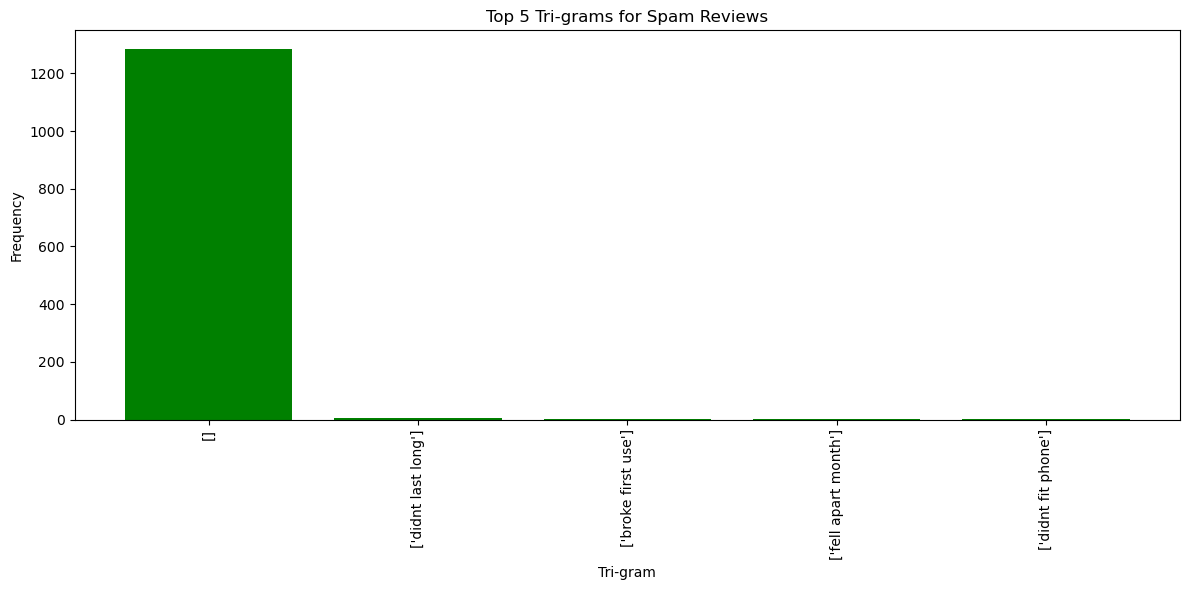

In [226]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(ham_ngrams)), ham_frequencies, align='center',color="green")
plt.xticks(range(len(ham_ngrams)), ham_ngrams, rotation=90)
plt.xlabel("Tri-gram")
plt.ylabel("Frequency")
plt.title("Top 5 Tri-grams for Spam Reviews")
plt.tight_layout()
plt.show()

#### Feature Engineering

##### Amazon Spam Reviews Dataset

In [227]:
count_vec = CountVectorizer(inputCol='lemmas',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
#spam_df = spam_df.withColumn('abs_sentiment_score', abs(spam_df['sentiment_score']))
vectorassembler = VectorAssembler(inputCols=['tf_idf','review_text_length','abs_sentiment_score'],outputCol='features')


In [228]:
spam_df.limit(5).toPandas()

class                                         reviewText   reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...   04 5, 2011   
1    1.0  BOUGHT THIS FOR MY SPRING EVO. WORKS GREAT! ON...  09 27, 2010   
2    1.0  Anyone who spends time traveling knows how enj...   10 4, 2002   
3    1.0  This has simplified my life as I am on the pho...  07 18, 2013   
4    1.0  I was looking for earplugs like these, with ju...  01 18, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011         0.385000   
1  819940471X  A3FY0NVLZ96B5Z  2010-09-27    Fall  2010         0.312500   
2  B00004U8KM   ALR35EFI69S5R  2002-10-04    Fall  2002         0.303333   
3  B0000CEPC8  A18WQ1QWZU6TNR  2013-07-18  Summer  2013         0.420000   
4  B0002KQZJ8  A37L2MQCKR905P  2013-01-18  Winter  2013         0.450000   

  sentiment  abs_sentiment_score  review_text_length labels  \
0  positive             0.385000                 361    ham   
1  positive             0.312500                 315   spam   
2  positive             0.303333                 927   spam   
3  positive             0.420000                 191   spam   
4  positive             0.450000                 189   spam   

                                    reviewText_clean  \
0  i ordered this vehicle charger on the amazon w...   
1  bought this for my spring evo works great one ...   
2  anyone who spends time traveling knows how enj...   
3  this has simplified my life as i am on the pho...   
4  i was looking for earplugs like these with jus...   

                                               token  \
0  [i, ordered, this, vehicle, charger, on, the, ...   
1  [bought, this, for, my, spring, evo, works, gr...   
2  [anyone, who, spends, time, traveling, knows, ...   
3  [this, has, simplified, my, life, as, i, am, o...   
4  [i, was, looking, for, earplugs, like, these, ...   

                                        stop_removed  \
0  [ordered, vehicle, charger, amazon, web, site,...   
1  [bought, spring, evo, works, great, one, best,...   
2  [anyone, spends, time, traveling, knows, enjoy...   
3  [simplified, life, phone, majority, day, produ...   
4  [looking, earplugs, like, one, earpiece, nice,...   

                                              lemmas  \
0  [ordered, vehicle, charger, amazon, web, site,...   
1  [bought, spring, evo, work, great, one, best, ...   
2  [anyone, spends, time, traveling, know, enjoya...   
3  [simplified, life, phone, majority, day, produ...   
4  [looking, earplug, like, one, earpiece, nice, ...   

                                 concatenated_lemmas  
0  ordered vehicle charger amazon web site i335 m...  
1  bought spring evo work great one best car char...  
2  anyone spends time traveling know enjoyable de...  
3  simplified life phone majority day productive ...  
4  looking earplug like one earpiece nice long co...

In [229]:
data_prep_pipe = Pipeline(stages=[count_vec,idf,vectorassembler])
cleaner = data_prep_pipe.fit(spam_df)
clean_data = cleaner.transform(spam_df)

23/07/31 10:25:58 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/07/31 10:38:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [230]:
cleaner.save("gs://productpal_bucket/pipelines/data_prep_pipe")

23/07/31 10:38:26 WARN TaskSetManager: Stage 559 contains a task of very large size (5036 KiB). The maximum recommended task size is 1000 KiB.
23/07/31 10:38:29 WARN GhfsStorageStatistics: Detected potential high latency for operation op_create. latencyMs=175; previousMaxLatencyMs=104; operationCount=13; context=gs://productpal_bucket/pipelines/data_prep_pipe/stages/0_CountVectorizer_118d28e44177/data/_SUCCESS
23/07/31 10:38:30 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_write_close_operations. latencyMs=313; previousMaxLatencyMs=178; operationCount=12; context=gs://productpal_bucket/pipelines/data_prep_pipe/stages/0_CountVectorizer_118d28e44177/data/_SUCCESS
23/07/31 10:38:31 WARN TaskSetManager: Stage 563 contains a task of very large size (4184 KiB). The maximum recommended task size is 1000 KiB.


In [231]:
clean_data.limit(5).toPandas()

23/07/31 10:38:42 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


class                                         reviewText   reviewTime  \
0    0.0  I ordered this vehicle charger on the Amazon w...   04 5, 2011   
1    1.0  BOUGHT THIS FOR MY SPRING EVO. WORKS GREAT! ON...  09 27, 2010   
2    1.0  Anyone who spends time traveling knows how enj...   10 4, 2002   
3    1.0  This has simplified my life as I am on the pho...  07 18, 2013   
4    1.0  I was looking for earplugs like these, with ju...  01 18, 2013   

         asin      reviewerID  reviewDate  season  year  sentiment_score  \
0  8199203501  A3NN6U3AM47ODW  2011-04-05  Spring  2011         0.385000   
1  819940471X  A3FY0NVLZ96B5Z  2010-09-27    Fall  2010         0.312500   
2  B00004U8KM   ALR35EFI69S5R  2002-10-04    Fall  2002         0.303333   
3  B0000CEPC8  A18WQ1QWZU6TNR  2013-07-18  Summer  2013         0.420000   
4  B0002KQZJ8  A37L2MQCKR905P  2013-01-18  Winter  2013         0.450000   

  sentiment  ...  review_text_length  labels  \
0  positive  ...                 361     ham   
1  positive  ...                 315    spam   
2  positive  ...                 927    spam   
3  positive  ...                 191    spam   
4  positive  ...                 189    spam   

                                    reviewText_clean  \
0  i ordered this vehicle charger on the amazon w...   
1  bought this for my spring evo works great one ...   
2  anyone who spends time traveling knows how enj...   
3  this has simplified my life as i am on the pho...   
4  i was looking for earplugs like these with jus...   

                                               token  \
0  [i, ordered, this, vehicle, charger, on, the, ...   
1  [bought, this, for, my, spring, evo, works, gr...   
2  [anyone, who, spends, time, traveling, knows, ...   
3  [this, has, simplified, my, life, as, i, am, o...   
4  [i, was, looking, for, earplugs, like, these, ...   

                                        stop_removed  \
0  [ordered, vehicle, charger, amazon, web, site,...   
1  [bought, spring, evo, works, great, one, best,...   
2  [anyone, spends, time, traveling, knows, enjoy...   
3  [simplified, life, phone, majority, day, produ...   
4  [looking, earplugs, like, one, earpiece, nice,...   

                                              lemmas  \
0  [ordered, vehicle, charger, amazon, web, site,...   
1  [bought, spring, evo, work, great, one, best, ...   
2  [anyone, spends, time, traveling, know, enjoya...   
3  [simplified, life, phone, majority, day, produ...   
4  [looking, earplug, like, one, earpiece, nice, ...   

                                 concatenated_lemmas  \
0  ordered vehicle charger amazon web site i335 m...   
1  bought spring evo work great one best car char...   
2  anyone spends time traveling know enjoyable de...   
3  simplified life phone majority day productive ...   
4  looking earplug like one earpiece nice long co...   

                                               c_vec  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
1  (1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
2  (0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   

                                              tf_idf  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8784543361049...   
1  (1.5164273846815934, 1.3804063746238424, 0.0, ...   
2  (0.0, 0.0, 1.6144001569284925, 1.6890422868346...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (1.5164273846815934, 1.3804063746238424, 1.614...   

                                            features  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8784543361049...  
1  (1.5164273846815934, 1.3804063746238424, 0.0, ...  
2  (0.0, 0.0, 1.6144001569284925, 1.6890422868346...  
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  (1.5164273846815934, 1.3804063746238424, 1.614...  

[5 rows x 21 columns]

In [232]:
clean_data = clean_data.select(['class','features'])

#### Model Building

##### Amazon Spam Reviews Dataset

#### Naive Bayes Model

In [160]:
clean_data = clean_data.withColumnRenamed("class", "label")

In [161]:
# Split the data into training and testing sets
train_data, test_data = clean_data.randomSplit([0.8, 0.2], seed=0)

In [163]:
# Define the Naive Bayes classifier
nb = NaiveBayes()

# List of smoothing values to try
smoothing_values = [0.1, 0.5, 1.0]

# Loop through the smoothing values
for smoothing in smoothing_values:
    # Set the current smoothing value in the Naive Bayes classifier
    nb.setSmoothing(smoothing)

    # Train the model on the training data
    model = nb.fit(train_data)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model's accuracy on the validation data
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    # Print the smoothing value and accuracy
    print(f"Smoothing: {smoothing}, Accuracy: {accuracy}")

23/07/25 11:40:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:44:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:44:31 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


Smoothing: 0.1, Accuracy: 0.820952432863666


23/07/25 11:48:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:51:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:51:27 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


Smoothing: 0.5, Accuracy: 0.8227685019783508


23/07/25 11:54:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:58:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 11:58:20 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


Smoothing: 1.0, Accuracy: 0.8239775629987687


In [164]:
nb.setSmoothing(1.0)

NaiveBayes_f32d50ac7855

In [167]:
nbmodel=nb.fit(train_data)

# Make predictions on the test data
predictions = nbmodel.transform(test_data)

# Evaluate the model's accuracy on the validation data
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

23/07/25 12:27:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 12:32:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 12:32:40 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


In [168]:
accuracy

0.8241338733851089

#### Support Vector Machine Model

In [170]:
# Define the LinearSVC classifier
svm = LinearSVC(regParam=0.1)

# Train the model on the training data
svmmodel = svm.fit(train_data)

# Make predictions on the validation data
predictions = svmmodel.transform(test_data)



23/07/25 15:07:51 ERROR TransportClient: Failed to send RPC RPC 5577353312088291441 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:07:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1721 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5577353312088291441 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:12:41 ERROR TransportClient: Failed to send RPC RPC 8544264517019594350 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:12:41 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1725 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8544264517019594350 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:17:20 ERROR TransportClient: Failed to send RPC RPC 8721121192677841482 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:20 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1728 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8721121192677841482 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:17:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:26 ERROR TransportClient: Failed to send RPC RPC 5836435721468776597 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1732 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5836435721468776597 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:32 ERROR TransportClient: Failed to send RPC RPC 6056028304862792068 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1735 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6056028304862792068 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:37 ERROR TransportClient: Failed to send RPC RPC 8200991995041572709 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1738 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8200991995041572709 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:44 ERROR TransportClient: Failed to send RPC RPC 6412488734956048107 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:44 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1741 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6412488734956048107 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:50 ERROR TransportClient: Failed to send RPC RPC 5207614911573522665 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1744 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5207614911573522665 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:17:55 ERROR TransportClient: Failed to send RPC RPC 7918269405517315148 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:17:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1747 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7918269405517315148 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:17:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:01 ERROR TransportClient: Failed to send RPC RPC 5724857659819319417 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:01 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1750 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5724857659819319417 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:07 ERROR TransportClient: Failed to send RPC RPC 4835907002313310649 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:07 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1753 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4835907002313310649 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:13 ERROR TransportClient: Failed to send RPC RPC 8440034340262999404 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1756 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8440034340262999404 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:19 ERROR TransportClient: Failed to send RPC RPC 7644811266149316234 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:19 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1759 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7644811266149316234 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:25 ERROR TransportClient: Failed to send RPC RPC 6233570687496944829 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:25 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1762 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6233570687496944829 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:31 ERROR TransportClient: Failed to send RPC RPC 9096744978280162573 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:31 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1765 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9096744978280162573 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:36 ERROR TransportClient: Failed to send RPC RPC 6452584734273056603 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:36 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1768 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6452584734273056603 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:42 ERROR TransportClient: Failed to send RPC RPC 8607208344004335335 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1771 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8607208344004335335 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:47 ERROR TransportClient: Failed to send RPC RPC 7190873215466375549 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1774 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7190873215466375549 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:53 ERROR TransportClient: Failed to send RPC RPC 5002781098455860024 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1777 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5002781098455860024 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:18:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:18:58 ERROR TransportClient: Failed to send RPC RPC 6181714414012709012 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:18:58 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1780 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6181714414012709012 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:03 ERROR TransportClient: Failed to send RPC RPC 9037721058417880044 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:03 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1783 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9037721058417880044 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:09 ERROR TransportClient: Failed to send RPC RPC 8248248787410566464 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:09 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1786 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8248248787410566464 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:14 ERROR TransportClient: Failed to send RPC RPC 8345929298732106391 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:14 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1789 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8345929298732106391 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:19 ERROR TransportClient: Failed to send RPC RPC 6948339306757418068 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:19 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1792 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6948339306757418068 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:25 ERROR TransportClient: Failed to send RPC RPC 5458080305232149307 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:25 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1795 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5458080305232149307 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:30 ERROR TransportClient: Failed to send RPC RPC 5933902071278607040 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:30 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1798 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5933902071278607040 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:35 ERROR TransportClient: Failed to send RPC RPC 6444342423613298475 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:35 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1801 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6444342423613298475 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:40 ERROR TransportClient: Failed to send RPC RPC 6201077789212252874 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:40 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1804 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6201077789212252874 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:46 ERROR TransportClient: Failed to send RPC RPC 5542825187880851181 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:46 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1807 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5542825187880851181 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:51 ERROR TransportClient: Failed to send RPC RPC 7307055649131982747 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1810 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7307055649131982747 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:19:56 ERROR TransportClient: Failed to send RPC RPC 6051095471167970985 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:19:56 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1813 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6051095471167970985 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:19:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:02 ERROR TransportClient: Failed to send RPC RPC 4752265243625972686 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:02 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1816 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4752265243625972686 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:07 ERROR TransportClient: Failed to send RPC RPC 4982887700279444812 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:07 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1819 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4982887700279444812 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:13 ERROR TransportClient: Failed to send RPC RPC 5721600601689870769 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1822 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5721600601689870769 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:18 ERROR TransportClient: Failed to send RPC RPC 7745600059755649831 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:18 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1825 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7745600059755649831 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:23 ERROR TransportClient: Failed to send RPC RPC 8030685981939035218 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1828 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8030685981939035218 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:29 ERROR TransportClient: Failed to send RPC RPC 7483577882107354017 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:29 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1831 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7483577882107354017 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:34 ERROR TransportClient: Failed to send RPC RPC 7865562340181149370 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:34 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1834 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7865562340181149370 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:39 ERROR TransportClient: Failed to send RPC RPC 5380318204985768054 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:39 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1837 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5380318204985768054 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:45 ERROR TransportClient: Failed to send RPC RPC 7599141541178619493 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:45 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1840 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7599141541178619493 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:50 ERROR TransportClient: Failed to send RPC RPC 8320658493200275398 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1843 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8320658493200275398 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:20:55 ERROR TransportClient: Failed to send RPC RPC 5175458679715592802 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:20:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1846 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5175458679715592802 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:20:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:01 ERROR TransportClient: Failed to send RPC RPC 5325009780500718395 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:01 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1849 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5325009780500718395 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:06 ERROR TransportClient: Failed to send RPC RPC 5468586086501592987 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:06 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1852 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5468586086501592987 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:11 ERROR TransportClient: Failed to send RPC RPC 6067616952360637520 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:11 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1855 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6067616952360637520 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:17 ERROR TransportClient: Failed to send RPC RPC 7549030540135688263 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:17 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1858 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7549030540135688263 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:22 ERROR TransportClient: Failed to send RPC RPC 8264751144873739935 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:22 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1861 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8264751144873739935 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:27 ERROR TransportClient: Failed to send RPC RPC 7790207175529765804 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:27 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1864 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7790207175529765804 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:33 ERROR TransportClient: Failed to send RPC RPC 5006922619326987059 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:33 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1867 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5006922619326987059 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:38 ERROR TransportClient: Failed to send RPC RPC 8559842340172934693 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:38 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1870 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8559842340172934693 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:43 ERROR TransportClient: Failed to send RPC RPC 7407014615631344257 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:43 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1873 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7407014615631344257 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:49 ERROR TransportClient: Failed to send RPC RPC 7624500900854097679 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:49 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1876 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7624500900854097679 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:54 ERROR TransportClient: Failed to send RPC RPC 8236553424397232019 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:54 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1879 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8236553424397232019 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:21:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:21:59 ERROR TransportClient: Failed to send RPC RPC 6960813402704685856 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:21:59 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1882 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6960813402704685856 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:04 ERROR TransportClient: Failed to send RPC RPC 7312797714462390955 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1885 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7312797714462390955 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:10 ERROR TransportClient: Failed to send RPC RPC 6054726678156205577 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:10 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1888 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6054726678156205577 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:15 ERROR TransportClient: Failed to send RPC RPC 6272839715025526901 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1891 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6272839715025526901 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:20 ERROR TransportClient: Failed to send RPC RPC 6770167654727996514 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:20 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1894 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6770167654727996514 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:25 ERROR TransportClient: Failed to send RPC RPC 5200031181351238257 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:25 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1897 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5200031181351238257 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:30 ERROR TransportClient: Failed to send RPC RPC 8032121494856143281 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:30 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1900 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8032121494856143281 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:36 ERROR TransportClient: Failed to send RPC RPC 8188580808128221157 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:36 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1903 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8188580808128221157 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:41 ERROR TransportClient: Failed to send RPC RPC 7199206692968621489 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:41 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1906 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7199206692968621489 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:47 ERROR TransportClient: Failed to send RPC RPC 8408964874781446013 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1909 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8408964874781446013 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:51 ERROR TransportClient: Failed to send RPC RPC 6946634700479417507 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1912 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6946634700479417507 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:22:57 ERROR TransportClient: Failed to send RPC RPC 5627781224795048170 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:22:57 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1915 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5627781224795048170 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:22:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:02 ERROR TransportClient: Failed to send RPC RPC 7772445600734375368 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:02 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1918 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7772445600734375368 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:07 ERROR TransportClient: Failed to send RPC RPC 6814518327129404862 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:07 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1921 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6814518327129404862 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:13 ERROR TransportClient: Failed to send RPC RPC 4911480450023480392 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1924 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4911480450023480392 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:18 ERROR TransportClient: Failed to send RPC RPC 5202218130891829586 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:18 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1927 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5202218130891829586 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:23 ERROR TransportClient: Failed to send RPC RPC 6852876077088402886 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1930 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6852876077088402886 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:28 ERROR TransportClient: Failed to send RPC RPC 4667788737932430267 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:28 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1933 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4667788737932430267 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:33 ERROR TransportClient: Failed to send RPC RPC 6190206054314366469 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:33 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1936 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6190206054314366469 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:39 ERROR TransportClient: Failed to send RPC RPC 6174758496642215407 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:39 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1939 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6174758496642215407 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:44 ERROR TransportClient: Failed to send RPC RPC 5074751260976204198 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:44 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1942 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5074751260976204198 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:49 ERROR TransportClient: Failed to send RPC RPC 6967005499841252871 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:49 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1945 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6967005499841252871 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:54 ERROR TransportClient: Failed to send RPC RPC 5635399519784904503 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:23:54 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1948 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5635399519784904503 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:23:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:23:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:00 ERROR TransportClient: Failed to send RPC RPC 6594723580029482650 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1951 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6594723580029482650 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:05 ERROR TransportClient: Failed to send RPC RPC 8564956831761248013 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1954 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8564956831761248013 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:10 ERROR TransportClient: Failed to send RPC RPC 5616750766982189141 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:10 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1957 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5616750766982189141 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:16 ERROR TransportClient: Failed to send RPC RPC 9162388169521920777 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:16 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1960 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9162388169521920777 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:21 ERROR TransportClient: Failed to send RPC RPC 6125484530464909651 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1963 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6125484530464909651 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:26 ERROR TransportClient: Failed to send RPC RPC 7415907164560569902 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1966 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7415907164560569902 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:32 ERROR TransportClient: Failed to send RPC RPC 7858244485668980462 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1969 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7858244485668980462 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:37 ERROR TransportClient: Failed to send RPC RPC 5561916457487366132 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1972 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5561916457487366132 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:43 ERROR TransportClient: Failed to send RPC RPC 5946669570401933367 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:43 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1975 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5946669570401933367 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:48 ERROR TransportClient: Failed to send RPC RPC 8193796787733014694 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:48 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1978 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8193796787733014694 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:53 ERROR TransportClient: Failed to send RPC RPC 7661122521051267357 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1981 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7661122521051267357 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:24:57 ERROR TransportClient: Failed to send RPC RPC 9111961578256561335 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:24:57 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1984 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9111961578256561335 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:24:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:02 ERROR TransportClient: Failed to send RPC RPC 5546660651470570757 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:02 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1987 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5546660651470570757 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:08 ERROR TransportClient: Failed to send RPC RPC 6493019949046702554 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:08 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1990 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6493019949046702554 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:13 ERROR TransportClient: Failed to send RPC RPC 4818978278858424942 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1993 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4818978278858424942 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:18 ERROR TransportClient: Failed to send RPC RPC 5855499890241991185 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:18 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1996 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5855499890241991185 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:23 ERROR TransportClient: Failed to send RPC RPC 9025547530456064525 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1999 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9025547530456064525 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:28 ERROR TransportClient: Failed to send RPC RPC 4741387557512764960 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:28 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2002 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4741387557512764960 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:34 ERROR TransportClient: Failed to send RPC RPC 5146463316797949127 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:34 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2005 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5146463316797949127 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:39 ERROR TransportClient: Failed to send RPC RPC 8539338001610667771 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:39 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2008 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8539338001610667771 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:45 ERROR TransportClient: Failed to send RPC RPC 6268515234163800395 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:45 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2011 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6268515234163800395 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:50 ERROR TransportClient: Failed to send RPC RPC 5172844044879299337 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2014 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5172844044879299337 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:55 ERROR TransportClient: Failed to send RPC RPC 7477076171493919846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:25:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2017 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7477076171493919846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:25:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:25:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:00 ERROR TransportClient: Failed to send RPC RPC 9125794530068336343 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2020 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9125794530068336343 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:05 ERROR TransportClient: Failed to send RPC RPC 9108106827368171202 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2023 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9108106827368171202 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:11 ERROR TransportClient: Failed to send RPC RPC 7217477887116621177 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:11 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2026 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7217477887116621177 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:16 ERROR TransportClient: Failed to send RPC RPC 5161000038393794501 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:16 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2029 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5161000038393794501 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:21 ERROR TransportClient: Failed to send RPC RPC 5672654635923656590 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2032 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5672654635923656590 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:27 ERROR TransportClient: Failed to send RPC RPC 5630968458091263154 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:27 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2035 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5630968458091263154 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:32 ERROR TransportClient: Failed to send RPC RPC 5685300051580857371 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2038 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5685300051580857371 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:37 ERROR TransportClient: Failed to send RPC RPC 5694183308724294713 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2041 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5694183308724294713 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:42 ERROR TransportClient: Failed to send RPC RPC 7271540961211228197 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2044 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7271540961211228197 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:47 ERROR TransportClient: Failed to send RPC RPC 9022303467871343925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2047 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9022303467871343925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:53 ERROR TransportClient: Failed to send RPC RPC 7119882781051102221 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2050 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7119882781051102221 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:26:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:26:58 ERROR TransportClient: Failed to send RPC RPC 8839033255580789264 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:26:58 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2053 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8839033255580789264 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:03 ERROR TransportClient: Failed to send RPC RPC 7746508264926327666 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:03 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2056 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7746508264926327666 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:08 ERROR TransportClient: Failed to send RPC RPC 6153074414704195304 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:08 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2059 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6153074414704195304 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:14 ERROR TransportClient: Failed to send RPC RPC 5694252183128206171 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:14 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2062 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5694252183128206171 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:19 ERROR TransportClient: Failed to send RPC RPC 5341182879183963768 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:19 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2065 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5341182879183963768 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:24 ERROR TransportClient: Failed to send RPC RPC 5082576578583047925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:24 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2068 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5082576578583047925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:29 ERROR TransportClient: Failed to send RPC RPC 7184823008275650994 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:29 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2071 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7184823008275650994 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:34 ERROR TransportClient: Failed to send RPC RPC 7341352156086994542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:34 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2074 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7341352156086994542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:39 ERROR TransportClient: Failed to send RPC RPC 4631114016325098373 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:39 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2077 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4631114016325098373 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:44 ERROR TransportClient: Failed to send RPC RPC 8816898330404830891 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:44 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2080 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8816898330404830891 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:50 ERROR TransportClient: Failed to send RPC RPC 7280203415881235574 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2083 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7280203415881235574 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:27:55 ERROR TransportClient: Failed to send RPC RPC 9025807986069315349 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:27:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2086 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9025807986069315349 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:27:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:00 ERROR TransportClient: Failed to send RPC RPC 8634276439412655949 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2089 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8634276439412655949 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:05 ERROR TransportClient: Failed to send RPC RPC 9111637534966078107 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2092 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9111637534966078107 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:10 ERROR TransportClient: Failed to send RPC RPC 8939556364336824075 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:10 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2095 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8939556364336824075 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:15 ERROR TransportClient: Failed to send RPC RPC 7532916221587328319 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2098 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7532916221587328319 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:21 ERROR TransportClient: Failed to send RPC RPC 7081486709587188058 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2101 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7081486709587188058 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:26 ERROR TransportClient: Failed to send RPC RPC 7549825365230257661 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2104 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7549825365230257661 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:31 ERROR TransportClient: Failed to send RPC RPC 4641909297753449904 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:31 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2107 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4641909297753449904 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:36 ERROR TransportClient: Failed to send RPC RPC 8899115871080678925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:36 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2110 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8899115871080678925 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:42 ERROR TransportClient: Failed to send RPC RPC 7526126985371238725 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2113 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7526126985371238725 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:46 ERROR TransportClient: Failed to send RPC RPC 6933931177410036109 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:46 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2116 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6933931177410036109 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:51 ERROR TransportClient: Failed to send RPC RPC 5423292901416300212 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2119 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5423292901416300212 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:28:56 ERROR TransportClient: Failed to send RPC RPC 8378055851983011597 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:28:56 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2122 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8378055851983011597 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:28:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:01 ERROR TransportClient: Failed to send RPC RPC 6476930887038299459 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:01 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2125 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6476930887038299459 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:06 ERROR TransportClient: Failed to send RPC RPC 9042175534996138828 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:06 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2128 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9042175534996138828 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:11 ERROR TransportClient: Failed to send RPC RPC 8167949385729258929 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:11 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2131 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8167949385729258929 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:16 ERROR TransportClient: Failed to send RPC RPC 7224198408506904655 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:16 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2134 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7224198408506904655 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:22 ERROR TransportClient: Failed to send RPC RPC 7458804674009301165 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:22 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2137 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7458804674009301165 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:29 ERROR TransportClient: Failed to send RPC RPC 7887168556999555175 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:29 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2140 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7887168556999555175 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:35 ERROR TransportClient: Failed to send RPC RPC 5163194941108871967 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:35 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2143 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5163194941108871967 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:40 ERROR TransportClient: Failed to send RPC RPC 4641189186826539402 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:40 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2146 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4641189186826539402 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:45 ERROR TransportClient: Failed to send RPC RPC 6766968769745176147 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:45 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2149 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6766968769745176147 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:50 ERROR TransportClient: Failed to send RPC RPC 8415043910826646425 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2152 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8415043910826646425 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:55 ERROR TransportClient: Failed to send RPC RPC 9097763042409753271 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:29:55 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2155 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9097763042409753271 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:29:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:29:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:00 ERROR TransportClient: Failed to send RPC RPC 8930534788395411426 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2158 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8930534788395411426 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:30:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:05 ERROR TransportClient: Failed to send RPC RPC 6836062630650344461 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2161 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6836062630650344461 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:30:06 ERROR TransportClient: Failed to send RPC RPC 5065809679330555846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:06 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2160 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5065809679330555846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:30:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:15 ERROR TransportClient: Failed to send RPC RPC 8765728606400677608 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2166 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8765728606400677608 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:30:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:20 ERROR TransportClient: Failed to send RPC RPC 5608850891843334055 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:20 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 727 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5608850891843334055 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:30:21 ERROR TransportClient: Failed to send RPC RPC 8775688786207633322 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2169 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8775688786207633322 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:30:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:31 ERROR TransportClient: Failed to send RPC RPC 5313120293227046666 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:31 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2177 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5313120293227046666 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:30:31 ERROR TransportClient: Failed to send RPC RPC 7098805735768741733 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:31 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2175 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7098805735768741733 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:30:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:41 ERROR TransportClient: Failed to send RPC RPC 6191560923807185544 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:41 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 731 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6191560923807185544 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:30:42 ERROR TransportClient: Failed to send RPC RPC 6648638097460497762 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2181 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6648638097460497762 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:30:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:30:53 ERROR TransportClient: Failed to send RPC RPC 5171448799218069930 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:53 ERROR TransportClient: Failed to send RPC RPC 6343203945840912969 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:53 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 733 from block manager Block

23/07/25 15:30:53 ERROR TransportClient: Failed to send RPC RPC 7066094090730690955 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2187 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7066094090730690955 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:30:58 ERROR TransportClient: Failed to send RPC RPC 6537170054185875421 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:58 ERROR TransportClient: Failed to send RPC RPC 8027613979344285275 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:30:58 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 734 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6537170054185875421 to /10.128.0.14:4910

23/07/25 15:31:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:04 ERROR TransportClient: Failed to send RPC RPC 7764562973586677478 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:04 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2194 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7764562973586677478 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:31:04 ERROR TransportClient: Failed to send RPC RPC 4991139493230628028 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:04 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2193 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4991139493230628028 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:31:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:15 ERROR TransportClient: Failed to send RPC RPC 8276527908327092163 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:15 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 737 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8276527908327092163 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:31:16 ERROR TransportClient: Failed to send RPC RPC 8715159843946230416 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:16 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2199 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8715159843946230416 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:31:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:26 ERROR TransportClient: Failed to send RPC RPC 8472409324608441084 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2207 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8472409324608441084 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:31:26 ERROR TransportClient: Failed to send RPC RPC 5593477452663229808 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2205 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5593477452663229808 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:31:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:37 ERROR TransportClient: Failed to send RPC RPC 7255403388279900060 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2212 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7255403388279900060 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:31:37 ERROR TransportClient: Failed to send RPC RPC 6091756154104766815 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2211 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6091756154104766815 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:31:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:49 ERROR TransportClient: Failed to send RPC RPC 6350436893594065736 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:49 ERROR TransportClient: Failed to send RPC RPC 6733651640583877029 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:49 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 743 from block manager Block

23/07/25 15:31:49 ERROR TransportClient: Failed to send RPC RPC 5472277729594596020 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:31:49 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2217 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5472277729594596020 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:31:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:31:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:00 ERROR TransportClient: Failed to send RPC RPC 5988965287201639802 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:00 ERROR TransportClient: Failed to send RPC RPC 5086301695401478508 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:00 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 745 from block manager Block

23/07/25 15:32:00 ERROR TransportClient: Failed to send RPC RPC 6470898342721904667 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2223 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6470898342721904667 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:05 ERROR TransportClient: Failed to send RPC RPC 7241096492477252950 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:05 ERROR TransportClient: Failed to send RPC RPC 6933940969980887503 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:05 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 746 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7241096492477252950 to /10.128.0.14:4910

23/07/25 15:32:11 ERROR TransportClient: Failed to send RPC RPC 6645065501695425424 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:11 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2229 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6645065501695425424 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:21 ERROR TransportClient: Failed to send RPC RPC 5534166043275774935 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2236 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5534166043275774935 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:32:22 ERROR TransportClient: Failed to send RPC RPC 6855273378647600927 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:22 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2235 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6855273378647600927 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:32 ERROR TransportClient: Failed to send RPC RPC 8748993935312327416 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2242 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8748993935312327416 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:32:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:38 ERROR TransportClient: Failed to send RPC RPC 7499934265609128352 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:38 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 752 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7499934265609128352 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:32:38 ERROR TransportClient: Failed to send RPC RPC 7323982265467906698 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:38 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2244 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7323982265467906698 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:44 ERROR TransportClient: Failed to send RPC RPC 5837780471251372996 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:44 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2249 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5837780471251372996 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:49 ERROR TransportClient: Failed to send RPC RPC 5828997898789332906 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:49 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2251 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5828997898789332906 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:32:49 ERROR TransportClient: Failed to send RPC RPC 6599986818526745132 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:49 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2250 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6599986818526745132 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:54 ERROR TransportClient: Failed to send RPC RPC 7359344001235980040 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:54 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2253 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7359344001235980040 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:32:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:32:59 ERROR TransportClient: Failed to send RPC RPC 8867330928264608471 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:32:59 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 756 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8867330928264608471 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:33:00 ERROR TransportClient: Failed to send RPC RPC 8183179803627613256 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:00 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2256 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8183179803627613256 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:05 ERROR TransportClient: Failed to send RPC RPC 8377950141783104730 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2261 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8377950141783104730 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:10 ERROR TransportClient: Failed to send RPC RPC 6060065757856284630 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:10 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 758 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6060065757856284630 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-commo

23/07/25 15:33:11 ERROR TransportClient: Failed to send RPC RPC 8137851319876426574 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:11 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2262 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8137851319876426574 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:16 ERROR TransportClient: Failed to send RPC RPC 8793153286830110444 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:16 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2267 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8793153286830110444 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:21 ERROR TransportClient: Failed to send RPC RPC 7294972503584225798 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2270 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7294972503584225798 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:33:22 ERROR TransportClient: Failed to send RPC RPC 4635452145480197212 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:22 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2268 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4635452145480197212 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:27 ERROR TransportClient: Failed to send RPC RPC 5488809661740210240 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:27 ERROR TransportClient: Failed to send RPC RPC 5024746667113065310 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:27 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 761 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5488809661740210240 to /10.128.0.14:4910

23/07/25 15:33:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:32 ERROR TransportClient: Failed to send RPC RPC 5485243193928584190 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:32 ERROR TransportClient: Failed to send RPC RPC 6659400220728638466 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2276 from block manager Bl

	at io.netty.channel.AbstractChannelHandlerContext.invokeWrite0(AbstractChannelHandlerContext.java:717) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.channel.AbstractChannelHandlerContext.invokeWriteAndFlush(AbstractChannelHandlerContext.java:764) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.channel.AbstractChannelHandlerContext$WriteTask.run(AbstractChannelHandlerContext.java:1071) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.util.concurrent.AbstractEventExecutor.runTask(AbstractEventExecutor.java:174) ~[netty-common-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.util.concurrent.AbstractEventExecutor.safeExecute(AbstractEventExecutor.java:167) ~[netty-common-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.util.concurrent.SingleThreadEventExecutor.runAllTasks(SingleThreadEventExecutor.java:470) ~[netty-common-4.1.77.Final.jar:4.1.77.Final]
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:503) ~[netty-transport-4.1.77.Final.jar:4.1.7

23/07/25 15:33:37 ERROR TransportClient: Failed to send RPC RPC 5299735475365404371 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2279 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5299735475365404371 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:33:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:42 ERROR TransportClient: Failed to send RPC RPC 6534273843144238140 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2281 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6534273843144238140 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:33:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:47 ERROR TransportClient: Failed to send RPC RPC 6839217914228524646 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2284 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6839217914228524646 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:33:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:52 ERROR TransportClient: Failed to send RPC RPC 6569416971036839731 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:52 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2287 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6569416971036839731 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:33:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:33:57 ERROR TransportClient: Failed to send RPC RPC 8363379335042129192 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:33:57 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2290 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8363379335042129192 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:33:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:02 ERROR TransportClient: Failed to send RPC RPC 7909928406093292986 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:02 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2293 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7909928406093292986 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:07 ERROR TransportClient: Failed to send RPC RPC 5744352950308352811 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:07 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2296 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5744352950308352811 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:13 ERROR TransportClient: Failed to send RPC RPC 8185844545433506016 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2299 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8185844545433506016 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:18 ERROR TransportClient: Failed to send RPC RPC 5888323526819975085 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:18 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2302 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5888323526819975085 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:23 ERROR TransportClient: Failed to send RPC RPC 9142595355404140889 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2305 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9142595355404140889 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:28 ERROR TransportClient: Failed to send RPC RPC 7567920073269415819 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:28 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2308 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7567920073269415819 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:33 ERROR TransportClient: Failed to send RPC RPC 4963183823959466434 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:33 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2311 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4963183823959466434 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:37 ERROR TransportClient: Failed to send RPC RPC 7221996680930916409 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2314 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7221996680930916409 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:42 ERROR TransportClient: Failed to send RPC RPC 4885174766770352553 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2317 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4885174766770352553 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:47 ERROR TransportClient: Failed to send RPC RPC 7007161635431857736 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2320 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7007161635431857736 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:52 ERROR TransportClient: Failed to send RPC RPC 5275370280527564380 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:52 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2323 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5275370280527564380 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:34:57 ERROR TransportClient: Failed to send RPC RPC 4899772873389755800 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:34:57 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2326 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4899772873389755800 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:34:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:35:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:35:02 ERROR TransportClient: Failed to send RPC RPC 7489717334007953542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:02 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2329 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7489717334007953542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:35:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:35:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 15:35:07 ERROR TransportClient: Failed to send RPC RPC 5766556732690029407 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:07 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2332 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5766556732690029407 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 15:35:15 ERROR TransportClient: Failed to send RPC RPC 6995090658741215045 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2335 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6995090658741215045 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:35:15 ERROR TransportClient: Failed to send RPC RPC 6801571402374858473 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 1726 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6801571402374858473 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 15:35:19 ERROR TransportClient: Failed to send RPC RPC 5161683636735935548 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:19 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2337 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5161683636735935548 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

In [171]:
# Evaluate the model's accuracy on the validation data
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the regParam value and accuracy
print(f"Accuracy: {accuracy}") 

23/07/25 15:35:23 ERROR TransportClient: Failed to send RPC RPC 6345001245997479103 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 15:35:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2339 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6345001245997479103 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

Accuracy: 0.8924257777755755


#### RandomForestClassifier model

In [177]:
# Create an instance of RandomForestClassifier
rf = RandomForestClassifier(maxDepth=15)


# Train the model on the training data
rfmodel = rf.fit(train_data)

# Make predictions on the validation data
predictions = rfmodel.transform(test_data)


23/07/25 17:11:15 ERROR TransportClient: Failed to send RPC RPC 8935225832236402814 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:11:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2381 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8935225832236402814 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 17:16:13 ERROR TransportClient: Failed to send RPC RPC 8626964401232640355 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:16:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2385 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8626964401232640355 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 17:21:08 WARN DAGScheduler: Broadcasting large task binary with size 23.6 MiB
23/07/25 17:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/07/25 17:23:59 ERROR TransportClient: Failed to send RPC RPC 5998718770666246248 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:23:59 ERROR TransportClient: Failed to send RPC RPC 6746511346926206708 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:23:59 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 806 from block manager Blo

23/07/25 17:24:00 WARN DAGScheduler: Broadcasting large task binary with size 24.7 MiB
23/07/25 17:26:37 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000082 on host: cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal. Exit status: 52. Diagnostics: [2023-07-25 17:26:37.517]Exception from container-launch.
Container id: container_1690281422227_0003_01_000082
Exit code: 52

[2023-07-25 17:26:37.519]Container exited with a non-zero exit code 52. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
0800698c40.apply(Unknown Source) ~[?:?]
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504) ~[spark-core_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551) ~[spark-core_2.12-3.3.0.jar:3.3.0]
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) ~[?:?]
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.

23/07/25 17:27:09 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000086 on host: cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:27:09.688]Container killed on request. Exit code is 143
[2023-07-25 17:27:09.688]Container exited with a non-zero exit code 143. 
[2023-07-25 17:27:09.689]Killed by external signal
.
23/07/25 17:27:09 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 80 for reason Container from a bad node: container_1690281422227_0003_01_000086 on host: cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:27:09.688]Container killed on request. Exit code is 143
[2023-07-25 17:27:09.688]Container exited with a non-zero exit code 143. 
[2023-07-25 17:27:09.689]Killed by external signal
.
23/07/25 17:27:09 ERROR YarnScheduler: Lost executor 80 on cluster-d624-w-0.us-central1-f.c.green-radius-39020

23/07/25 17:30:01 ERROR TransportClient: Failed to send RPC RPC 5087675674727451692 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:30:01 ERROR TransportClient: Failed to send RPC RPC 7558895485657718384 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:30:01 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 804 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5087675674727451692 to /10.128.0.14:4910

23/07/25 17:32:11 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000091 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:32:11.072]Container killed on request. Exit code is 143
[2023-07-25 17:32:11.072]Container exited with a non-zero exit code 143. 
[2023-07-25 17:32:11.072]Killed by external signal
.
23/07/25 17:32:11 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 85 for reason Container from a bad node: container_1690281422227_0003_01_000091 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:32:11.072]Container killed on request. Exit code is 143
[2023-07-25 17:32:11.072]Container exited with a non-zero exit code 143. 
[2023-07-25 17:32:11.072]Killed by external signal
.
23/07/25 17:32:11 ERROR YarnScheduler: Lost executor 85 on cluster-d624-w-1.us-central1-f.c.green-radius-39020

23/07/25 17:33:48 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000094 on host: cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:33:47.967]Container killed on request. Exit code is 143
[2023-07-25 17:33:47.968]Container exited with a non-zero exit code 143. 
[2023-07-25 17:33:47.969]Killed by external signal
.
23/07/25 17:33:48 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 88 for reason Container from a bad node: container_1690281422227_0003_01_000094 on host: cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 17:33:47.967]Container killed on request. Exit code is 143
[2023-07-25 17:33:47.968]Container exited with a non-zero exit code 143. 
[2023-07-25 17:33:47.969]Killed by external signal
.
23/07/25 17:33:48 ERROR YarnScheduler: Lost executor 88 on cluster-d624-w-4.us-central1-f.c.green-radius-39020

23/07/25 17:36:44 WARN TaskSetManager: Lost task 12.2 in stage 2400.0 (TID 17137) (cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal executor 89): TaskKilled (Stage cancelled)
23/07/25 17:36:44 WARN TaskSetManager: Lost task 7.2 in stage 2400.0 (TID 17140) (cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal executor 90): TaskKilled (Stage cancelled)


Py4JJavaError: An error occurred while calling o2314.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2400.0 failed 4 times, most recent failure: Lost task 0.3 in stage 2400.0 (TID 17144) (cluster-d624-w-3.us-central1-f.c.green-radius-390205.internal executor 91): ExecutorLostFailure (executor 91 exited caused by one of the running tasks) Reason: Container from a bad node: container_1690281422227_0003_01_000097 on host: cluster-d624-w-3.us-central1-f.c.green-radius-390205.internal. Exit status: 52. Diagnostics: [2023-07-25 17:36:44.211]Exception from container-launch.
Container id: container_1690281422227_0003_01_000097
Exit code: 52

[2023-07-25 17:36:44.214]Container exited with a non-zero exit code 52. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
eptionHandler: Uncaught OutOfMemoryError in thread Thread[RemoteBlock-temp-file-clean-thread,5,main], process halted.
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread stdout writer for /opt/conda/miniconda3/bin/python
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread executor-heartbeater
java.lang.OutOfMemoryError: Java heap space
	at jdk.internal.reflect.ReflectionFactory.generateConstructor(ReflectionFactory.java:513) ~[?:?]
	at jdk.internal.reflect.ReflectionFactory.newConstructorForSerialization(ReflectionFactory.java:506) ~[?:?]
	at java.io.ObjectStreamClass.getSerializableConstructor(ObjectStreamClass.java:1402) ~[?:?]
	at java.io.ObjectStreamClass$2.run(ObjectStreamClass.java:380) ~[?:?]
	at java.io.ObjectStreamClass$2.run(ObjectStreamClass.java:355) ~[?:?]
	at java.security.AccessController.doPrivileged(Native Method) ~[?:?]
	at java.io.ObjectStreamClass.<init>(ObjectStreamClass.java:355) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:98) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:95) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:73) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:70) ~[?:?]
	at java.lang.ClassValue.getFromHashMap(ClassValue.java:228) ~[?:?]
	at java.lang.ClassValue.getFromBackup(ClassValue.java:210) ~[?:?]
	at java.lang.ClassValue.get(ClassValue.java:116) ~[?:?]
	at java.io.ClassCache.get(ClassCache.java:84) ~[?:?]
	at java.io.ObjectStreamClass.lookup(ObjectStreamClass.java:336) ~[?:?]
	at java.io.ObjectStreamClass.<init>(ObjectStreamClass.java:351) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:98) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:95) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:73) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:70) ~[?:?]
	at java.lang.ClassValue.getFromHashMap(ClassValue.java:228) ~[?:?]
	at java.lang.ClassValue.getFromBackup(ClassValue.java:210) ~[?:?]
	at java.lang.ClassValue.get(ClassValue.java:116) ~[?:?]
	at java.io.ClassCache.get(ClassCache.java:84) ~[?:?]
	at java.io.ObjectStreamClass.lookup(ObjectStreamClass.java:336) ~[?:?]
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1125) ~[?:?]
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543) ~[?:?]
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500) ~[?:?]
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423) ~[?:?]
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169) ~[?:?]
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543) ~[?:?]
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread stdout writer for /opt/conda/miniconda3/bin/python
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[executor-kill-mark-cleanup,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Executor: Exception in task 1.3 in stage 2400.0 (TID 17145): Java heap space


[2023-07-25 17:36:44.214]Container exited with a non-zero exit code 52. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
eptionHandler: Uncaught OutOfMemoryError in thread Thread[RemoteBlock-temp-file-clean-thread,5,main], process halted.
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread stdout writer for /opt/conda/miniconda3/bin/python
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread executor-heartbeater
java.lang.OutOfMemoryError: Java heap space
	at jdk.internal.reflect.ReflectionFactory.generateConstructor(ReflectionFactory.java:513) ~[?:?]
	at jdk.internal.reflect.ReflectionFactory.newConstructorForSerialization(ReflectionFactory.java:506) ~[?:?]
	at java.io.ObjectStreamClass.getSerializableConstructor(ObjectStreamClass.java:1402) ~[?:?]
	at java.io.ObjectStreamClass$2.run(ObjectStreamClass.java:380) ~[?:?]
	at java.io.ObjectStreamClass$2.run(ObjectStreamClass.java:355) ~[?:?]
	at java.security.AccessController.doPrivileged(Native Method) ~[?:?]
	at java.io.ObjectStreamClass.<init>(ObjectStreamClass.java:355) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:98) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:95) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:73) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:70) ~[?:?]
	at java.lang.ClassValue.getFromHashMap(ClassValue.java:228) ~[?:?]
	at java.lang.ClassValue.getFromBackup(ClassValue.java:210) ~[?:?]
	at java.lang.ClassValue.get(ClassValue.java:116) ~[?:?]
	at java.io.ClassCache.get(ClassCache.java:84) ~[?:?]
	at java.io.ObjectStreamClass.lookup(ObjectStreamClass.java:336) ~[?:?]
	at java.io.ObjectStreamClass.<init>(ObjectStreamClass.java:351) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:98) ~[?:?]
	at java.io.ObjectStreamClass$Caches$1.computeValue(ObjectStreamClass.java:95) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:73) ~[?:?]
	at java.io.ClassCache$1.computeValue(ClassCache.java:70) ~[?:?]
	at java.lang.ClassValue.getFromHashMap(ClassValue.java:228) ~[?:?]
	at java.lang.ClassValue.getFromBackup(ClassValue.java:210) ~[?:?]
	at java.lang.ClassValue.get(ClassValue.java:116) ~[?:?]
	at java.io.ClassCache.get(ClassCache.java:84) ~[?:?]
	at java.io.ObjectStreamClass.lookup(ObjectStreamClass.java:336) ~[?:?]
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1125) ~[?:?]
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543) ~[?:?]
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500) ~[?:?]
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423) ~[?:?]
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169) ~[?:?]
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543) ~[?:?]
23/07/25 17:36:43 ERROR Utils: Uncaught exception in thread stdout writer for /opt/conda/miniconda3/bin/python
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[stdout writer for /opt/conda/miniconda3/bin/python,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[executor-kill-mark-cleanup,5,main]
java.lang.OutOfMemoryError: Java heap space
23/07/25 17:36:43 ERROR Executor: Exception in task 1.3 in stage 2400.0 (TID 17145): Java heap space


.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2673)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2609)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2608)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2861)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2803)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2792)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2257)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2276)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2301)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:161)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:138)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


23/07/25 17:36:44 WARN TaskSetManager: Lost task 11.2 in stage 2400.0 (TID 17142) (cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal executor 90): TaskKilled (Stage cancelled)
23/07/25 17:36:44 WARN TaskSetManager: Lost task 5.2 in stage 2400.0 (TID 17141) (cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal executor 90): TaskKilled (Stage cancelled)
23/07/25 17:36:44 WARN TaskSetManager: Lost task 3.3 in stage 2400.0 (TID 17138) (cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal executor 89): TaskKilled (Stage cancelled)


In [178]:
# Evaluate the model's accuracy on the validation data
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the regParam value and accuracy
print(f"Accuracy: {accuracy}") 

23/07/25 17:50:51 ERROR TransportClient: Failed to send RPC RPC 7683417814929706713 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:50:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2396 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7683417814929706713 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 17:50:52 ERROR TransportClient: Failed to send RPC RPC 6013729490547416509 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:50:52 ERROR TransportClient: Failed to send RPC RPC 5964856041650600279 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 17:50:52 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 373 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6013729490547416509 to /10.128.0.14:4910

Accuracy: 0.8643057981246826


23/07/25 18:00:01 ERROR TransportClient: Failed to send RPC RPC 5775376246055692350 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 18:00:01 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2398 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5775376246055692350 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

#### Logistic Regression Model

In [185]:
# Create an instance of LogisticRegression
lr = LogisticRegression(featuresCol='features',
                             labelCol='label',regParam=0.1)


# Train the model on the training data
lrmodel = lr.fit(train_data)

# Make predictions on the validation data
predictions = lrmodel.transform(test_data)

23/07/25 19:41:39 ERROR TransportClient: Failed to send RPC RPC 8868340449615479862 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:41:39 ERROR TransportClient: Failed to send RPC RPC 8816855716197663017 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:41:39 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 929 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8868340449615479862 to /10.128.0.14:4910

23/07/25 19:41:42 ERROR TransportClient: Failed to send RPC RPC 7553153116466661436 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:41:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2750 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7553153116466661436 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 19:45:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:43 ERROR TransportClient: Failed to send RPC RPC 7373555058642203327 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:48:43 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2756 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7373555058642203327 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:48:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:48 ERROR TransportClient: Failed to send RPC RPC 8821978307202846080 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:48:48 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2759 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8821978307202846080 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:48:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:53 ERROR TransportClient: Failed to send RPC RPC 5854997169885955846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:48:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2762 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5854997169885955846 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:48:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:48:58 ERROR TransportClient: Failed to send RPC RPC 5185715519653987125 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:48:58 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2765 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5185715519653987125 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:04 ERROR TransportClient: Failed to send RPC RPC 9109583264906661859 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:04 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2768 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9109583264906661859 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:09 ERROR TransportClient: Failed to send RPC RPC 5392617360088722609 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:09 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2771 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5392617360088722609 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:15 ERROR TransportClient: Failed to send RPC RPC 4712666930206918240 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2774 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4712666930206918240 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:21 ERROR TransportClient: Failed to send RPC RPC 5480778065562803312 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:21 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2777 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5480778065562803312 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:26 ERROR TransportClient: Failed to send RPC RPC 5420980238184624601 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2780 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5420980238184624601 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:32 ERROR TransportClient: Failed to send RPC RPC 4612199050380566997 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2783 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4612199050380566997 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:37 ERROR TransportClient: Failed to send RPC RPC 8336421202391908489 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2786 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8336421202391908489 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:43 ERROR TransportClient: Failed to send RPC RPC 6415607295299549140 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:43 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2789 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6415607295299549140 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:48 ERROR TransportClient: Failed to send RPC RPC 7681597164947593531 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:48 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2792 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7681597164947593531 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:54 ERROR TransportClient: Failed to send RPC RPC 6848423947730275256 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:54 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2795 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6848423947730275256 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:49:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:49:59 ERROR TransportClient: Failed to send RPC RPC 8492933207016907284 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:49:59 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2798 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8492933207016907284 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:05 ERROR TransportClient: Failed to send RPC RPC 6934277472773756452 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:05 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2801 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6934277472773756452 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:10 ERROR TransportClient: Failed to send RPC RPC 9104149783376571446 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:10 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2804 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9104149783376571446 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:15 ERROR TransportClient: Failed to send RPC RPC 7169120169810424110 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:15 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2807 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7169120169810424110 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:20 ERROR TransportClient: Failed to send RPC RPC 8593655106382679572 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:20 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2810 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8593655106382679572 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:26 ERROR TransportClient: Failed to send RPC RPC 5893097086093378976 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:26 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2813 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5893097086093378976 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:31 ERROR TransportClient: Failed to send RPC RPC 4639656208336296485 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:31 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2816 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4639656208336296485 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:36 ERROR TransportClient: Failed to send RPC RPC 7241017699395731282 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:36 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2819 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7241017699395731282 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:41 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:42 ERROR TransportClient: Failed to send RPC RPC 5805954677432040035 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:42 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2822 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5805954677432040035 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:47 ERROR TransportClient: Failed to send RPC RPC 5045607708260142689 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:47 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2825 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5045607708260142689 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:52 ERROR TransportClient: Failed to send RPC RPC 7843401489658370542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:52 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2828 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7843401489658370542 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:50:57 ERROR TransportClient: Failed to send RPC RPC 7148023932021407691 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:50:57 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2831 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7148023932021407691 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:50:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:03 ERROR TransportClient: Failed to send RPC RPC 8319712643660335023 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:03 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2834 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8319712643660335023 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:08 ERROR TransportClient: Failed to send RPC RPC 4815200050274295711 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:08 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2837 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4815200050274295711 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:13 ERROR TransportClient: Failed to send RPC RPC 6448982461205795185 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:13 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2840 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6448982461205795185 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:19 ERROR TransportClient: Failed to send RPC RPC 6809827100248710373 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:19 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2843 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6809827100248710373 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:24 ERROR TransportClient: Failed to send RPC RPC 7217685687817560004 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:24 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2846 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7217685687817560004 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:29 ERROR TransportClient: Failed to send RPC RPC 7596700047838278411 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:29 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2849 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7596700047838278411 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:34 ERROR TransportClient: Failed to send RPC RPC 8522866634080115735 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:34 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2852 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8522866634080115735 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:35 ERROR TransportClient: Failed to send RPC RPC 8523118301339091382 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:35 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2851 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8523118301339091382 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 19:51:40 ERROR TransportClient: Failed to send RPC RPC 4735680621543425854 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:40 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2856 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 4735680621543425854 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 19:51:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:45 ERROR TransportClient: Failed to send RPC RPC 7927907460120465974 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:45 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2858 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7927907460120465974 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:50 ERROR TransportClient: Failed to send RPC RPC 7189076362001634302 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:50 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2861 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7189076362001634302 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:51:56 ERROR TransportClient: Failed to send RPC RPC 8821952010222331401 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:51:56 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2864 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8821952010222331401 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:51:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:01 ERROR TransportClient: Failed to send RPC RPC 6637900392759636936 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:01 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2867 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6637900392759636936 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:52:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:06 ERROR TransportClient: Failed to send RPC RPC 7812373760170642699 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:06 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2870 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7812373760170642699 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:52:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:12 ERROR TransportClient: Failed to send RPC RPC 7154786625145541583 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:12 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2873 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7154786625145541583 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:52:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:17 ERROR TransportClient: Failed to send RPC RPC 8689021336980048650 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:17 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2876 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8689021336980048650 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:52:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 19:52:22 ERROR TransportClient: Failed to send RPC RPC 6378732840082082127 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:22 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2879 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 6378732840082082127 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-co

23/07/25 19:52:23 ERROR TransportClient: Failed to send RPC RPC 5357172108216234090 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:23 ERROR TransportClient: Failed to send RPC RPC 8390588982129837082 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:23 WARN BlockManagerMasterEndpoint: Error trying to remove shuffle 975 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5357172108216234090 to /10.128.0.14:4910

23/07/25 19:52:23 ERROR TransportClient: Failed to send RPC RPC 8768232281093646796 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:23 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2754 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8768232281093646796 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 19:52:27 ERROR TransportClient: Failed to send RPC RPC 9122812861096854914 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:27 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2882 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 9122812861096854914 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

In [186]:
# Evaluate the model's accuracy on the validation data
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the regParam value and accuracy
print(f"Accuracy: {accuracy}") 

23/07/25 19:52:34 ERROR TransportClient: Failed to send RPC RPC 8458162010286271069 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 19:52:34 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2886 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8458162010286271069 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 19:52:35 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
23/07/25 19:55:06 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 108 for reason Container marked as failed: container_1690281422227_0003_01_000114 on host: cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/07/25 19:55:06 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 106 for reason Container marked as failed: container_1690281422227_0003_01_000112 on host: cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/07/25 19:55:06 ERROR YarnScheduler: Lost executor 108 on cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal: Container marked as failed: container_1690281422227_0003_01_000114 on host: cluster-d624-w-4.us-central1-f.c.green-radius-390205.interna

23/07/25 20:03:32 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
23/07/25 20:03:35 WARN TaskSetManager: Lost task 10.1 in stage 2874.0 (TID 20127) (cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal executor 118): FetchFailed(BlockManagerId(108, cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal, 7337, None), shuffleId=978, mapIndex=4, mapId=20084, reduceId=96, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1173)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:908)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCu

23/07/25 20:03:35 WARN TaskSetManager: Lost task 0.1 in stage 2874.0 (TID 20125) (cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal executor 117): FetchFailed(BlockManagerId(106, cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal, 7337, None), shuffleId=978, mapIndex=1, mapId=20081, reduceId=0, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1173)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:908)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)


23/07/25 20:11:48 WARN TaskSetManager: Lost task 0.0 in stage 2874.1 (TID 20133) (cluster-d624-w-3.us-central1-f.c.green-radius-390205.internal executor 111): FetchFailed(BlockManagerId(106, cluster-d624-w-4.us-central1-f.c.green-radius-390205.internal, 7337, None), shuffleId=978, mapIndex=1, mapId=20081, reduceId=0, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1173)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:908)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)


23/07/25 20:11:51 ERROR TransportClient: Failed to send RPC RPC 8903309982305673465 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 20:11:51 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2888 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8903309982305673465 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

Accuracy: 0.8824032165763677


#### Decision Tree Classifier Model

In [191]:
# Create an instance of DecisionTreeClassifier
dt = DecisionTreeClassifier(maxDepth=15)


# Train the model on the training data
dtmodel = dt.fit(train_data)

# Make predictions on the validation data
predictions = dtmodel.transform(test_data)


23/07/25 21:47:04 ERROR TransportClient: Failed to send RPC RPC 5891669070033951977 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 21:47:04 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2927 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5891669070033951977 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 21:47:12 ERROR TransportClient: Failed to send RPC RPC 7327648571607232737 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 21:47:12 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2934 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7327648571607232737 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 21:52:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/07/25 21:53:45 ERROR TransportClient: Failed to send RPC RPC 5857990050722341122 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 21:53:45 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2939 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5857990050722341122 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChann

23/07/25 22:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/07/25 22:00:04 ERROR TransportClient: Failed to send RPC RPC 7186091733426586145 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 22:00:04 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2942 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7186091733426586145 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdCha

23/07/25 22:02:40 WARN TaskSetManager: Lost task 2.0 in stage 2936.0 (TID 20580) (cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal executor 159): java.lang.OutOfMemoryError: Java heap space

23/07/25 22:02:59 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000169 on host: cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal. Exit status: 52. Diagnostics: [2023-07-25 22:02:59.625]Exception from container-launch.
Container id: container_1690281422227_0003_01_000169
Exit code: 52

[2023-07-25 22:02:59.629]Container exited with a non-zero exit code 52. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
/tmp/ipykernel_38050/2665791677.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/tmp/ipykernel_38050/2665791677.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename t

23/07/25 22:03:11 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000165 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 52. Diagnostics: [2023-07-25 22:03:11.155]Exception from container-launch.
Container id: container_1690281422227_0003_01_000165
Exit code: 52

[2023-07-25 22:03:11.158]Container exited with a non-zero exit code 52. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
ark.rpc.netty.Inbox.process(Inbox.scala:100) ~[spark-core_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75) ~[spark-core_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.rpc.netty.MessageLoop$$anon$1.run(MessageLoop.scala:41) ~[spark-core_2.12-3.3.0.jar:3.3.0]
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515) ~[?:?]
	at java.util.concurrent.FutureTask.run(FutureTask.java:264) ~[?:?]
	at java.ut

23/07/25 22:03:46 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000171 on host: cluster-d624-w-3.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:03:45.850]Container killed on request. Exit code is 143
[2023-07-25 22:03:45.851]Container exited with a non-zero exit code 143. 
[2023-07-25 22:03:45.851]Killed by external signal
.
23/07/25 22:03:46 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 165 for reason Container from a bad node: container_1690281422227_0003_01_000171 on host: cluster-d624-w-3.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:03:45.850]Container killed on request. Exit code is 143
[2023-07-25 22:03:45.851]Container exited with a non-zero exit code 143. 
[2023-07-25 22:03:45.851]Killed by external signal
.
23/07/25 22:03:46 ERROR YarnScheduler: Lost executor 165 on cluster-d624-w-3.us-central1-f.c.green-radius-390

23/07/25 22:08:39 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000175 on host: cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:08:39.699]Container killed on request. Exit code is 143
[2023-07-25 22:08:39.700]Container exited with a non-zero exit code 143. 
[2023-07-25 22:08:39.700]Killed by external signal
.
23/07/25 22:08:39 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 168 for reason Container from a bad node: container_1690281422227_0003_01_000175 on host: cluster-d624-w-0.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:08:39.699]Container killed on request. Exit code is 143
[2023-07-25 22:08:39.700]Container exited with a non-zero exit code 143. 
[2023-07-25 22:08:39.700]Killed by external signal
.
23/07/25 22:08:39 ERROR YarnScheduler: Lost executor 168 on cluster-d624-w-0.us-central1-f.c.green-radius-390

23/07/25 22:10:38 WARN YarnAllocator: Container from a bad node: container_1690281422227_0003_01_000178 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:10:38.142]Container killed on request. Exit code is 143
[2023-07-25 22:10:38.142]Container exited with a non-zero exit code 143. 
[2023-07-25 22:10:38.142]Killed by external signal
.
23/07/25 22:10:38 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 171 for reason Container from a bad node: container_1690281422227_0003_01_000178 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:10:38.142]Container killed on request. Exit code is 143
[2023-07-25 22:10:38.142]Container exited with a non-zero exit code 143. 
[2023-07-25 22:10:38.142]Killed by external signal
.
23/07/25 22:10:38 ERROR YarnScheduler: Lost executor 171 on cluster-d624-w-1.us-central1-f.c.green-radius-390

Py4JJavaError: An error occurred while calling o3025.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 2936.0 failed 4 times, most recent failure: Lost task 9.3 in stage 2936.0 (TID 20609) (cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal executor 171): ExecutorLostFailure (executor 171 exited caused by one of the running tasks) Reason: Container from a bad node: container_1690281422227_0003_01_000178 on host: cluster-d624-w-1.us-central1-f.c.green-radius-390205.internal. Exit status: 143. Diagnostics: [2023-07-25 22:10:38.142]Container killed on request. Exit code is 143
[2023-07-25 22:10:38.142]Container exited with a non-zero exit code 143. 
[2023-07-25 22:10:38.142]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2673)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2609)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2608)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2861)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2803)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2792)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2257)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2276)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2301)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.$anonfun$train$1(DecisionTreeClassifier.scala:135)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:114)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [192]:
# Evaluate the model's accuracy on the validation data
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the regParam value and accuracy
print(f"Accuracy: {accuracy}") 

23/07/25 22:11:12 ERROR TransportClient: Failed to send RPC RPC 7617334467072479952 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 22:11:12 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2944 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7617334467072479952 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 22:11:12 ERROR TransportClient: Failed to send RPC RPC 5643154434116291027 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 22:11:12 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2937 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 5643154434116291027 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:369) ~[spark-network-common_2.12-3.3.

23/07/25 22:11:14 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB


Accuracy: 0.8817484795560675


In [193]:
svmmodel.save("gs://productpal_bucket/models/svm")

23/07/25 22:17:32 WARN GhfsStorageStatistics: Detected potential high latency for operation op_delete. latencyMs=157; previousMaxLatencyMs=0; operationCount=1; context=gs://productpal_bucket/models/svm/metadata/_temporary
23/07/25 22:17:32 ERROR TransportClient: Failed to send RPC RPC 8500327968998235778 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 22:17:32 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2949 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 8500327968998235778 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFail

23/07/25 22:17:33 WARN TaskSetManager: Stage 2943 contains a task of very large size (2094 KiB). The maximum recommended task size is 1000 KiB.
23/07/25 22:17:36 ERROR TransportClient: Failed to send RPC RPC 7364407805400041043 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.77.Final.jar:4.1.77.Final]
23/07/25 22:17:36 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2952 from block manager BlockManagerId(24, cluster-d624-w-2.us-central1-f.c.green-radius-390205.internal, 41513, None)
java.io.IOException: Failed to send RPC RPC 7364407805400041043 to /10.128.0.14:49104: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:392) ~[spark-network-common_2.12-3.3.0.jar:3.3.0]
	at

23/07/25 22:18:53 WARN GhfsStorageStatistics: Detected potential high latency for operation stream_write_close_operations. latencyMs=654; previousMaxLatencyMs=138; operationCount=3; context=gs://dataproc-temp-us-central1-554974279056-lakm9lqt/34fb6480-8866-4cf2-94c7-7c9f696d9012/spark-job-history/application_1690281422227_0003.inprogress
23/07/25 22:18:53 WARN GhfsStorageStatistics: Detected potential high latency for operation op_rename. latencyMs=182; previousMaxLatencyMs=0; operationCount=1; context=rename(gs://dataproc-temp-us-central1-554974279056-lakm9lqt/34fb6480-8866-4cf2-94c7-7c9f696d9012/spark-job-history/application_1690281422227_0003.inprogress -> gs://dataproc-temp-us-central1-554974279056-lakm9lqt/34fb6480-8866-4cf2-94c7-7c9f696d9012/spark-job-history/application_1690281422227_0003)


#### K-means Clustering Content-Based Recommendation Engine

In [148]:
df2.limit(5).toPandas()

customer_id       review_id  product_id  \
0    49519440   RUHR3RM99S132  B00196WJB2   
1    49282386  R1QHVKM4S33HR2  B0083RLGLE   
2    38830958   RJLGMSAEIXAU7  B00FQCQ5AG   
3    29095974  R1LMFH7TIP4X2R  B00DJYGIN2   
4    42917766  R1DYZ3QRSLTWOQ  B005FHVZG6   

                                       product_title product_category  \
0              Calendula Lotion Boiron 6.5 oz Lotion           Beauty   
1  Etude House Strawberry Sponge Hair Roller x 4e...           Beauty   
2  5 Sheets Fashion Body Art Stickers Removable W...           Beauty   
3          Yes To Blueberries Age Refresh Towelettes           Beauty   
4                        Restless Legs Calming Crème           Beauty   

   star_rating helpful_votes total_votes vine verified_purchase  ...  \
0            5             0           0    N                 Y  ...   
1            1             1           2    N                 Y  ...   
2            5             0           0    N                 Y  ...   
3            5             0           0    N                 Y  ...   
4            3             0           0    N                 Y  ...   

       month  year sentiment_score  sentiment abs_sentiment_score  \
0   December  2013        0.220000   positive            0.220000   
1  September  2014       -0.072222   negative            0.072222   
2   November  2014        0.500000   positive            0.500000   
3       June  2015        0.500000   positive            0.500000   
4        May  2015       -0.350000   negative            0.350000   

  review_text_length                                  review_body_clean  \
0                303  the best face lotion ive ever used ok so it do...   
1                111  impossible for me to roll out of my hair my ha...   
2                 16                                   were really cute   
3                 68  order these all the time love themalways take ...   
4                167  i dont have rls but i get restless legs once i...   

                                               token  \
0  [the, best, face, lotion, ive, ever, used, ok,...   
1  [impossible, for, me, to, roll, out, of, my, h...   
2                               [were, really, cute]   
3  [order, these, all, the, time, love, themalway...   
4  [i, dont, have, rls, but, i, get, restless, le...   

                                        stop_removed  \
0  [best, face, lotion, ive, ever, used, ok, does...   
1  [impossible, roll, hair, hair, gets, tangled, ...   
2                                     [really, cute]   
3      [order, time, love, themalways, take, travel]   
4  [dont, rls, get, restless, legs, cream, worked...   

                                              lemmas  
0  [best, face, lotion, ive, ever, used, ok, does...  
1  [impossible, roll, hair, hair, get, tangled, p...  
2                                     [really, cute]  
3      [order, time, love, themalways, take, travel]  
4  [dont, rls, get, restless, leg, cream, worked,...  

[5 rows x 25 columns]

In [148]:
# Data Preprocessing: Filter relevant columns and handle missing values if necessary
cbDF = df2.select("customer_id", "star_rating","product_id","product_title","review_id",\
                  "review_body","lemmas","review_text_length","abs_sentiment_score")  

In [150]:
cbDF.limit(5).toPandas()

customer_id  star_rating  product_id  \
0    15874594            3  B002HHPVB2   
1    32950636            5  B0015DWJAK   
2    26223799            4  B004SCS6V6   
3    44646471            5  B007G92QGO   
4    34233385            5  B00A0X4094   

                                    product_title       review_id  \
0  Imager: The First Book of the Imager Portfolio   RTD8M8YC3OH2Z   
1   Dance with a Vampire (Vampire Kisses, Book 4)  R2O41J70NZ83MY   
2   Meant to Be (The Saving Angels Series Book 1)  R3SSNK1W2JM8RH   
3                                 Defending Jacob  R2W35X8VJAIYY5   
4                                           Hymns  R1R581HLDT7ETA   

                                         review_body  \
0  It's an interesting concept, but he spent a lo...   
1  engrossing... it leaves the reader satisafied ...   
2  This book was so bittersweet and I love the co...   
3  Well written book that kept me enthralled. I a...   
4  I enjoy reading one of his hymns not just earl...   

                                              lemmas  review_text_length  \
0  [interesting, concept, spent, lot, time, descr...                 202   
1  [engrossing, leaf, reader, satisafied, yet, cr...                 212   
2  [book, bittersweet, love, connection, couple, ...                 266   
3  [well, written, book, kept, enthralled, ached,...                 145   
4  [enjoy, reading, one, hymn, early, morning, an...                 391   

   abs_sentiment_score  
0             0.065741  
1             0.550000  
2             0.008333  
3             0.197917  
4             0.460000

In [151]:
cbDF.count()

1033179

In [152]:
hashingTF = HashingTF(inputCol="lemmas", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="result")

In [153]:
# StringIndexer for product_asin and customer_id
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_id_index")
customer_indexer = StringIndexer(inputCol="customer_id", outputCol="customerid__index")

In [154]:
# Select the relevant features for clustering
feature_columns = ["review_text_length", "abs_sentiment_score", "result"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
#reviews_data = assembler.transform(reviews_data)

In [155]:
# Normalize the features column
normalizer = Normalizer(inputCol="features", outputCol="normalized_features")

In [156]:
# Pipeline for feature engineering
pipeline = Pipeline(stages=[hashingTF, idf,assembler,normalizer, product_indexer, customer_indexer])
pipeline_model = pipeline.fit(cbDF)
df_transformed = pipeline_model.transform(cbDF)

In [157]:
df_transformed.limit(5).toPandas()

23/08/02 12:10:52 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB


customer_id  star_rating  product_id  \
0    43274623            5  0822006413   
1    50252278            3  0782150012   
2    44218922            3  0334005221   
3    51997044            5  0912986174   
4    52844418            5  0942391527   

                                       product_title       review_id  \
0     I Know Why the Caged Bird Sings (Cliffs Notes)  R3I8HIBK8TRN9K   
1         Network+ Sybex e-trainer CD-ROM, Boxed-Set   RPRYXIEWNUT5T   
2                                     Fundamentalism  R1CHDWPQXGJYTF   
3  Alive and Well: One Doctor's Experience With N...   RJMTS2D39WXZX   
4  Knitting Lace: A Workshop with Patterns and Pr...  R2R0RJXH8Y7QB2   

                                         review_body  \
0  Read the complete novel. The Cliff notes only ...   
1  At first when I ordered it I was under the imp...   
2  Until reading this book I pretty much assumed ...   
3  After frequenting alternative medicine newsgro...   
4  I decided to learn lace knitting after never h...   

                                              lemmas  review_text_length  \
0  [read, complete, novel, cliff, note, offer, sm...                 134   
1  [first, ordered, impression, getting, least, c...                 306   
2  [reading, book, pretty, much, assumed, fundame...                1044   
3  [frequenting, alternative, medicine, newsgroup...                1791   
4  [decided, learn, lace, knitting, never, done, ...                1308   

   abs_sentiment_score                                        rawFeatures  \
0             0.090000  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1             0.205000  (0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2             0.138519  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3             0.298583  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4             0.146393  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              result  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  (0.0, 11.545413752997296, 0.0, 0.0, 0.0, 0.0, ...   
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            features  \
0  (134.0, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
1  (306.0, 0.205, 0.0, 11.545413752997296, 0.0, 0...   
2  (1044.0, 0.13851851851851854, 0.0, 0.0, 0.0, 0...   
3  (1791.0, 0.29858266733266736, 0.0, 0.0, 0.0, 0...   
4  (1308.0, 0.14639329805996473, 0.0, 0.0, 0.0, 0...   

                                 normalized_features  product_id_index  \
0  (0.9960886315731482, 0.0006690147525491294, 0....          144340.0   
1  (0.9982140105433669, 0.0006687381443182686, 0....          141495.0   
2  (0.9992436852785378, 0.00013258022502276613, 0...          131748.0   
3  (0.9994774542492333, 0.0001666257086703518, 0....          146298.0   
4  (0.9993358081251977, 0.00011184714435846161, 0...          146782.0   

   customerid__index  
0            54875.0  
1           798194.0  
2           679074.0  
3            68621.0  
4            15390.0

In [158]:
pipeline_model.write().overwrite().save("gs://productpal_bucket/pipelines/clustering_pipeline1")

23/08/02 12:11:05 WARN GhfsStorageStatistics: Detected potential high latency for operation op_delete. latencyMs=208; previousMaxLatencyMs=173; operationCount=22; context=gs://productpal_bucket/pipelines/clustering_pipeline1
23/08/02 12:11:06 WARN GhfsStorageStatistics: Detected potential high latency for operation op_create. latencyMs=131; previousMaxLatencyMs=88; operationCount=11; context=gs://productpal_bucket/pipelines/clustering_pipeline1/metadata/_SUCCESS
23/08/02 12:11:15 WARN TaskSetManager: Stage 555 contains a task of very large size (14724 KiB). The maximum recommended task size is 1000 KiB.
23/08/02 12:11:22 WARN TaskSetManager: Stage 559 contains a task of very large size (14647 KiB). The maximum recommended task size is 1000 KiB.


In [159]:
# Split the data into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=0)

In [159]:
# Create an instance of KMeans
kmeans = KMeans(k=9,maxIter=10)
cbKmeansmodel = kmeans.fit(train_data)
# Create a ParamGridBuilder to define the hyperparameter grid
#kmparam_grid = ParamGridBuilder() \
#    .addGrid(kmeans.k, [2, 3, 4]) \
#    .addGrid(kmeans.maxIter, [10, 20, 30]) \
#    .build()

# Define the evaluator
#kmevaluator = ClusteringEvaluator()

# Create a CrossValidator instance
#kmcross_val = CrossValidator(estimator=kmeans,
#                           estimatorParamMaps=kmparam_grid,
#                           evaluator=kmevaluator,
#                           numFolds=5)

23/08/01 04:30:43 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:22 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:28 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:37 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:42 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:51 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:46:56 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:47:03 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:47:09 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:47:15 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:47:21 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 04:47:27 WARN DAGScheduler: Broadc

In [160]:
clustered_data = cbKmeansmodel.transform(test_data)

In [161]:
# Evaluate the clustering performance using Within-Cluster Sum of Squared Errors (WCSS)
evaluator = ClusteringEvaluator()

In [162]:
# Evaluate the clustering performance using Silhouette Score
silhouette_score = evaluator.evaluate(clustered_data, {evaluator.metricName: "silhouette"})
print("Silhouette Score:", silhouette_score)

23/08/01 04:54:56 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/01 05:05:09 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


Silhouette Score: 0.8155600954101246


#### Kmeans Model with Normalized features

In [149]:
hashingTF = HashingTF(inputCol="lemmas", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="result")

In [150]:
# Select the relevant features for clustering
feature_columns = ["review_text_length", "abs_sentiment_score", "result"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="transformed_features")

In [151]:
# Normalize the features column
normalizer = Normalizer(inputCol="transformed_features", outputCol="features")

In [153]:
# StringIndexer for product_asin and customer_id
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_id_index")
customer_indexer = StringIndexer(inputCol="customer_id", outputCol="customerid__index")

In [154]:
# Pipeline for feature engineering
pipeline = Pipeline(stages=[hashingTF, idf,assembler,normalizer, product_indexer, customer_indexer])
pipeline_model = pipeline.fit(cbDF)
df_transformed = pipeline_model.transform(cbDF)

In [155]:
# Split the data into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=0)

In [156]:
# Create an instance of KMeans
kmeans = KMeans(k=9,maxIter=10)
cbKmeansmodel2 = kmeans.fit(train_data)

23/08/07 04:40:29 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:08:35 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:08:41 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:08:51 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:08:57 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:06 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:13 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:20 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:27 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:34 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:40 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 05:09:47 WARN DAGScheduler: Broadc

In [157]:
clustered_data2 = cbKmeansmodel2.transform(test_data)

In [158]:
# Evaluate the clustering performance using Within-Cluster Sum of Squared Errors (WCSS)
evaluator = ClusteringEvaluator()

In [160]:
# Evaluate the clustering performance using Silhouette Score
silhouette_score = evaluator.evaluate(clustered_data2, {evaluator.metricName: "silhouette"})
print("Silhouette Score:", silhouette_score)

23/08/07 05:22:29 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/07 05:38:32 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


Silhouette Score: 0.5690644650764712


#### Hierarchial Clustering Model

In [163]:
# Trains a bisecting k-means model(hierarchial clustering)
bkm = BisectingKMeans(k=9,maxIter=10)
bkmmodel = bkm.fit(train_data)

23/08/01 05:15:36 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:19:36 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:39:55 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:02 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:07 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:14 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:20 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:26 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:33 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:39 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:46 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/01 05:40:53 WARN DAGScheduler: Broadc

In [164]:
bkm_clustered_data = bkmmodel.transform(test_data)

In [165]:
# Evaluate the clustering performance using Silhouette Score
bkmsilhouette_score = evaluator.evaluate(bkm_clustered_data, {evaluator.metricName: "silhouette"})
print("Silhouette Score:", bkmsilhouette_score)

23/08/01 05:51:56 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/01 05:54:17 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 28 for reason Container marked as failed: container_1690862918351_0001_01_000033 on host: cluster-657a-w-4.us-central1-c.c.green-radius-390205.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/08/01 05:54:17 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 26 for reason Container marked as failed: container_1690862918351_0001_01_000031 on host: cluster-657a-w-4.us-central1-c.c.green-radius-390205.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/08/01 05:54:17 ERROR YarnScheduler: Lost executor 28 on cluster-657a-w-4.us-central1-c.c.green-radius-390205.internal: Container marked as failed: container_1690862918351_0001_01_000033 on host: cluster-657a-w-4.us-central1-c.c.green-radius-390205.internal. 

23/08/01 06:02:52 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/01 06:11:09 WARN TaskSetManager: Lost task 1.0 in stage 753.1 (TID 4421) (cluster-657a-w-2.us-central1-c.c.green-radius-390205.internal executor 32): FetchFailed(BlockManagerId(28, cluster-657a-w-4.us-central1-c.c.green-radius-390205.internal, 7337, None), shuffleId=240, mapIndex=5, mapId=4393, reduceId=128, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:312)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1173)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:908)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:85)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Ite

23/08/01 06:11:13 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/01 06:14:41 WARN DAGScheduler: Broadcasting large task binary with size 51.0 MiB


Silhouette Score: 0.6648687602276934


In [166]:
cbKmeansmodel.write().overwrite().save("gs://productpal_bucket/models/kmeans")

In [160]:
cbKmeansmodel= KMeansModel.load("gs://productpal_bucket/models/kmeans")

In [161]:
clustered_data=cbKmeansmodel.transform(test_data)

In [162]:
sample_data_1=clustered_data.sample(0.01, seed=143)

In [163]:
#Find similar products within the same cluster for a target product from the test data
target_product_id = sample_data_1.first()["product_id"]


23/08/02 12:13:38 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


In [164]:
target_product_id

'B00B07STBO'

In [165]:
sample_data_1.limit(1).show()

23/08/02 12:18:40 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


+-----------+-----------+----------+--------------------+--------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------+----------+
|customer_id|star_rating|product_id|       product_title|     review_id|         review_body|              lemmas|review_text_length|abs_sentiment_score|         rawFeatures|              result|            features| normalized_features|product_id_index|customerid__index|prediction|
+-----------+-----------+----------+--------------------+--------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------+----------+
|   10196880|          5|B00B07STBO|Joovy Caboose Too...|R3FNLAJ9BI045K|Awesome quality f...|[awesome, quality...|                62|            0.9

In [171]:
target_product_cluster = sample_data_1.filter(col("product_id")==target_product_id).first()["prediction"]

23/08/02 13:10:58 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


In [172]:
target_product_cluster

0

In [173]:
product_cluster_data=sample_data_1\
.select("prediction","product_id","normalized_features","product_title","star_rating")\
.filter(col("prediction")==target_product_cluster)

In [174]:
product_cluster_data.limit(2).toPandas()

23/08/02 13:17:50 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


prediction  product_id                                normalized_features  \
0           0  B00B07STBO  (0.9944441605579515, 0.0145357261371878, 0.0, ...   
1           0  B002Y1ZZH6  (0.9934134886644206, 0.000689870478239181, 0.0...   

                                       product_title  star_rating  
0       Joovy Caboose Too Ultralight Tandem Stroller            5  
1  Gundam Mr. Metal Color 218 - Aluminium Paint 1...            5

In [177]:
product_data=sample_data_1.select("prediction","product_id","normalized_features","product_title","star_rating")\
.filter((col("prediction")==target_product_cluster) & (col("product_id")==target_product_id)).limit(1)

In [178]:
product_data.limit(2).toPandas()

23/08/02 13:30:14 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


prediction  product_id                                normalized_features  \
0           0  B00B07STBO  (0.9944441605579515, 0.0145357261371878, 0.0, ...   

                                  product_title  star_rating  
0  Joovy Caboose Too Ultralight Tandem Stroller            5

In [179]:
# Define a UDF to calculate cosine similarity
def cosine_similarity(vector1, vector2):
    dot_product = float(vector1.dot(vector2))
    magnitude_product = float(vector1.norm(2) * vector2.norm(2))
    return dot_product / magnitude_product

cosine_similarity_udf = udf(cosine_similarity)

# Cross-join normalized features with itself to get all pairwise combinations
cross_joined_data = product_data.alias("a").crossJoin(product_cluster_data.alias("b"))


In [180]:
# Calculate cosine similarity and select relevant columns
cosine_similarity_df = cross_joined_data.select(
    "a.product_id",
    "b.product_id",
    cosine_similarity_udf("a.normalized_features", "b.normalized_features").alias("cosine_similarity")
)

In [181]:
# Filter out self-pairs (where product_id1 = product_id2)
cosine_similarity_df = cosine_similarity_df.filter(col("a.product_id") != col("b.product_id"))\
.orderBy(col("cosine_similarity").desc())

# Show the DataFrame
cosine_similarity_df.show()

23/08/02 13:35:41 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 13:42:10 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


+----------+----------+------------------+
|product_id|product_id| cosine_similarity|
+----------+----------+------------------+
|B00B07STBO|B00M69QUY8|0.9940971404410185|
|B00B07STBO|B004MB0TTA|0.9937384033250055|
|B00B07STBO|B00HME9UWQ|0.9935529252272131|
|B00B07STBO|B004RCTVHK|0.9935453072108842|
|B00B07STBO|B002CMUL30|0.9935447191033369|
|B00B07STBO|B001B5J7T8|0.9935419210623705|
|B00B07STBO|B004M6UDC8|0.9934519654043796|
|B00B07STBO|B0007X1D24|0.9934496955744603|
|B00B07STBO|B00CHCM4P8|0.9934130875762505|
|B00B07STBO|B009WB0VDE|0.9933888499034322|
|B00B07STBO|B000AMJALS|0.9933773774464941|
|B00B07STBO|B0031OQUOC|0.9933459165744644|
|B00B07STBO|B0002MAGKK| 0.993329215880894|
|B00B07STBO|B00VSOA9VW|0.9933278892732421|
|B00B07STBO|B00CI1WX2W|0.9933062540172989|
|B00B07STBO|B0034L72G2|0.9933040205042069|
|B00B07STBO|B000VSYFFW|0.9933017466287223|
|B00B07STBO|B0061VIHV6|0.9932983436225602|
|B00B07STBO|B0046EC19Y|0.9932949432596243|
|B00B07STBO|B003EU6V10|0.9932575754741383|
+----------

In [194]:
top10prodIDs=cosine_similarity_df.limit(10).select(col("b.product_id")).withColumn("product_id",trim(col("product_id")))

In [184]:
top10prodIDs.show()

23/08/02 13:53:40 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 14:00:19 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


+----------+
|product_id|
+----------+
|B00M69QUY8|
|B004MB0TTA|
|B00HME9UWQ|
|B004RCTVHK|
|B002CMUL30|
|B001B5J7T8|
|B004M6UDC8|
|B0007X1D24|
|B00CHCM4P8|
|B009WB0VDE|
+----------+



In [195]:
distinctProducts=product_cluster_data.select("product_id","product_title").distinct()\
.withColumn("product_id",trim(col("product_id")))

In [189]:
distinctProducts.show()

23/08/02 14:28:35 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 14:40:59 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB


+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B004M6UDC8|Alpine Swiss Men'...|
|B0084I9QIW|Michael Jackson: ...|
|B0055CKCBA|UDG U9104BL/OR Ul...|
|B000FAPM2Q|Seitenbacher Vege...|
|B007TKKXRO|Protron Spectroni...|
|B000JMBE7C|Birds Custard Pow...|
|B0031OQUOC|Factory-Reconditi...|
|B001MS6X4G|Safco 7152BL Soft...|
|B000O5N5AI|  HDMI Cable 15 feet|
|B007SGLZP8|       The Racketeer|
|B004EOK45E|The Last of the M...|
|B003DZ1ZDA|Hammer Brand HB11...|
|B009EQ3MBK|Angel Soft 48 Dou...|
|B00DP4WLMS|iBeek Waterproof ...|
|B0006L2N1M|Beefeaters Natura...|
|B00HWSVSJU|Crocs Men's Yukon...|
|630227611X|Sesame Street - S...|
|B008F4OOM8|Petkin Doggy Suns...|
|B004LLIKVU|Amazon.com eGift ...|
|B008UZA8DQ|Gilmore Girls: Th...|
+----------+--------------------+
only showing top 20 rows



In [202]:
newdf=distinctProducts.join(top10prodIDs, on="product_id", how="inner")

In [205]:
newdf.show(truncate=False)

23/08/02 16:33:59 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 16:34:01 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 16:47:13 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 16:53:39 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/02 16:53:45 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB


+----------+------------------------------------------------------------------------------------------------+
|product_id|product_title                                                                                   |
+----------+------------------------------------------------------------------------------------------------+
|B006E0QAFY|UltraFire? 1000 LM WF-502B CREE XM-L T6 5-Mode LED Flashlight Torch (With Batteries and Charger)|
+----------+------------------------------------------------------------------------------------------------+



In [206]:
# Convert the product IDs DataFrame to a list of product IDs
product_ids_list = top10prodIDs.rdd.flatMap(lambda x: x).collect()

23/08/02 16:55:37 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 17:02:36 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 17:09:46 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB


In [207]:
product_ids_list

['B00M69QUY8',
 'B004MB0TTA',
 'B00HME9UWQ',
 'B004RCTVHK',
 'B002CMUL30',
 'B001B5J7T8',
 'B004M6UDC8',
 'B0007X1D24',
 'B00CHCM4P8',
 'B009WB0VDE']

In [208]:
filtered_product_details_df = distinctProducts.filter(col("product_id").isin(product_ids_list))

In [209]:
filtered_product_details_df.show(truncate=False)

23/08/02 17:12:44 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
23/08/02 17:19:45 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB


+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id|product_title                                                                                                                                                                                                                                                                                                                  |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|

#### Collaborative Filtering using Alternating Least Square Model

In [147]:
#convert string type customer_id and product-id to int
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['customer_id', 'product_id']]
customerIndexer=StringIndexer(inputCol="customer_id", outputCol="customer_id_index").fit(df2)
productIndexer=StringIndexer(inputCol="product_id", outputCol="product_id_index").fit(df2)
pipeline = Pipeline(stages=[customerIndexer,productIndexer])


In [148]:
typeconverterPipeline = pipeline.fit(df2)

In [149]:
transformed = typeconverterPipeline.transform(df2)

In [150]:
typeconverterPipeline.write().overwrite().save("gs://productpal_bucket/pipelines/typeconverterPipeline")

23/08/07 22:48:44 WARN TaskSetManager: Stage 520 contains a task of very large size (14647 KiB). The maximum recommended task size is 1000 KiB.
23/08/07 22:48:50 WARN TaskSetManager: Stage 524 contains a task of very large size (14724 KiB). The maximum recommended task size is 1000 KiB.


In [151]:
transformed.limit(5).toPandas()

23/08/07 22:48:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/07 22:48:59 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB


customer_id       review_id  product_id  \
0    11446058  R15MLK81XL9ZJQ  B00EXGHGFE   
1    24048567  R2NXKOT5TEPP9O  B008XT3P0M   
2    16283523   R89BH3ERDCX7P  B0021AEDP0   
3    30862975  R3QXF9DE1A8ZS1  B003ZYZWO2   
4    38032066  R3HCEIH0UGMML6  B00284C9R8   

                                       product_title product_category  \
0  Stuhrling Original Delphi Automatic Watch - Gr...          Watches   
1  Anne Klein Women's AK/1028BKGB Swarovski Cryst...          Watches   
2  Bulova Men's 96A111  Automatic Strap Silver Wh...          Watches   
3  PUMA Unisex PU910801003 Loop Neon Green Digita...          Watches   
4               Timex Men's South Street Sport Watch          Watches   

   star_rating helpful_votes total_votes vine verified_purchase  ...  \
0            3             0           0    N                 Y  ...   
1            5             0           0    N                 Y  ...   
2            5             1           2    N                 Y  ...   
3            4             1           1    N                 Y  ...   
4            4             5           5    N                 Y  ...   

  sentiment_score sentiment abs_sentiment_score  review_text_length  \
0        0.157500  positive            0.157500                 105   
1        0.584375  positive            0.584375                  97   
2        0.156016  positive            0.156016                 895   
3        0.077735  positive            0.077735                1515   
4        0.850000  positive            0.850000                 146   

                                   review_body_clean  \
0  nice look but its very loud and just feels che...   
1  my mother loved this watch she was excited wha...   
2  very high quality looks like a much more expen...   
3  i got this watch a couple of weeks ago and rea...   
4  watch is good your repair people told me how t...   

                                               token  \
0  [nice, look, but, its, very, loud, and, just, ...   
1  [my, mother, loved, this, watch, she, was, exc...   
2  [very, high, quality, looks, like, a, much, mo...   
3  [i, got, this, watch, a, couple, of, weeks, ag...   
4  [watch, is, good, your, repair, people, told, ...   

                                        stop_removed  \
0  [nice, look, loud, feels, cheap, hope, provese...   
1  [mother, loved, watch, excited, else, say, gif...   
2  [high, quality, looks, like, much, expensive, ...   
3  [got, watch, couple, weeks, ago, really, like,...   
4  [watch, good, repair, people, told, readjust, ...   

                                              lemmas customer_id_index  \
0  [nice, look, loud, feel, cheap, hope, provese,...          109608.0   
1  [mother, loved, watch, excited, else, say, gif...            9033.0   
2  [high, quality, look, like, much, expensive, w...            7617.0   
3  [got, watch, couple, week, ago, really, like, ...          475654.0   
4  [watch, good, repair, people, told, readjust, ...          577626.0   

   product_id_index  
0          529344.0  
1          108744.0  
2           11764.0  
3           93139.0  
4            7896.0  

[5 rows x 27 columns]

In [150]:
cfSample=transformed.sample(0.1,seed=56)

In [151]:
train_data, test_data = cfSample.randomSplit([0.8, 0.2], seed=0)

In [154]:
# initialize the ALS model
als= ALS(maxIter=5, rank=4, regParam=0.01,userCol='customer_id_index', itemCol='product_id_index', \
                ratingCol='star_rating', coldStartStrategy='drop',\
                nonnegative=True)


In [155]:
model=als.fit(train_data)

23/08/07 22:49:26 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:51:02 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:54:34 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:54:42 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:54:49 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:54:55 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:54:59 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:55:03 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:55:07 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:55:11 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:55:15 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 22:55:19 WARN DAGScheduler: Broadc

In [156]:
predictions = model.transform(test_data)



In [158]:
model.write().overwrite().save("gs://productpal_bucket/models/alsmodel")

23/08/07 22:56:43 WARN DAGScheduler: Broadcasting large task binary with size 51.0 MiB
23/08/07 22:56:53 WARN DAGScheduler: Broadcasting large task binary with size 51.0 MiB


In [159]:
evaluator=RegressionEvaluator(metricName='rmse',labelCol='star_rating',predictionCol='prediction')
rmse=evaluator.evaluate(predictions)
print(rmse)

23/08/07 22:57:49 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 22:57:51 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB
23/08/07 22:57:55 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 23:00:57 WARN DAGScheduler: Broadcasting large task binary with size 50.8 MiB


1.2605850894787038


In [152]:
model=ALSModel.load("gs://productpal_bucket/models/alsmodel")

In [206]:
train_data.limit(5).toPandas()

23/08/08 01:45:15 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB


customer_id       review_id  product_id  \
0    10003682  R1QJBGKIT02VTS  B0009STNA6   
1    10004299  R3BPMTQTHENSRJ  B003K40Y0O   
2    10017017  R2ETN26I7I2Z5U  B001NCDE8O   
3    10017696  R3NKF7W9JIPQUF  B0087HT36U   
4    10020543  R3NIONUNAK8WQU  B003N9MQCK   

                                                                product_title  \
0  DMI Stress-Ease Hypoallergenic Orthopedic Bed Pillow, Extra Support, White   
1                            Swivel Quick Connect Air Coupler - 1/4" NPT Male   
2                        Nalgene Tritan 32oz Wide Mouth BPA-Free Water Bottle   
3                                                                  Siege Hero   
4            2 ThermoServ Foam Insulated Coffee Mugs 34 oz (1)Blue & (1)Black   

         product_category  star_rating helpful_votes total_votes vine  \
0  Health & Personal Care            5             7           7    N   
1                   Tools            4             0           0    N   
2                Outdoors            5             0           0    N   
3             Mobile_Apps            4             0           0    N   
4              Automotive            5             0           0    N   

  verified_purchase review_headline  \
0                 N    great pillow   
1                 Y           Great   
2                 N      Five Stars   
3                 Y       I like it   
4                 Y      Five Stars   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            review_body  \
0  This pillow cradles your neck with super support while on your back.  It keeps you from moving around too much.  And, the pillow is really wonderful for side sleeping because when you put your check on the corner of the pillow, it lifts up your head slightly which, in my opinion, keeps your spine much straighter then if your chin was pointing down.  Most pillows do not offer this support.  Great pillow.    I will also say that the pillow is a little hard which is why it works.  I imagine as time goes by, it will break down a little.  Love it!   
1                                                                                                                                    I love using these ends on my air tools, but I always hated paying about ten bucks for them from coilhose pneumatics or Bostitch, but these are a good deal if you buy several from this vendor.  They are slightly lower quality than the previously mentioned brands but work fine.  The movement of the swivel has a few slight rough spots.  But if you order four you get those for less than the price of two of the others.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Daughter loves her new Nalgene bottle; stuck her school decal on it so no one would take it!   
3                                                                                                                                                                                                                                                                                                                                                             

In [157]:
userRec=train_data.limit(5).select("customer_id_index");

In [164]:
userRec=userRec.withColumn("customer_id_index", col("customer_id_index").cast("integer"))

In [166]:
recommendations = model.recommendForUserSubset(userRec,1)

In [168]:
recommendations.show()

23/08/07 23:39:35 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 23:46:39 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/07 23:46:48 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB


+-----------------+-------------------+
|customer_id_index|    recommendations|
+-----------------+-------------------+
|            15881|[{4165, 14.052288}]|
+-----------------+-------------------+



In [169]:
recs=recommendations.withColumn("itemAndRating",explode(recommendations.recommendations))\
.select("customer_id_index","itemAndRating.*")

In [170]:
recs=recs.withColumn("customer_id_index",col("customer_id_index").cast("double")).\
withColumn("product_id_index",col("product_id_index").cast("double"))

In [171]:
customerConverter=IndexToString(inputCol="customer_id_index",outputCol="customer_id",labels=customerIndexer.labels)
productConverter=IndexToString(inputCol="product_id_index",outputCol="product_id",labels=productIndexer.labels)

In [173]:
pModel=Pipeline(stages=[customerConverter,productConverter]).fit(cfSample)

In [174]:
results=pModel.transform(recs)

In [175]:
results.show()

23/08/07 23:53:22 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/08 00:02:02 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/08 00:02:13 WARN DAGScheduler: Broadcasting large task binary with size 68.0 MiB


+-----------------+----------------+--------+-----------+----------+
|customer_id_index|product_id_index|  rating|customer_id|product_id|
+-----------------+----------------+--------+-----------+----------+
|          73971.0|         27280.0|12.84263|   10002535|B0010XT138|
+-----------------+----------------+--------+-----------+----------+



In [190]:
product_id_list=results.select("product_id").rdd.flatMap(lambda x: x).collect()

23/08/08 01:05:18 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/08 01:13:08 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/08 01:13:20 WARN DAGScheduler: Broadcasting large task binary with size 58.4 MiB


In [192]:
relatedProducts=cfSample.filter(col("product_id").isin(product_id_list)).select("product_id","product_title","star_rating")

In [198]:
relatedProducts.count()

1

In [201]:
# Set the maximum column width to display
pd.set_option('display.max_colwidth', None)

relatedProducts.toPandas()

product_id  \
0  B0010XT138   

                                                                                                                    product_title  \
0  Premium Hard Shell Travel Case With Additional Accessory Pockets for Select TomTom , Magellan , and Garmin GPS Navigator Units   

   star_rating  
0            5

In [202]:
pModel.write().overwrite().save("gs://productpal_bucket/pipelines/indextostring_pipeline")

23/08/08 01:20:55 WARN TaskSetManager: Stage 688 contains a task of very large size (9827 KiB). The maximum recommended task size is 1000 KiB.
23/08/08 01:20:58 WARN TaskSetManager: Stage 689 contains a task of very large size (7897 KiB). The maximum recommended task size is 1000 KiB.


In [204]:
cfSample.write.mode("overwrite").option("header", "true")\
.json("gs://productpal_bucket/cfSample.json")

23/08/08 01:21:14 WARN DAGScheduler: Broadcasting large task binary with size 50.9 MiB
